# Fraud Detection
**By: Risnanda Satriatama**

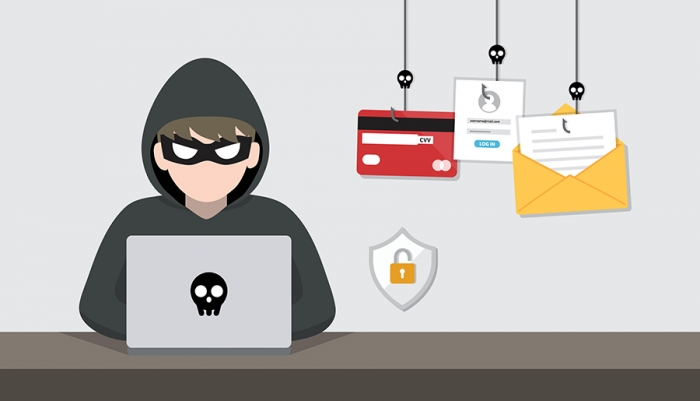

Source picture: https://kswrightassociates.com/

## Business Understanding

**Problem Statement**
Fraud detection adalah proses mengidentifikasi dan mencegah aktivitas atau transaksi penipuan dalam sebuah bisnis atau sistem. Kecurangan dapat berbentuk berbagai hal, seperti kecurangan keuangan, pencurian identitas, kecurangan asuransi, kecurangan kartu kredit, atau aktivitas penipuan di dalam sebuah organisasi. Kecurangan dapat menyebabkan kerugian keuangan yang signifikan, kerusakan reputasi, konsekuensi hukum, serta menurunnya kepercayaan pelanggan.


**Metric Evaluation**

- Type 1 error: False Positive (Konsekuensi: Transaksi normal yang sia-sia)

- Type 2 error: False Negative (Konsekuensi: Lolosnya transaksi fraud)

Berdasarkan konsekuensinya, maka yang akan dilakukan adalah membuat model yang dapat mengurangi transaksi normal yang ditolak, tetapi juga mengurangi lolosnya transaksi fraud.
Dari hal tersebut, metrik antara precision dan recall dari kelas positive (Fraud) harus seimbang. Jadi metric utama yang akan digunakan adalah roc_auc.

## Data Understanding

Dataset source : https://www.kaggle.com/competitions/ieee-fraud-detection/

Note :

- Dataset imbalance
- Sebagian besar fitur bersifat kategori (Nominal, Ordinal, Binary), beberapa dengan kardinalitas tinggi
- Setiap baris data merepresentasikan informasi sebuah informasi di masa lalu

In [140]:
# Processing lib
import pandas as pd
import numpy as np

# Visualization lib
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from mrmr import mrmr_classif

# Model
from sklearn.ensemble._forest import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
import shap

# Ignore Warning
import time
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
shap.initjs()

In [2]:
# Read data
df_train_identity = pd.read_csv('train_identity.csv')
df_train_transaction = pd.read_csv('train_transaction.csv')

df_test_identity = pd.read_csv('test_identity.csv')
df_test_transaction = pd.read_csv('test_transaction.csv')

### Exploratory Data Analysis (EDA)

In [3]:
df_train_identity.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  \
0    NaN    NaN  100.0  NotFound    NaN -480.0    New  NotFound  166.0    NaN   
1    NaN    NaN  100.0  NotFound   49.0 -300.0    New  NotFound  166.0    NaN   
2    0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN   
3    NaN    NaN  100.0  NotFound   52.0    NaN    New  NotFound  225.0    NaN   
4    0.0    0.0  100.0  NotFound    NaN -300.0  Found     Found  166.0   15.0   

   id_19  id_20  id_21  id_22 id_23  id_24  id_25  id_26 id_27  id_28  \
0  542.0  144.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  621.0  500.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
2  410.0  142.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
3  176.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
4  529.0  575.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   

      id_29             id_30                id_31  id_32      id_33  \
0  NotFound       Android 7.0  samsung browser 6.2   32.0  2220x1080   
1  NotFound        iOS 11.1.2   mobile safari 11.0   32.0   1334x750   
2     Found               NaN          chrome 62.0    NaN        NaN   
3  NotFound               NaN          chrome 62.0    NaN        NaN   
4     Found  Mac OS X 10_11_6          chrome 62.0   24.0   1280x800   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0  match_status:2     T     F     T     T     mobile   
1  match_status:1     T     F     F     T     mobile   
2             NaN     F     F     T     T    desktop   
3             NaN     F     F     T     T    desktop   
4  match_status:2     T     F     T     T    desktop   

                      DeviceInfo  
0  SAMSUNG SM-G892A Build/NRD90M  
1                     iOS Device  
2                        Windows  
3                            NaN  
4                          MacOS

In [4]:
df_train_transaction.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
2    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  \
0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  

In [5]:
df_train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [6]:
df_train_transaction.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 394 columns):
 #    Column          Non-Null Count   Dtype  
---   ------          --------------   -----  
 0    TransactionID   590540 non-null  int64  
 1    isFraud         590540 non-null  int64  
 2    TransactionDT   590540 non-null  int64  
 3    TransactionAmt  590540 non-null  float64
 4    ProductCD       590540 non-null  object 
 5    card1           590540 non-null  int64  
 6    card2           581607 non-null  float64
 7    card3           588975 non-null  float64
 8    card4           588963 non-null  object 
 9    card5           586281 non-null  float64
 10   card6           588969 non-null  object 
 11   addr1           524834 non-null  float64
 12   addr2           524834 non-null  float64
 13   dist1           238269 non-null  float64
 14   dist2           37627 non-null   float64
 15   P_emaildomain   496084 non-null  object 
 16   R_emaildomain   137291 non-null  obj

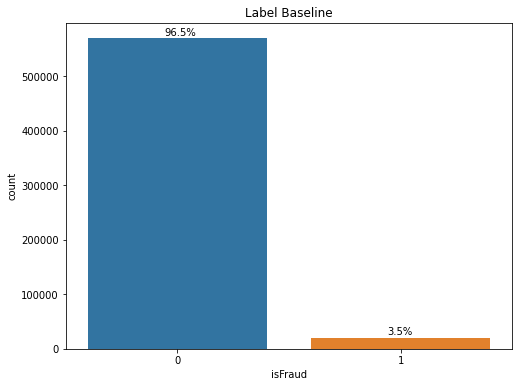

In [7]:
plt.figure(figsize=(8,6))
sns.countplot(df_train_transaction['isFraud'])
for i, v in enumerate(df_train_transaction['isFraud'].value_counts()):
    plt.text(i-0.06, v+5000, str(round((v/df_train_transaction['isFraud'].shape[0])*100, 2))+'%')
plt.title('Label Baseline')
plt.show()

Proporsi label fraud hanya sebesar 3,5%. Walaupun proporsinya hanya 3.5%, jika dilihat dari total yaitu 590.540, fraud yang terjadi sekitar 20.669 kali. Untuk selanjutnya perlu diperhatikan bahwa membangun model pada masalah ini perlu mengadopsi teknik pendekatan dalam kasus imbalance seperti oversampling atau undersampling.

In [8]:
listItem = []
df = pd.merge(df_train_transaction, df_train_identity, on = 'TransactionID', how='left')

for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

dataFeatures dataType    null  nullPct  unique  \
0     TransactionID    int64       0     0.00  590540   
1           isFraud    int64       0     0.00       2   
2     TransactionDT    int64       0     0.00  573349   
3    TransactionAmt  float64       0     0.00   20902   
4         ProductCD   object       0     0.00       5   
5             card1    int64       0     0.00   13553   
6             card2  float64    8933     1.51     500   
7             card3  float64    1565     0.27     114   
8             card4   object    1577     0.27       4   
9             card5  float64    4259     0.72     119   
10            card6   object    1571     0.27       4   
11            addr1  float64   65706    11.13     332   
12            addr2  float64   65706    11.13      74   
13            dist1  float64  352271    59.65    2651   
14            dist2  float64  552913    93.63    1751   
15    P_emaildomain   object   94456    15.99      59   
16    R_emaildomain   object  453249    76.75      60   
17               C1  float64       0     0.00    1657   
18               C2  float64       0     0.00    1216   
19               C3  float64       0     0.00      27   
20               C4  float64       0     0.00    1260   
21               C5  float64       0     0.00     319   
22               C6  float64       0     0.00    1328   
23               C7  float64       0     0.00    1103   
24               C8  float64       0     0.00    1253   
25               C9  float64       0     0.00     205   
26              C10  float64       0     0.00    1231   
27              C11  float64       0     0.00    1476   
28              C12  float64       0     0.00    1199   
29              C13  float64       0     0.00    1597   
30              C14  float64       0     0.00    1108   
31               D1  float64    1269     0.21     641   
32               D2  float64  280797    47.55     641   
33               D3  float64  262878    44.51     649   
34               D4  float64  168922    28.60     808   
35               D5  float64  309841    52.47     688   
36               D6  float64  517353    87.61     829   
37               D7  float64  551623    93.41     597   
38               D8  float64  515614    87.31   12353   
39               D9  float64  515614    87.31      24   
40              D10  float64   76022    12.87     818   
41              D11  float64  279287    47.29     676   
42              D12  float64  525823    89.04     635   
43              D13  float64  528588    89.51     577   
44              D14  float64  528353    89.47     802   
45              D15  float64   89113    15.09     859   
46               M1   object  271100    45.91       2   
47               M2   object  271100    45.91       2   
48               M3   object  271100    45.91       2   
49               M4   object  281444    47.66       3   
50               M5   object  350482    59.35       2   
51               M6   object  169360    28.68       2   
52               M7   object  346265    58.64       2   
53               M8   object  346252    58.63       2   
54               M9   object  346252    58.63       2   
55               V1  float64  279287    47.29       2   
56               V2  float64  279287    47.29       9   
57               V3  float64  279287    47.29      10   
58               V4  float64  279287    47.29       7   
59               V5  float64  279287    47.29       7   
60               V6  float64  279287    47.29      10   
61               V7  float64  279287    47.29      10   
62               V8  float64  279287    47.29       9   
63               V9  float64  279287    47.29       9   
64              V10  float64  279287    47.29       5   
65              V11  float64  279287    47.29       6   
66              V12  float64   76073    12.88       4   
67              V13  float64   76073    12.88       7   
68              V14  float64   76073    12.88       2   
69              V

In [204]:
dfDesc.sort_values('nullPct', ascending=False)

dataFeatures dataType    null  nullPct  unique  \
417           id_24  float64  585793    99.20      12   
418           id_25  float64  585408    99.13     341   
419           id_26  float64  585377    99.13      95   
414           id_21  float64  585381    99.13     490   
401           id_08  float64  585385    99.13      94   
400           id_07  float64  585385    99.13      84   
420           id_27   object  585371    99.12       2   
416           id_23   object  585371    99.12       3   
415           id_22  float64  585371    99.12      25   
14            dist2  float64  552913    93.63    1751   
37               D7  float64  551623    93.41     597   
411           id_18  float64  545427    92.36      18   
43              D13  float64  528588    89.51     577   
44              D14  float64  528353    89.47     802   
42              D12  float64  525823    89.04     635   
396           id_03  float64  524216    88.77      24   
397           id_04  float64  524216    88.77      15   
36               D6  float64  517353    87.61     829   
426           id_33   object  517251    87.59     260   
402           id_09  float64  515614    87.31      46   
403           id_10  float64  515614    87.31      62   
38               D8  float64  515614    87.31   12353   
39               D9  float64  515614    87.31      24   
423           id_30   object  512975    86.87      75   
425           id_32  float64  512954    86.86       4   
427           id_34   object  512735    86.82       4   
407           id_14  float64  510496    86.45      25   
211            V157  float64  508595    86.12      25   
212            V158  float64  508595    86.12      25   
213            V159  float64  508589    86.12    6663   
210            V156  float64  508595    86.12      25   
209            V155  float64  508595    86.12      25   
214            V160  float64  508589    86.12    9621   
208            V154  float64  508595    86.12      19   
207            V153  float64  508595    86.12      19   
197            V143  float64  508589    86.12     870   
206            V152  float64  508589    86.12      39   
205            V151  float64  508589    86.12      56   
204            V150  float64  508589    86.12    1996   
203            V149  float64  508595    86.12      21   
202            V148  float64  508595    86.12      21   
201            V147  float64  508595    86.12      27   
200            V146  float64  508595    86.12      25   
199            V145  float64  508589    86.12     260   
198            V144  float64  508589    86.12      63   
216            V162  float64  508595    86.12     185   
196            V142  float64  508595    86.12      10   
195            V141  float64  508595    86.12       6   
194            V140  float64  508595    86.12      34   
215            V161  float64  508595    86.12      79   
217            V163  float64  508595    86.12     106   
218            V164  float64  508589    86.12    1978   
192            V138  float64  508595    86.12      23   
219            V165  float64  508589    86.12    2547   
193            V139  float64  508595    86.12      34   
220            V166  float64  508589    86.12     987   
377            V323  float64  508189    86.05    1411   
386            V332  float64  508189    86.05    2453   
393            V339  float64  508189    86.05     334   
392            V338  float64  508189    86.05     380   
391            V337  float64  508189    86.05     254   
390            V336  float64  508189    86.05     356   
389            V335  float64  508189    86.05     672   
388            V334  float64  508189    86.05     143   
387            V333  float64  508189    86.05    1971   
385            V331  float64  508189    86.05    1758   
378            V324  float64  508189    86.05     976   
384            V330  float64  508189    86.05      56   
382            V328  float64  508189    86.05      16   
381            V3

Missing value pada dataset memiliki jumlah yang beragam, dari 1% hingga 99%. Dari total keseluruhan 433 fitur, terdapat 382 fitur yang memiliki missing value. 

In [10]:
dfDesc[dfDesc['dataType'] == 'object']

dataFeatures dataType    null  nullPct  unique  \
4        ProductCD   object       0     0.00       5   
8            card4   object    1577     0.27       4   
10           card6   object    1571     0.27       4   
15   P_emaildomain   object   94456    15.99      59   
16   R_emaildomain   object  453249    76.75      60   
46              M1   object  271100    45.91       2   
47              M2   object  271100    45.91       2   
48              M3   object  271100    45.91       2   
49              M4   object  281444    47.66       3   
50              M5   object  350482    59.35       2   
51              M6   object  169360    28.68       2   
52              M7   object  346265    58.64       2   
53              M8   object  346252    58.63       2   
54              M9   object  346252    58.63       2   
405          id_12   object  446307    75.58       2   
408          id_15   object  449555    76.13       3   
409          id_16   object  461200    78.10       2   
416          id_23   object  585371    99.12       3   
420          id_27   object  585371    99.12       2   
421          id_28   object  449562    76.13       2   
422          id_29   object  449562    76.13       2   
423          id_30   object  512975    86.87      75   
424          id_31   object  450258    76.25     130   
426          id_33   object  517251    87.59     260   
427          id_34   object  512735    86.82       4   
428          id_35   object  449555    76.13       2   
429          id_36   object  449555    76.13       2   
430          id_37   object  449555    76.13       2   
431          id_38   object  449555    76.13       2   
432     DeviceType   object  449730    76.16       2   
433     DeviceInfo   object  471874    79.91    1786   

                                         uniqueSample  
4                                              [C, S]  
8                                  [visa, mastercard]  
10                     [debit or credit, charge card]  
15                        [roadrunner.com, sc.rr.com]  
16                             [yahoo.com, gmail.com]  
46                                           [nan, T]  
47                                           [nan, F]  
48                                           [F, nan]  
49                                          [nan, M2]  
50                                             [T, F]  
51                                           [F, nan]  
52                                           [F, nan]  
53                                           [nan, T]  
54                                           [nan, F]  
405                                      [Found, nan]  
408                                  [Unknown, Found]  
409                                   [NotFound, nan]  
416                       [IP_PROXY:TRANSPARENT, nan]  
420                                      [nan, Found]  
421                                      [nan, Found]  
422                                   [nan, NotFound]  
423                                 [iOS, iOS 11.3.1]  
424     [chrome 49.0 for android, mobile safari 10.0]  
426                              [801x480, 2880x1800]  
427                            [nan, match_status:-1]  
428                                            [T, F]  
429                                            [F, T]  
430                                            [F, T]  
431                                          [F, nan]  
432                                 [mobile, desktop]  
433  [SM-G925P Build/NRD90M, XT1021 Build/KXC21.5-40]

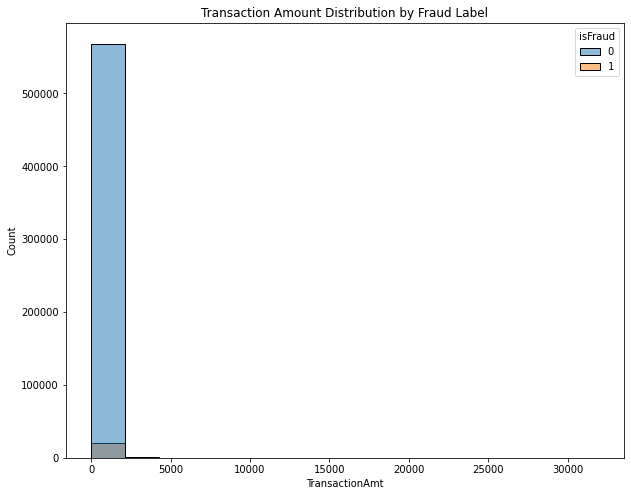

In [11]:
plt.figure(figsize=(10,8))
sns.histplot(data=df, x='TransactionAmt', hue='isFraud', bins=15)
plt.title('Transaction Amount Distribution by Fraud Label')
plt.show()

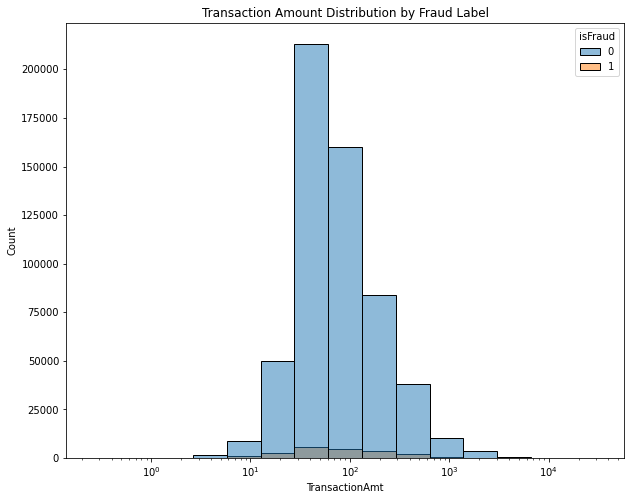

In [12]:
plt.figure(figsize=(10,8))
sns.histplot(data=df, x='TransactionAmt', hue='isFraud', log_scale=True, bins=15)
plt.title('Transaction Amount Distribution by Fraud Label')
plt.show()

Mayoritas jumlah transaksi atau TransactionAmt adalah 10 - 1000 USD.

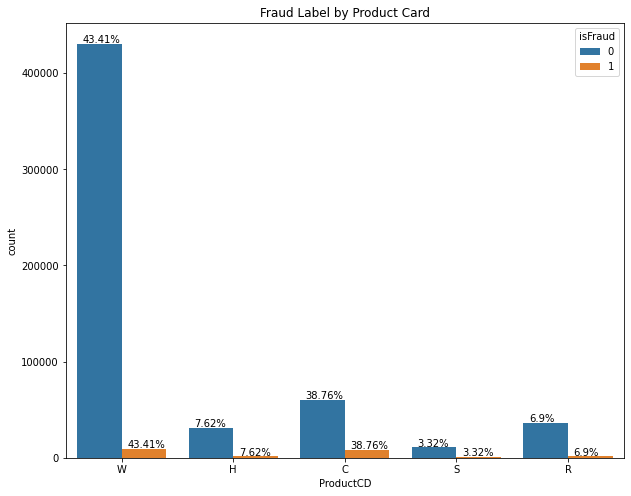

In [13]:
plt.figure(figsize=(10,8))
sns.countplot(data=df, x='ProductCD', hue='isFraud')
plt.title('Fraud Label by Product Card')

for i, card in enumerate(['W', 'H', 'C', 'S', 'R']):
    long_0 = df[(df['ProductCD'] == card) & (df['isFraud'] == 0)].shape[0]
    long_1 = df[(df['ProductCD'] == card) & (df['isFraud'] == 1)].shape[0]
    
    plt.text(i-0.35, long_0+1000, str(round((long_1/df[(df['isFraud'] == 1)].shape[0])*100, 2)) + '%')
    plt.text(i+0.05, long_1+1000, str(round((long_1/df[(df['isFraud'] == 1)].shape[0])*100, 2)) + '%')

plt.show()

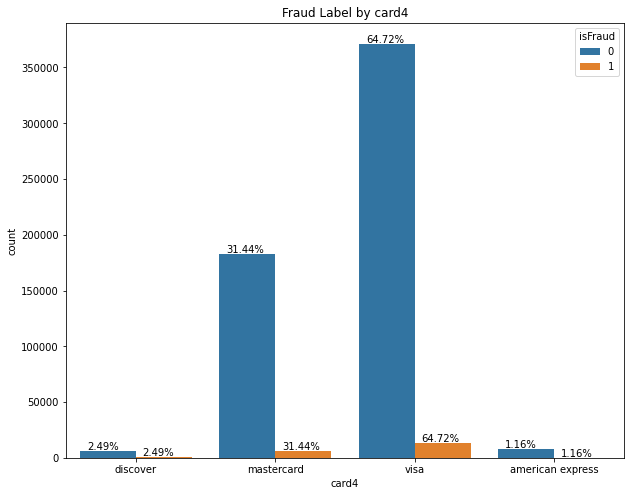

In [250]:
my_list = ['card4', 'card6', 'P_emaildomain']

plt.figure(figsize=(10,8))
sns.countplot(data=df, x='card4', hue='isFraud')
plt.title(f'Fraud Label by card4')

for i, card in enumerate(['discover', 'mastercard', 'visa', 'american express']):
    long_0 = df[(df['card4'] == card) & (df['isFraud'] == 0)].shape[0]
    long_1 = df[(df['card4'] == card) & (df['isFraud'] == 1)].shape[0]
    
    plt.text(i-0.35, long_0+1000, str(round((long_1/df[(df['isFraud'] == 1)].shape[0])*100, 2)) + '%')
    plt.text(i+0.05, long_1+1000, str(round((long_1/df[(df['isFraud'] == 1)].shape[0])*100, 2)) + '%')

plt.show()

Insight:
- Sekitar 82% kasus fraud terjadi pada ProductCD yang bernilai W dan C. 
- Kasus fraud terbanyak terjadi pada jenis kartu visa yaitu sekitar 64.72%, lalu diikuti dengan jenis kartu mastercard sebanyak 31.44%. Adapun kasus fraud yang paling rendah yaitu menggunakan jenis kartu American express yaitu hanya 1.16%.

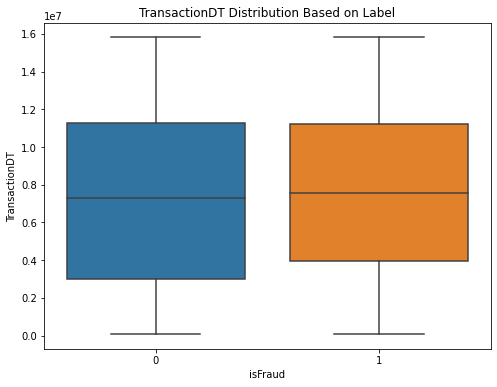

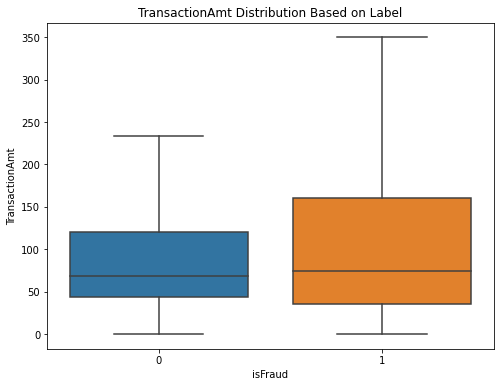

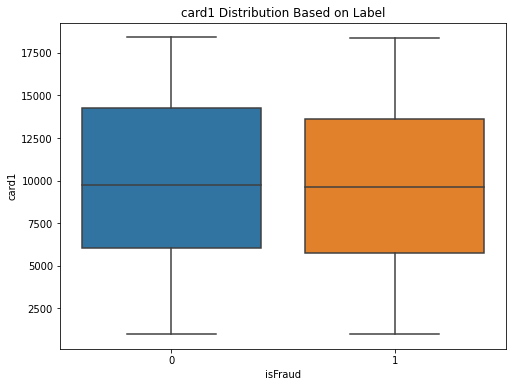

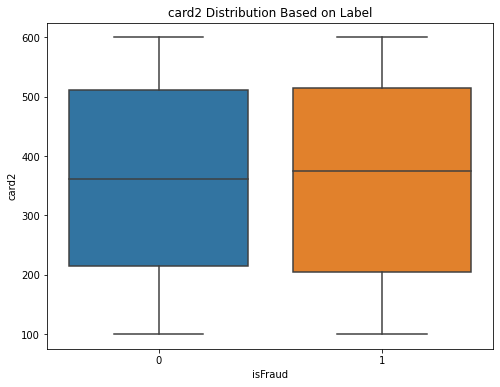

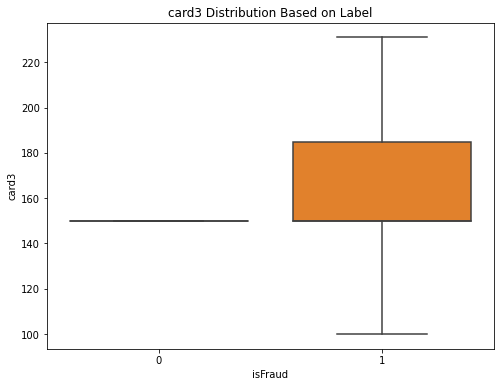

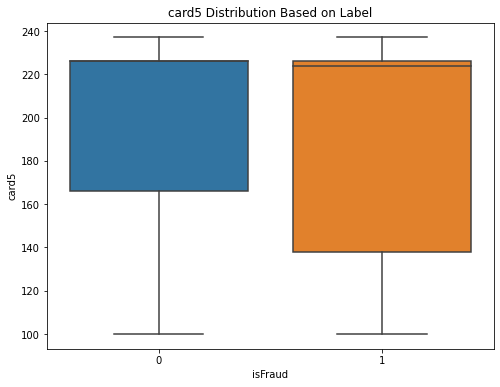

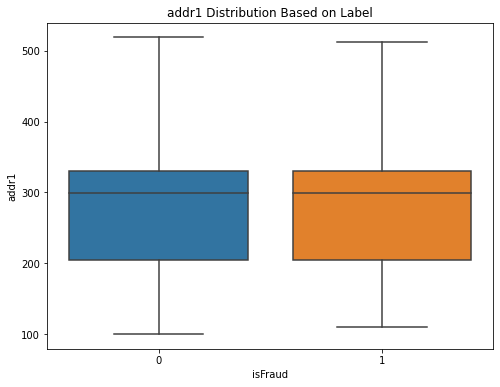

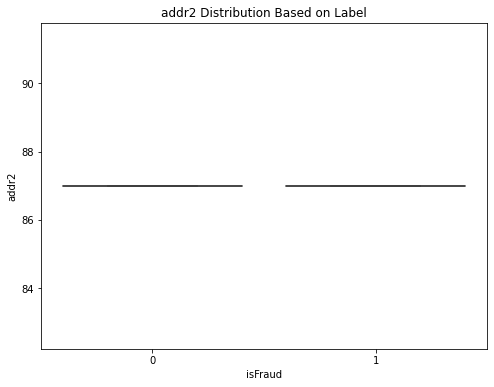

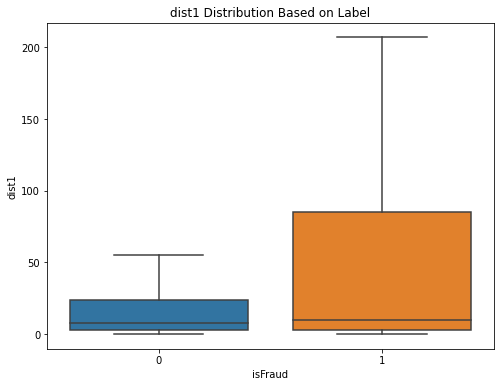

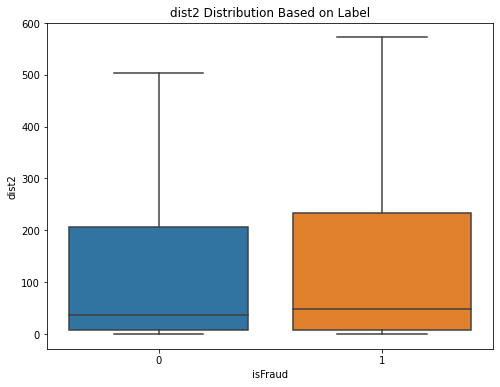

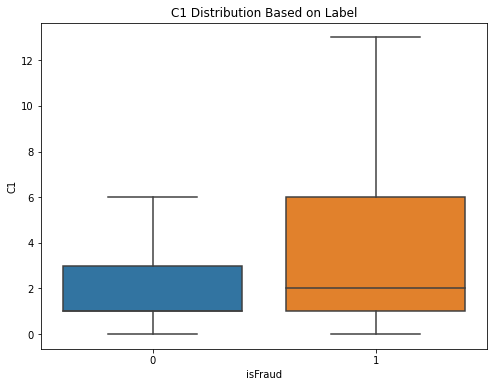

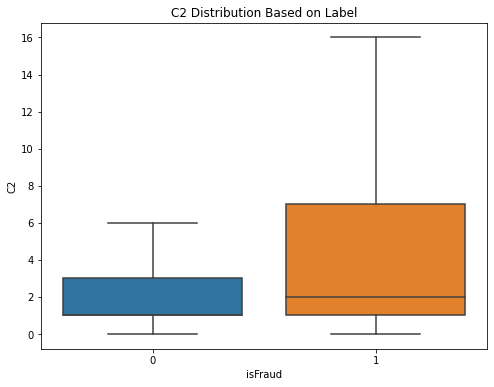

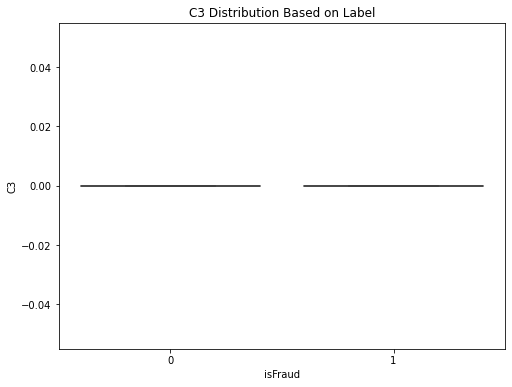

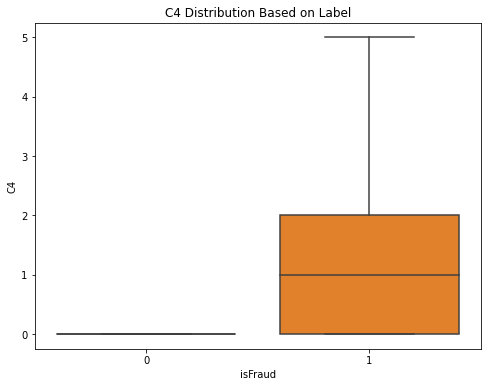

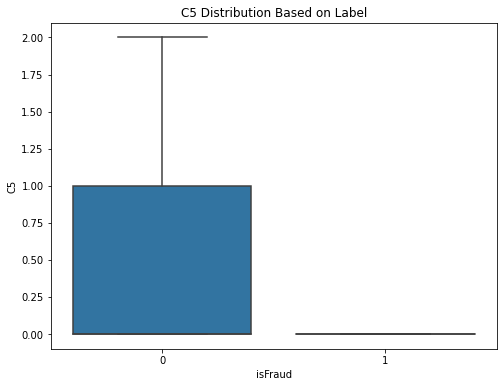

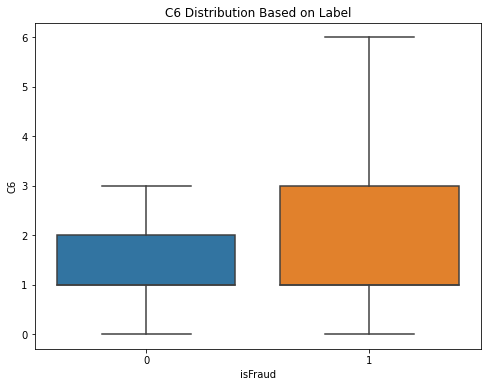

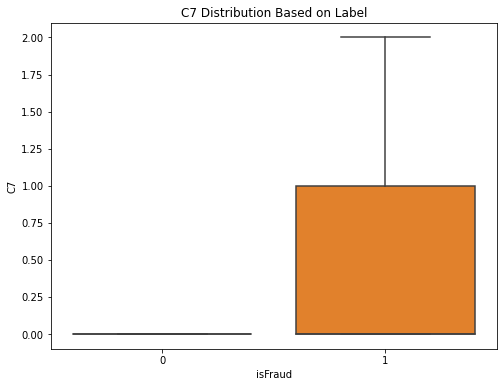

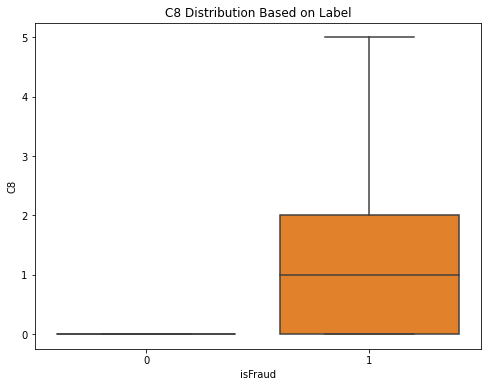

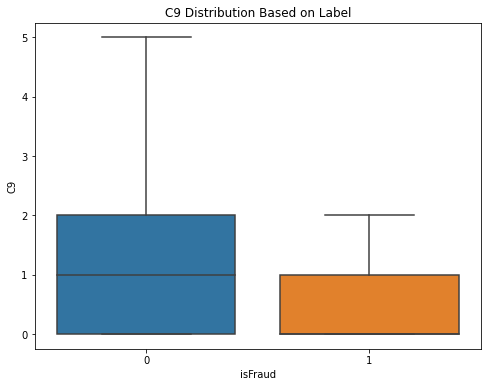

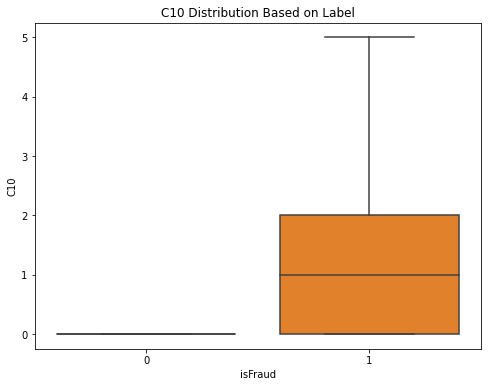

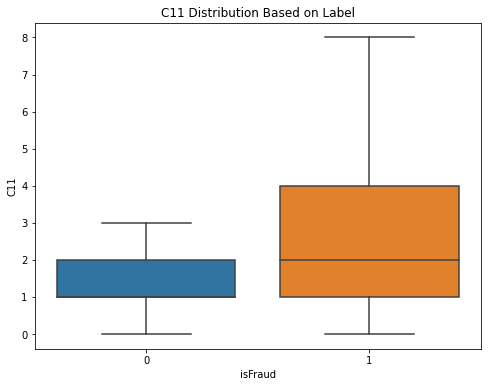

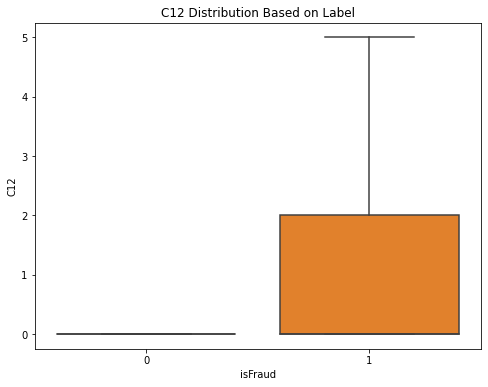

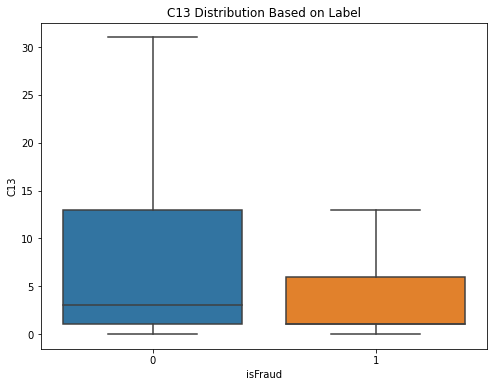

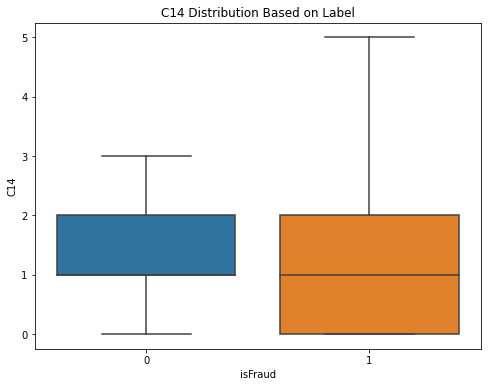

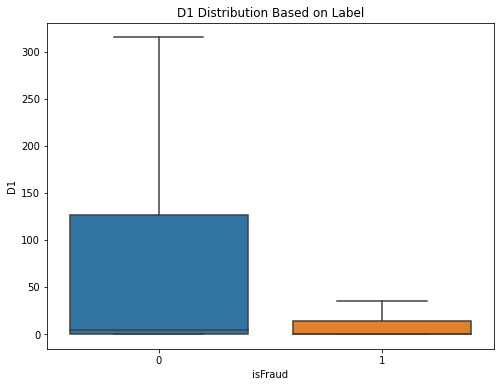

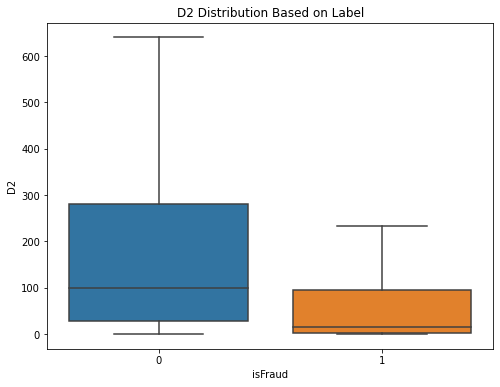

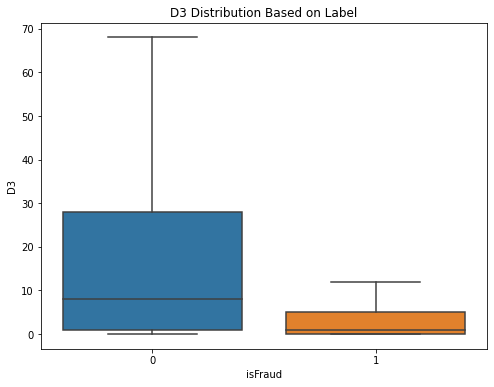

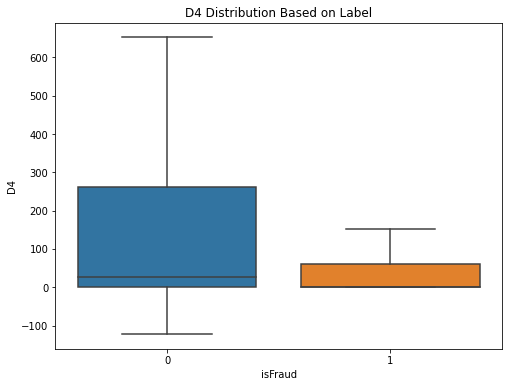

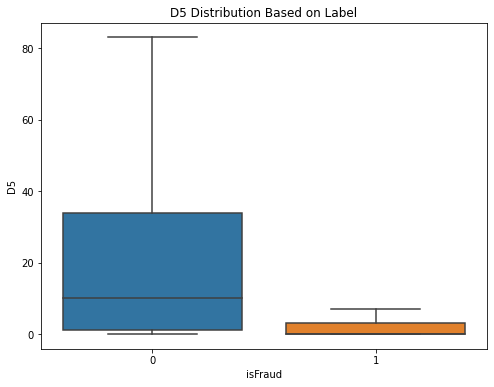

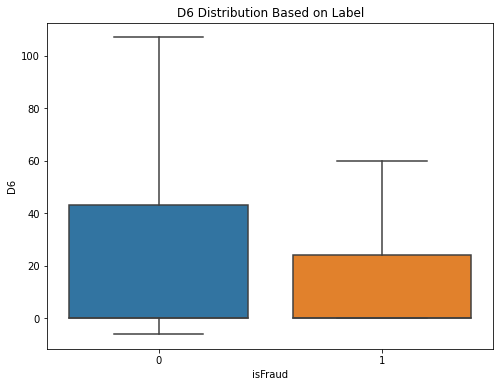

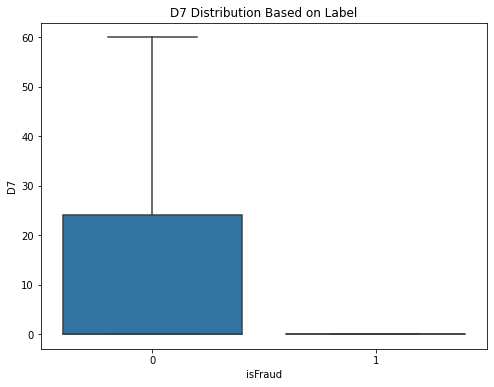

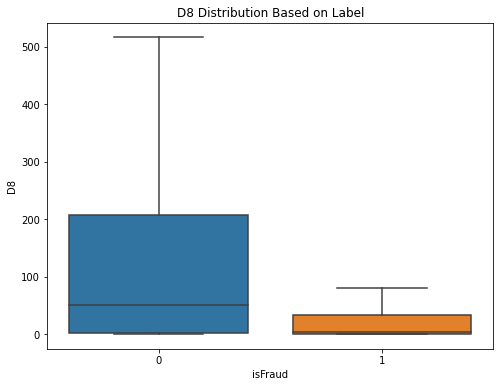

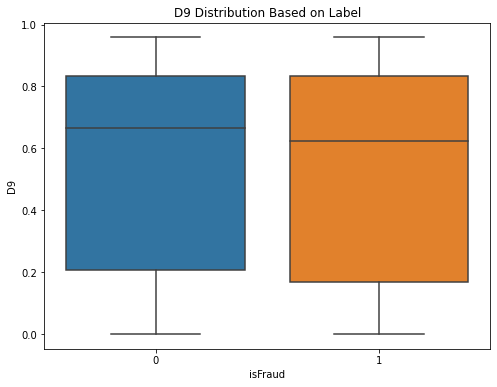

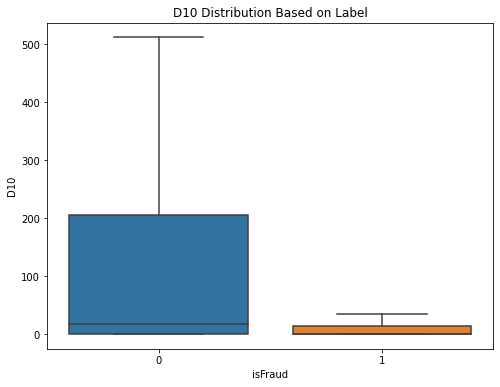

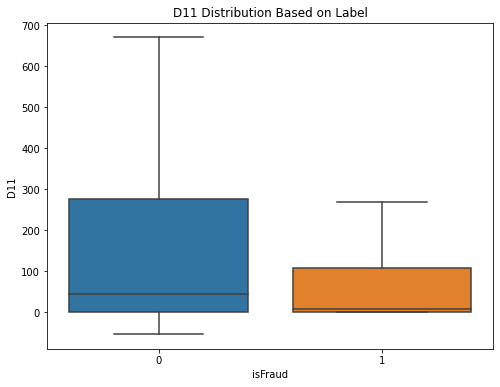

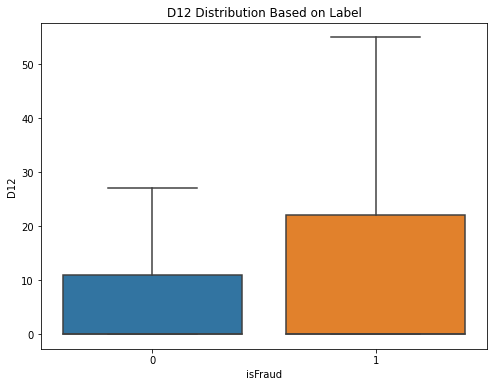

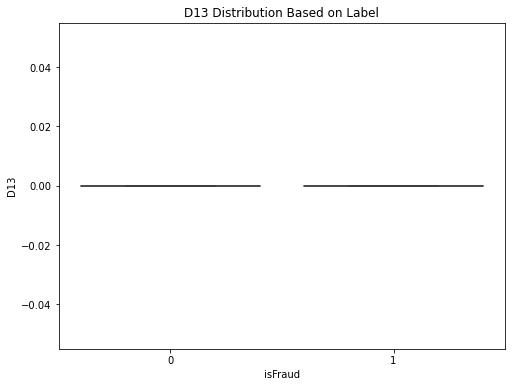

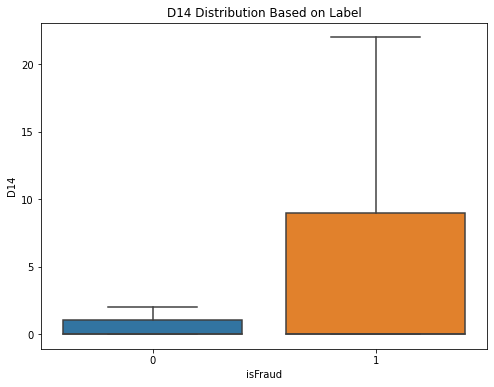

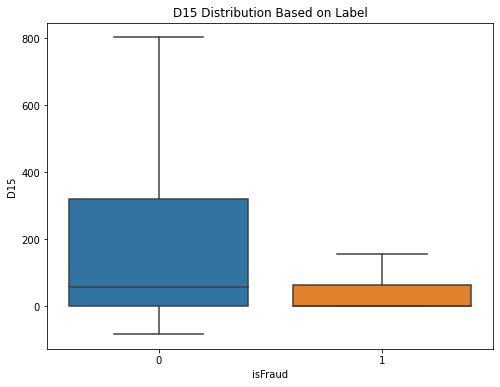

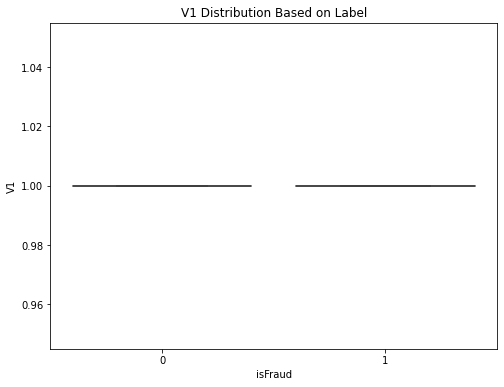

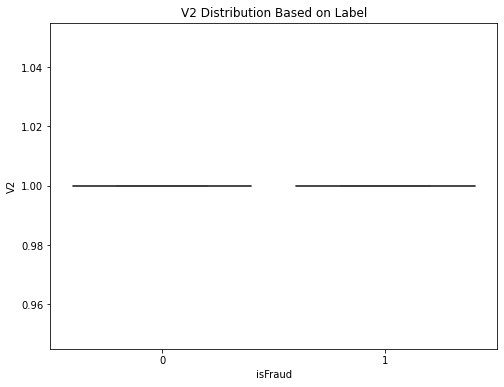

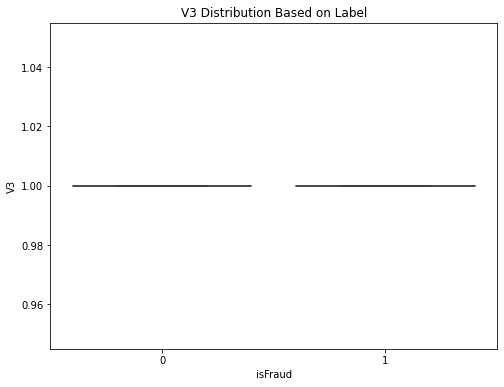

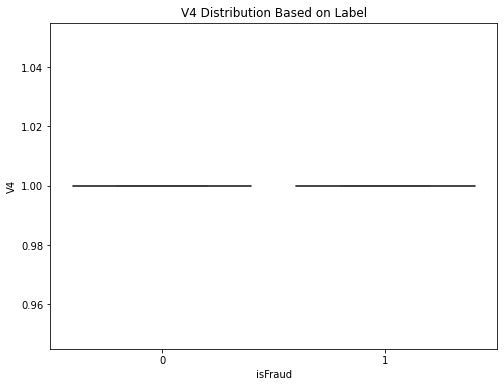

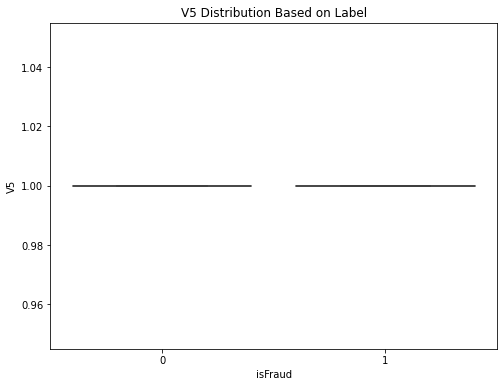

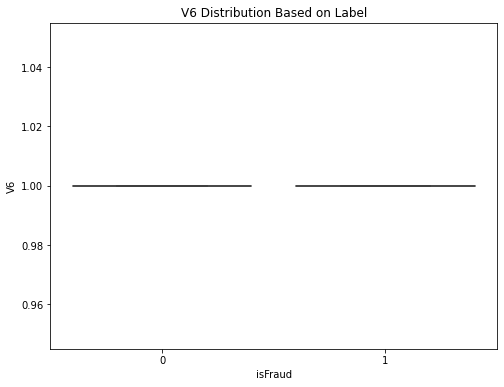

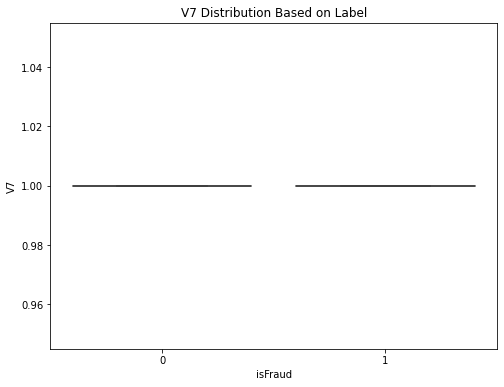

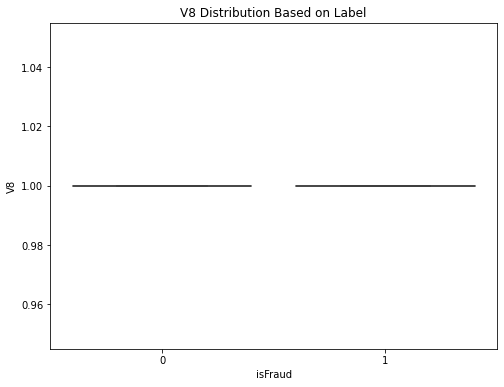

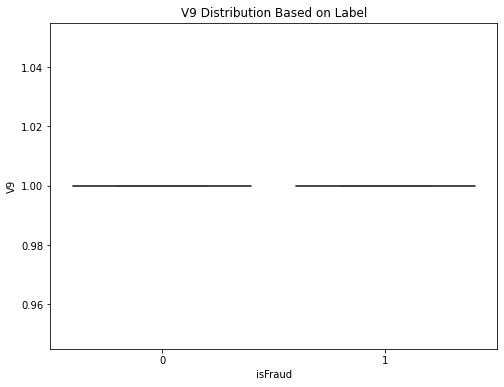

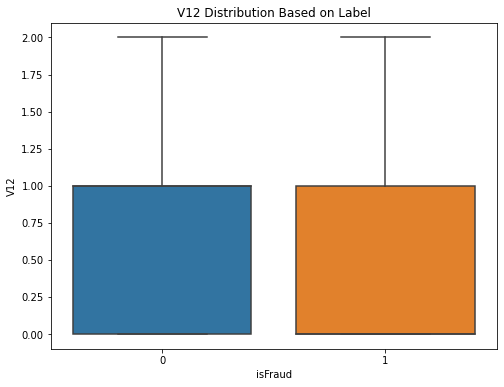

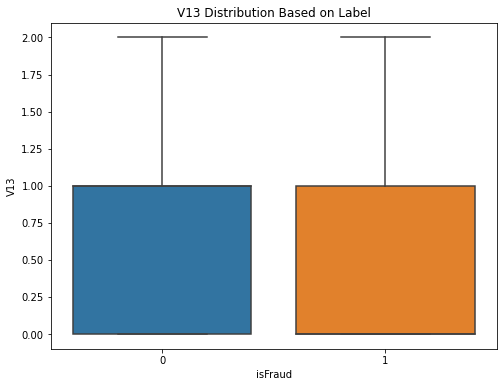

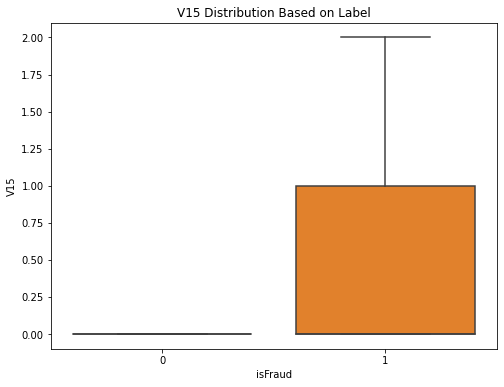

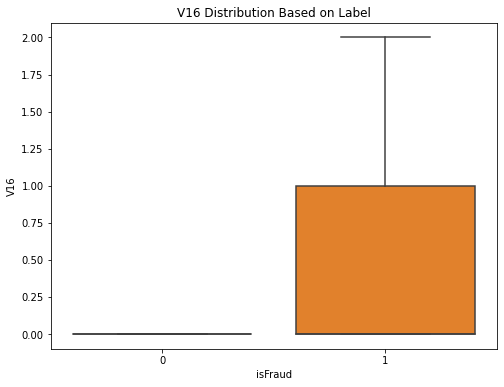

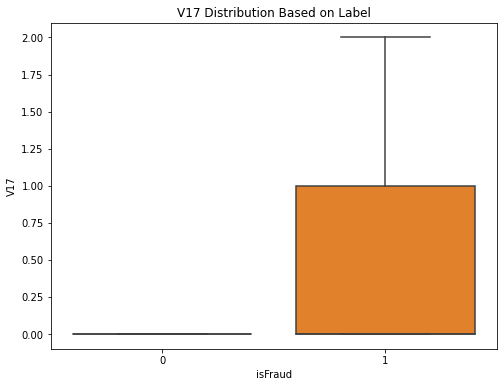

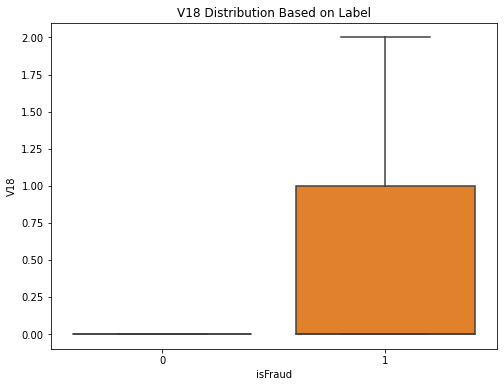

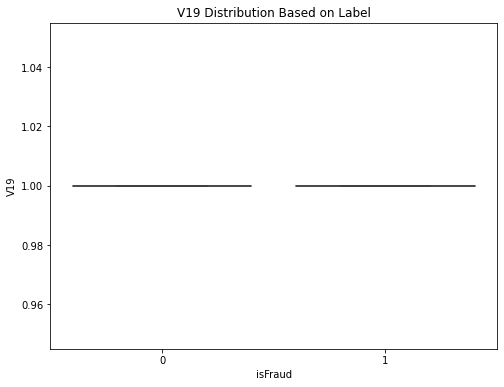

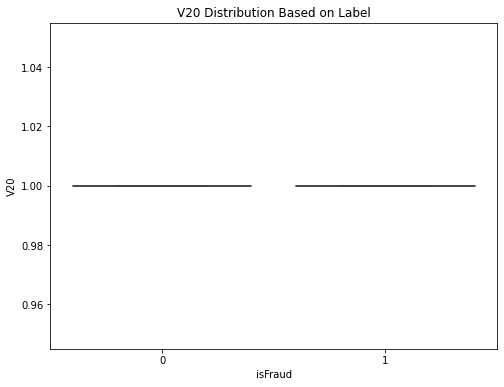

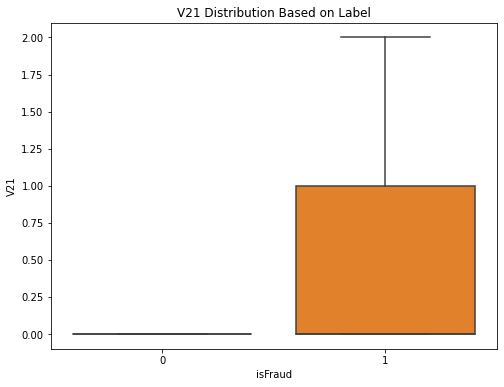

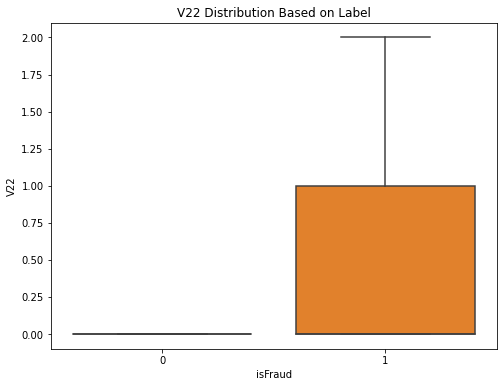

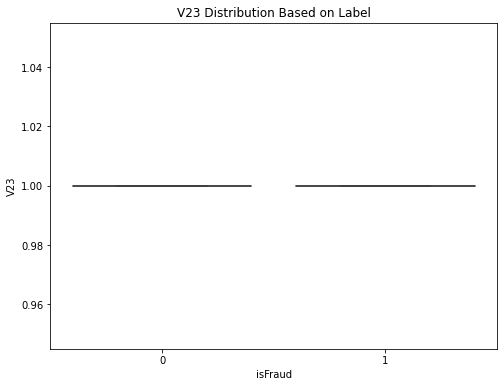

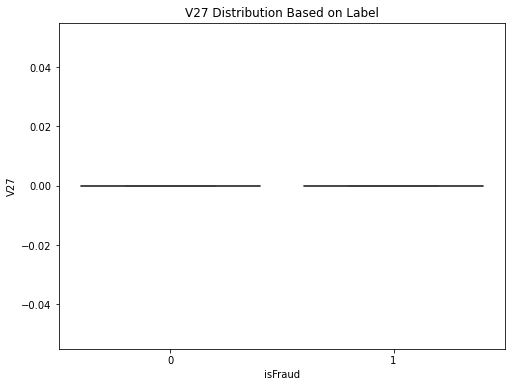

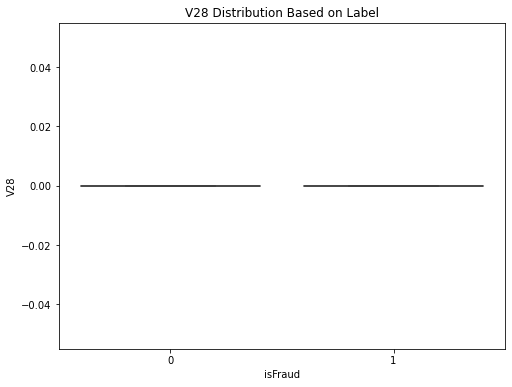

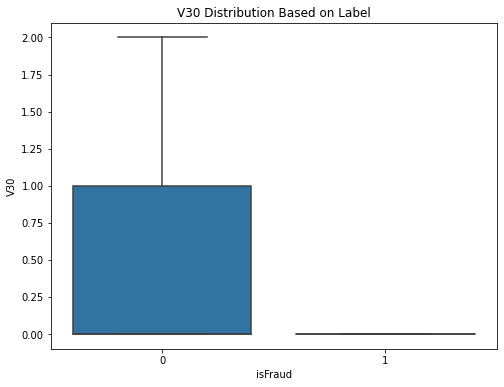

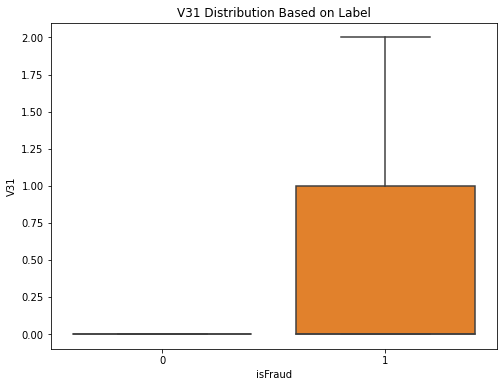

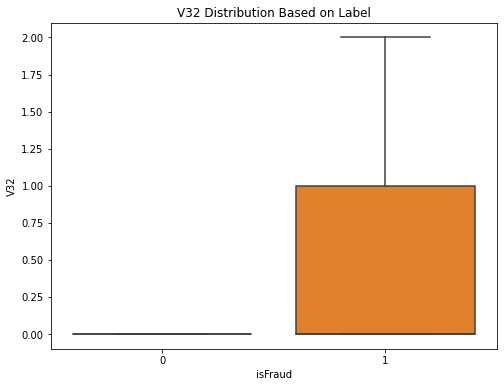

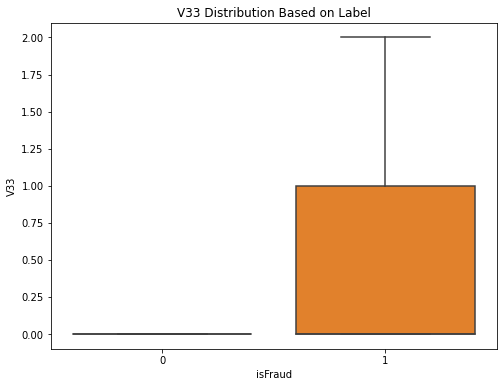

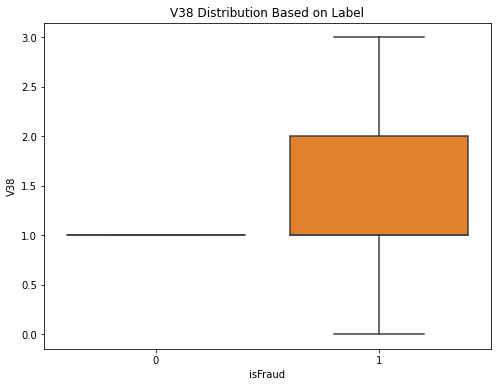

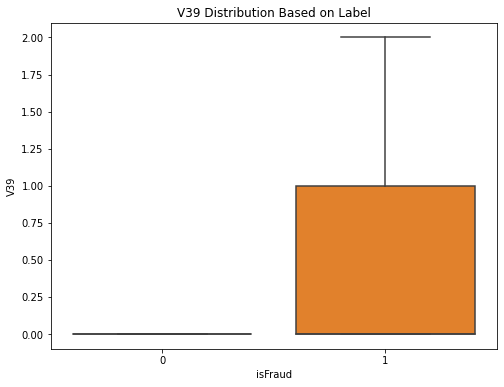

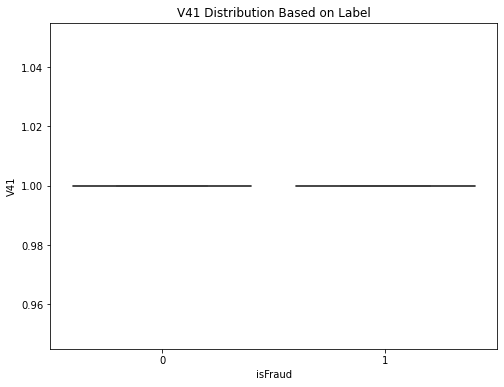

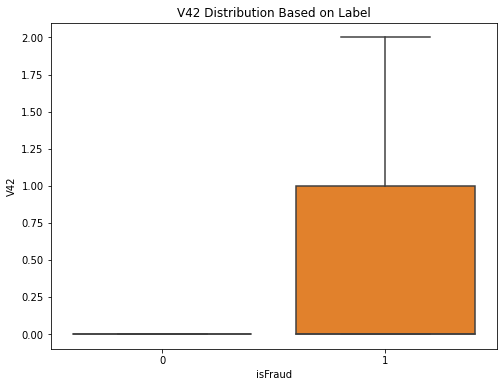

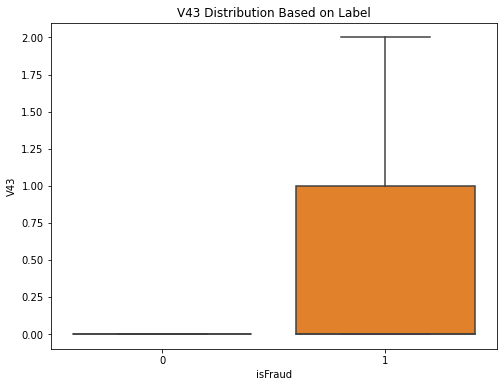

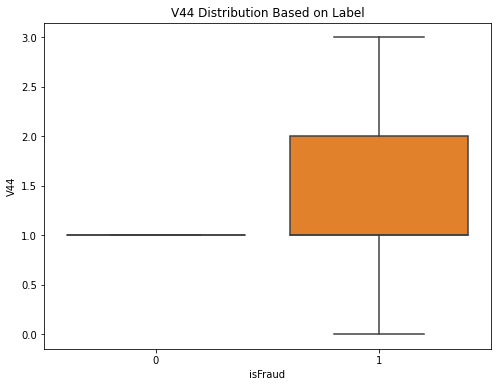

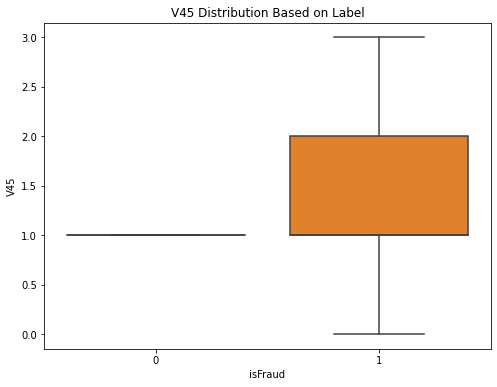

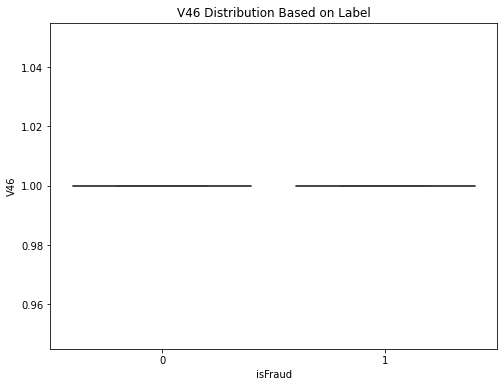

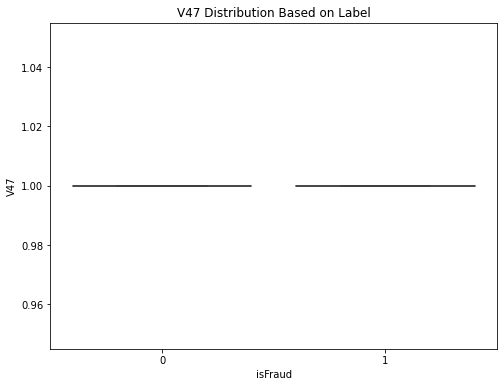

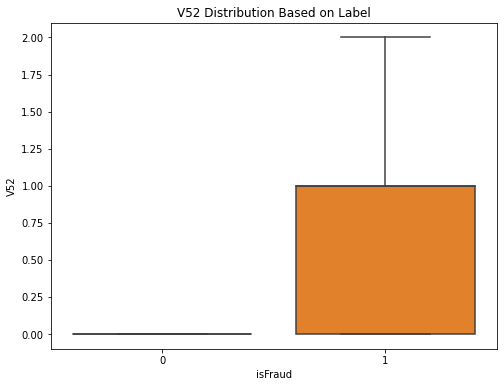

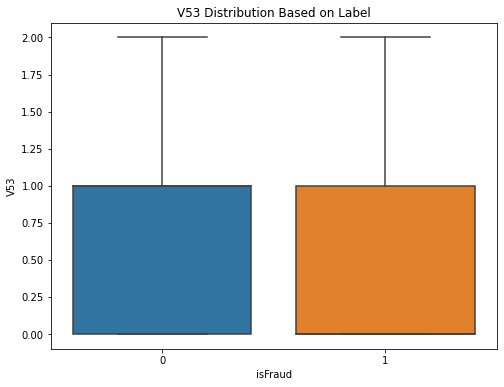

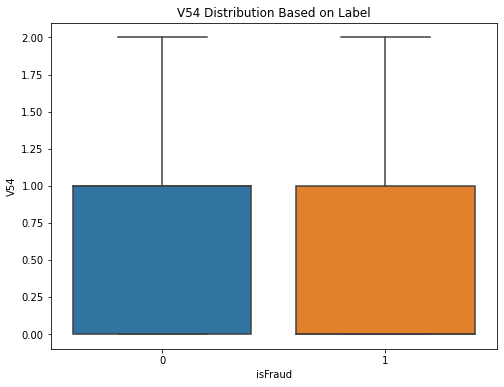

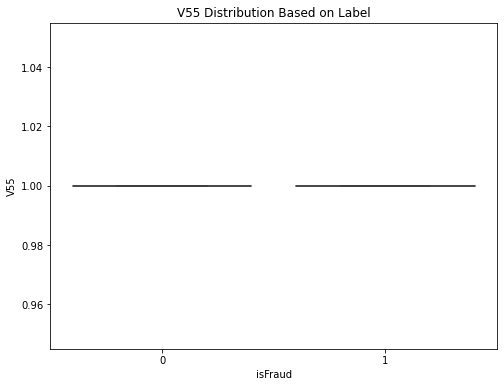

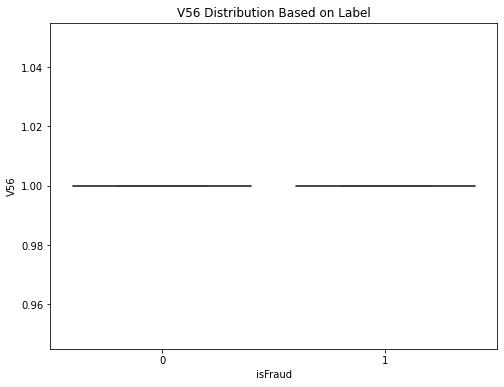

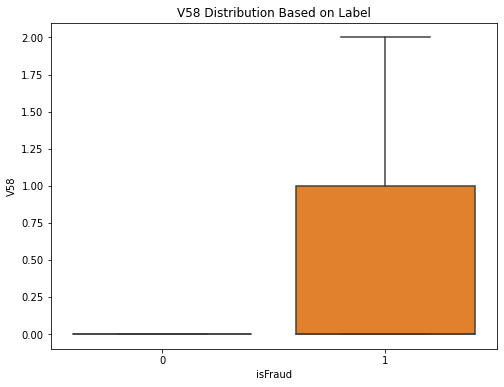

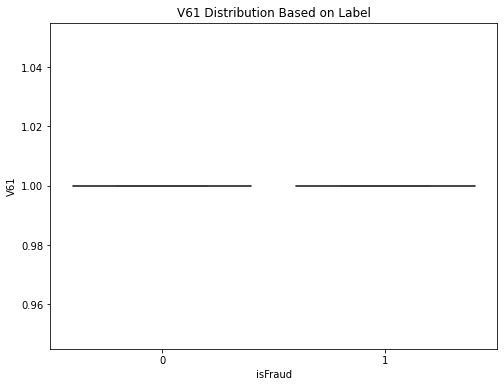

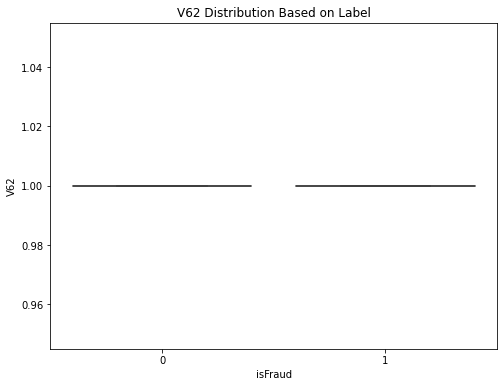

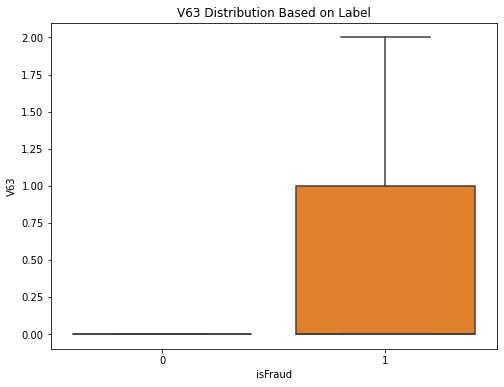

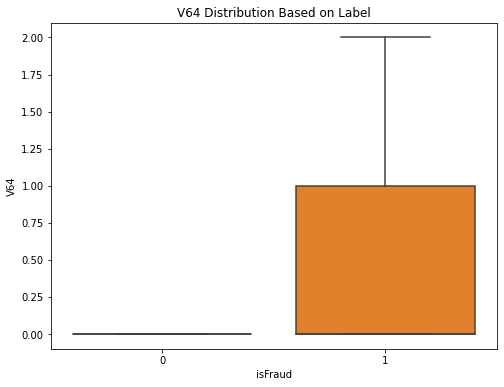

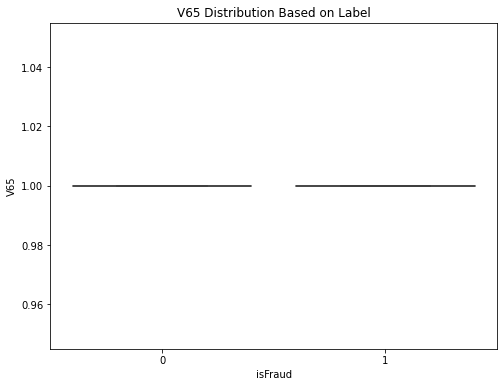

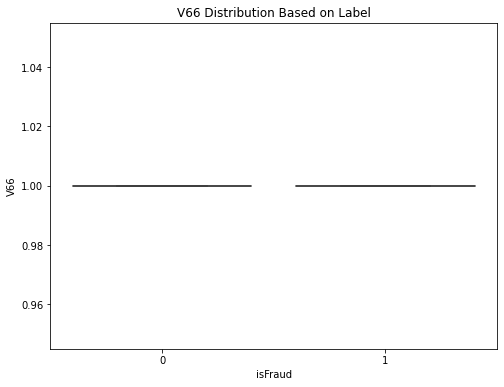

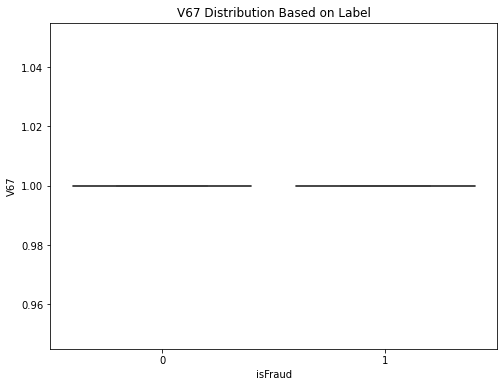

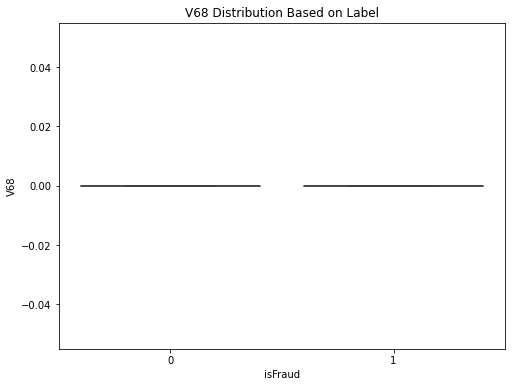

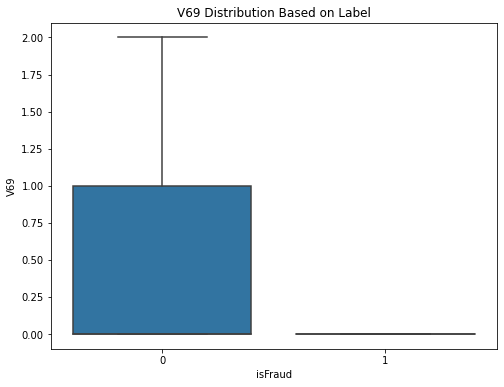

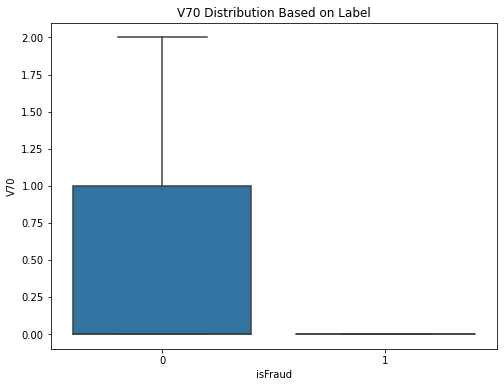

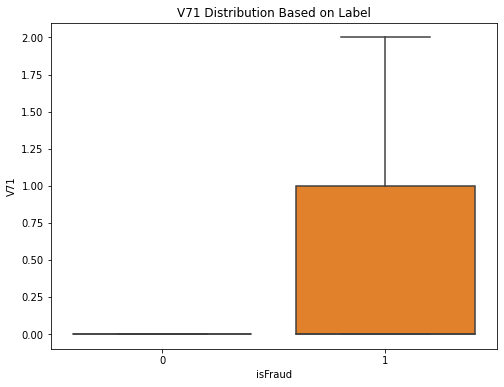

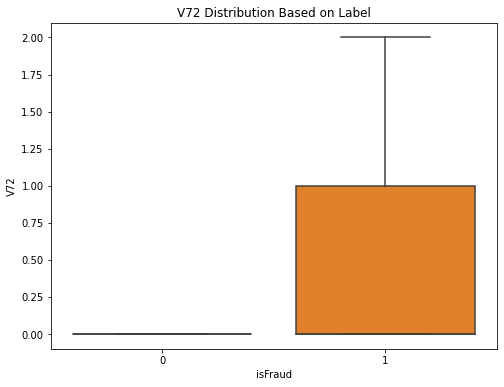

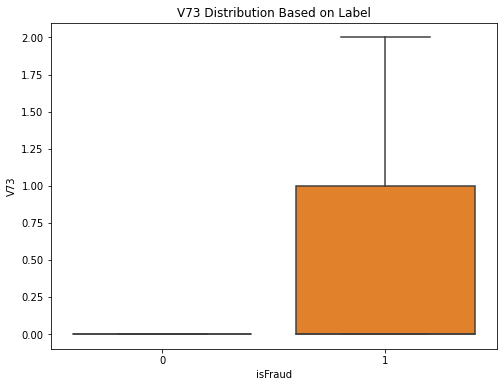

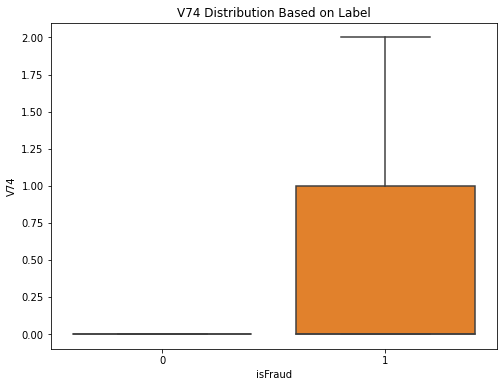

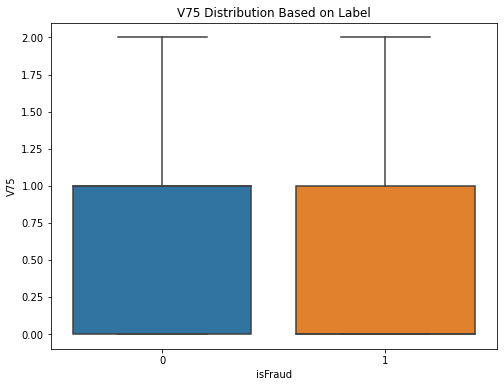

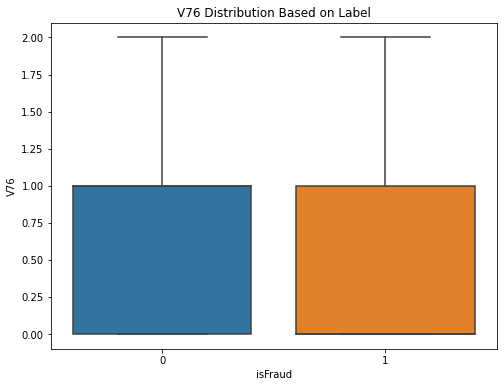

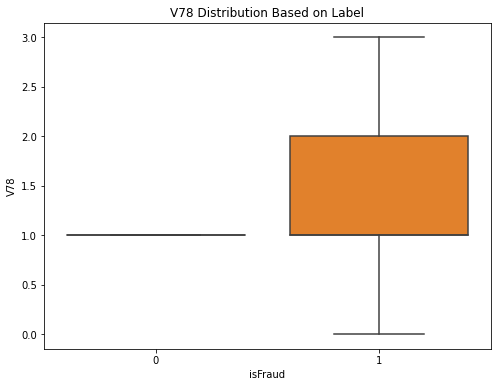

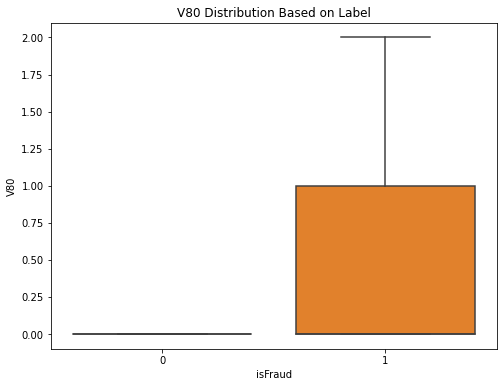

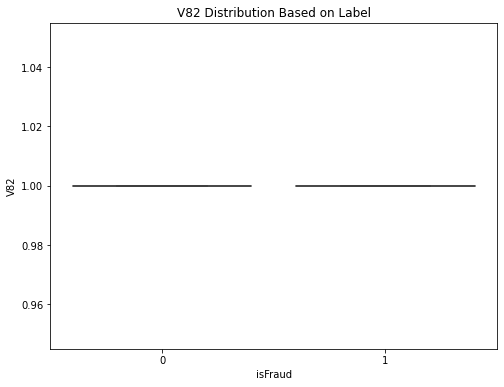

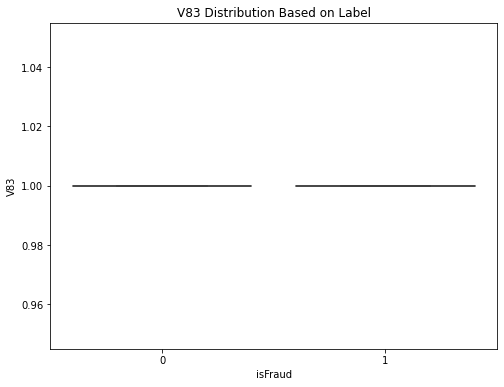

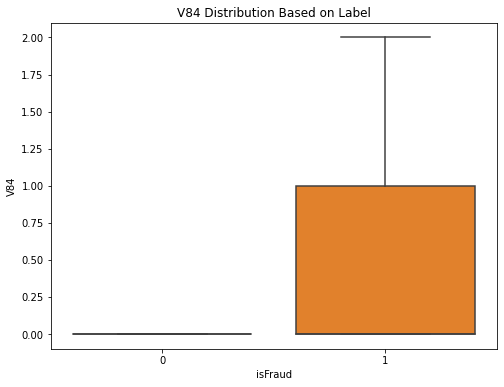

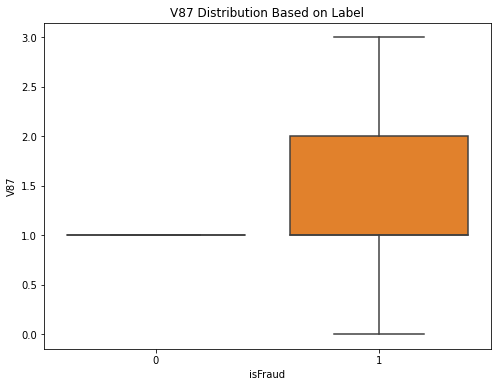

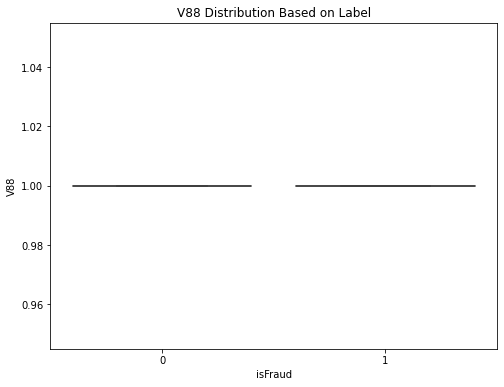

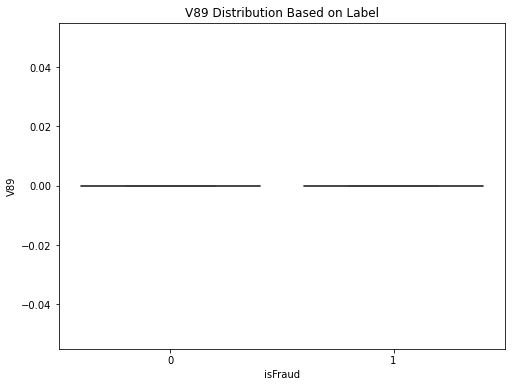

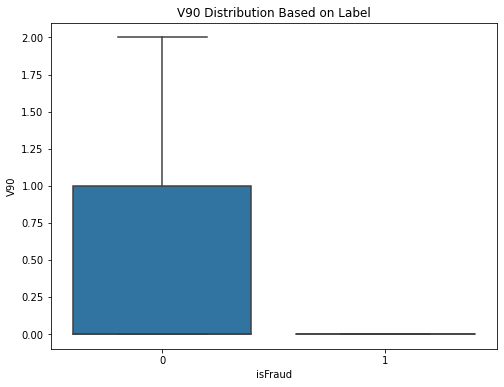

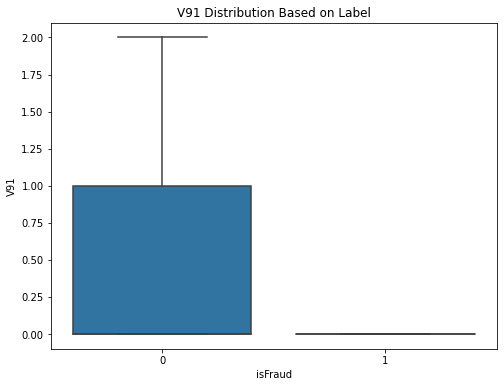

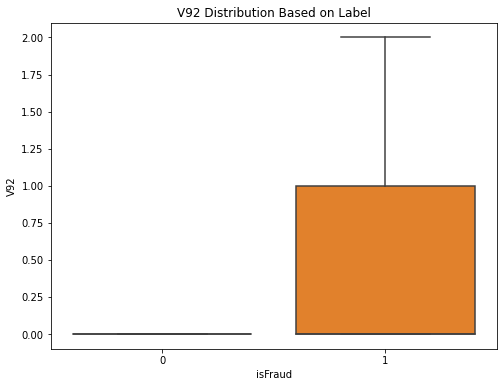

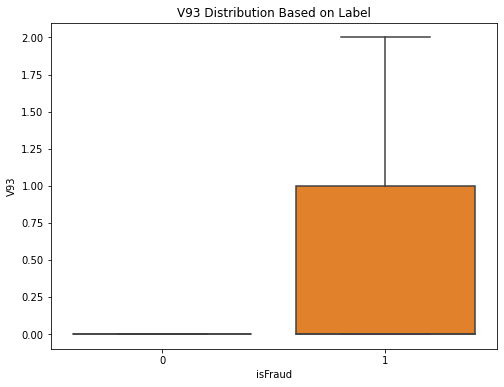

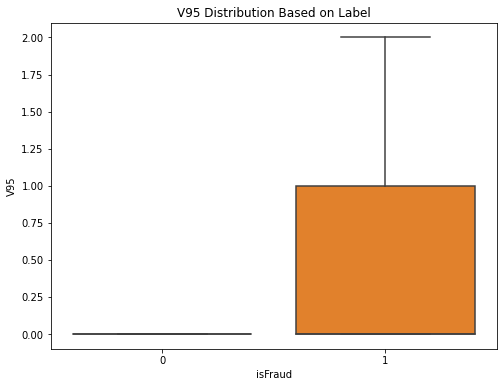

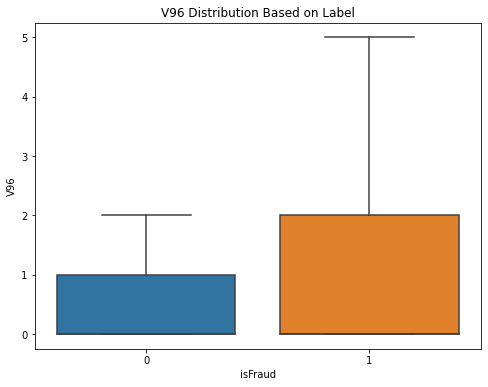

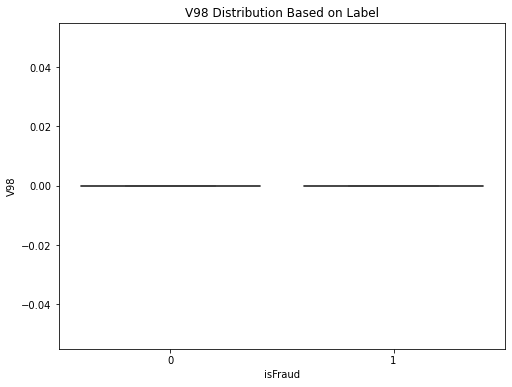

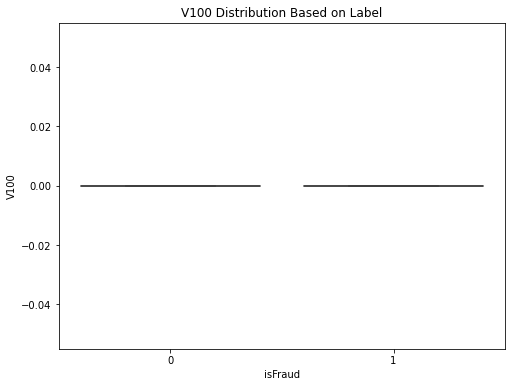

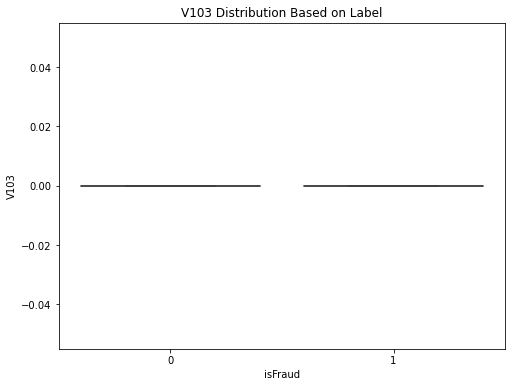

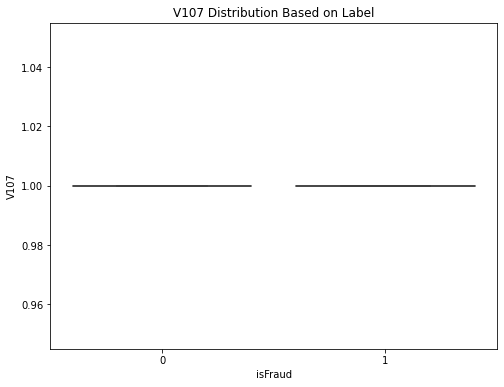

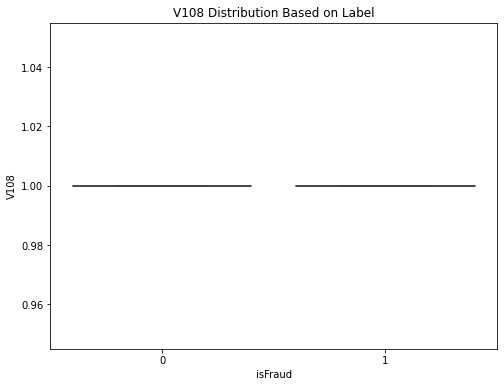

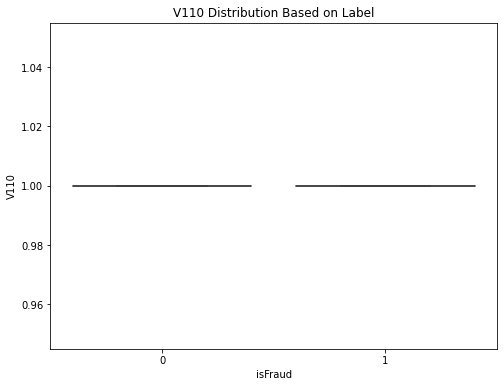

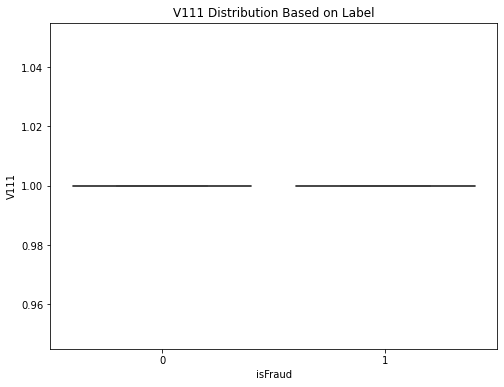

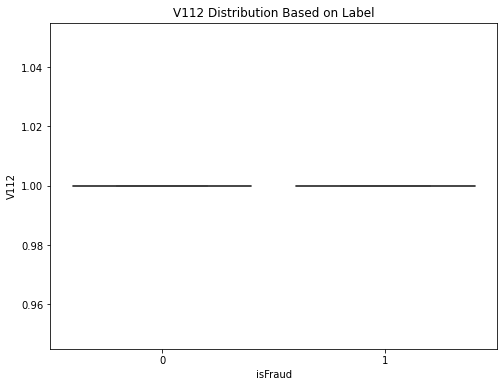

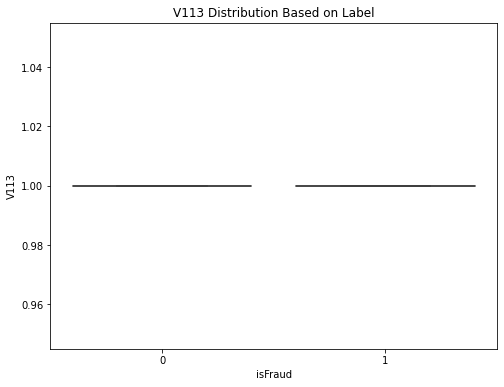

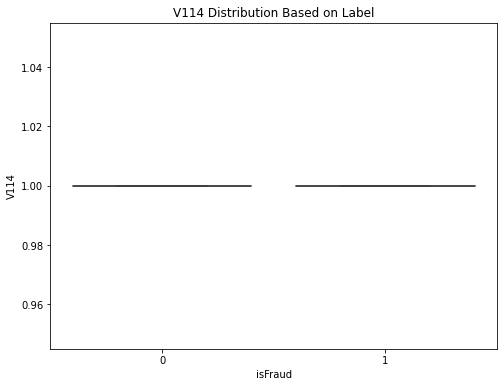

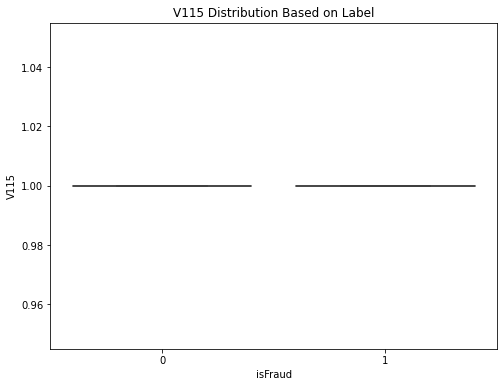

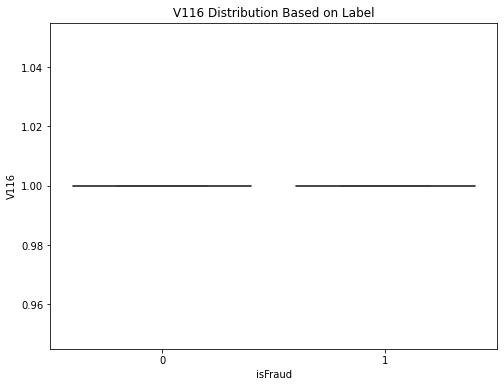

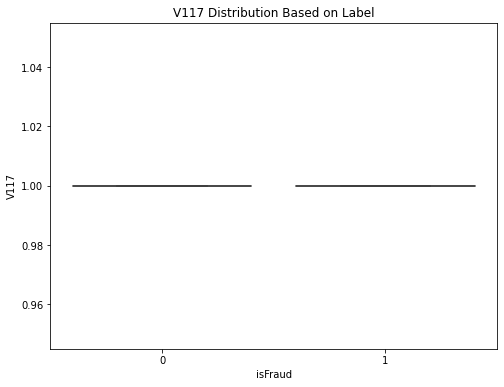

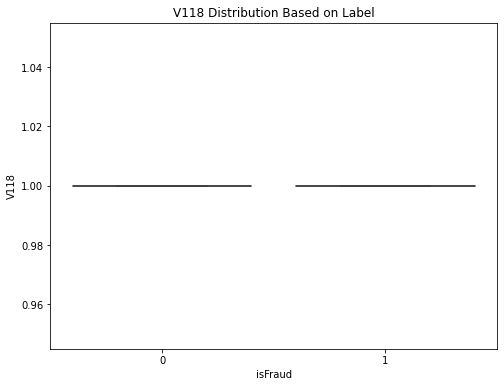

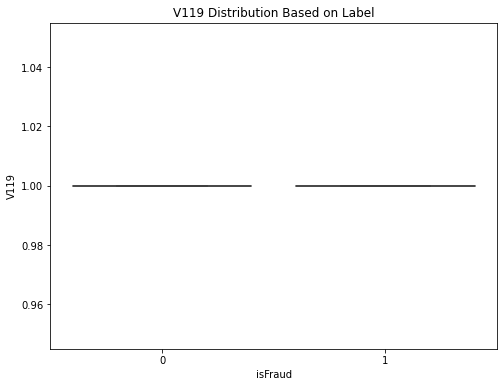

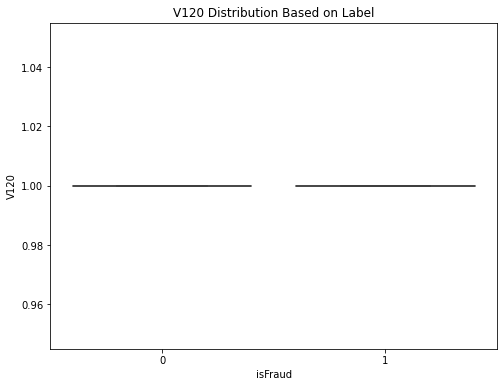

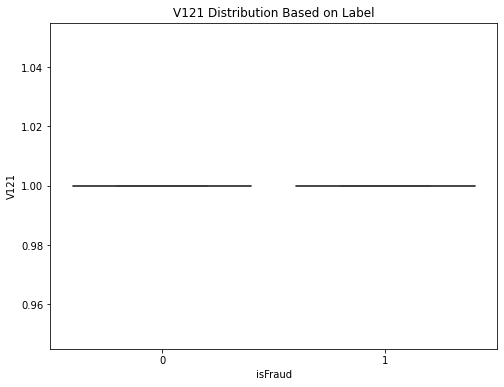

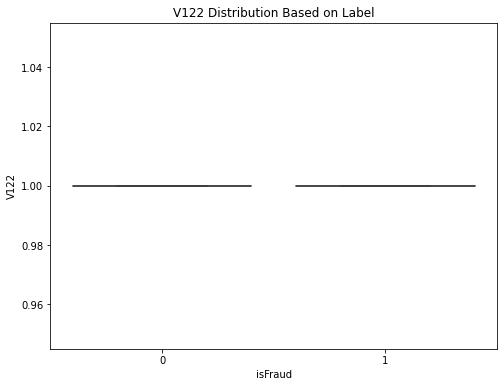

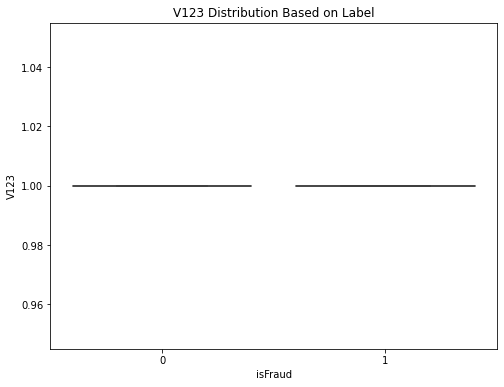

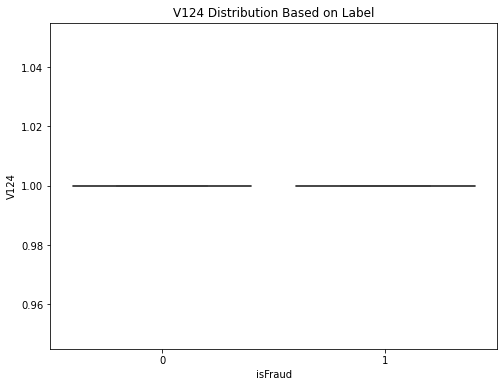

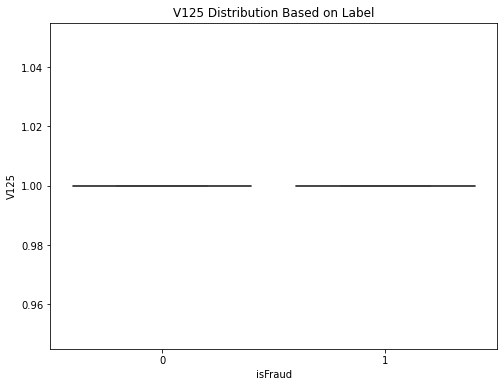

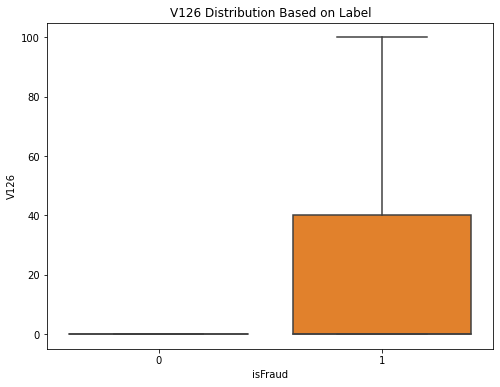

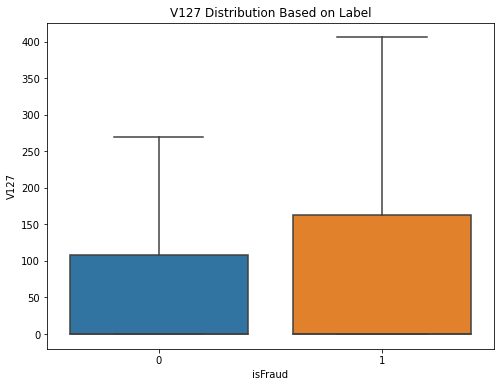

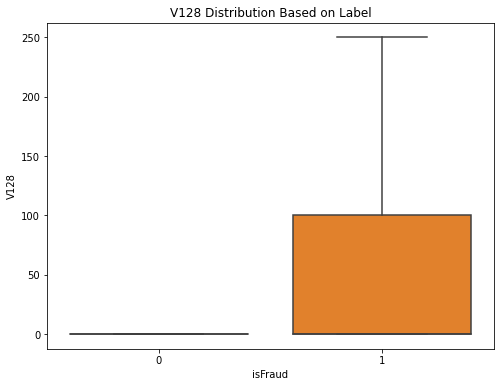

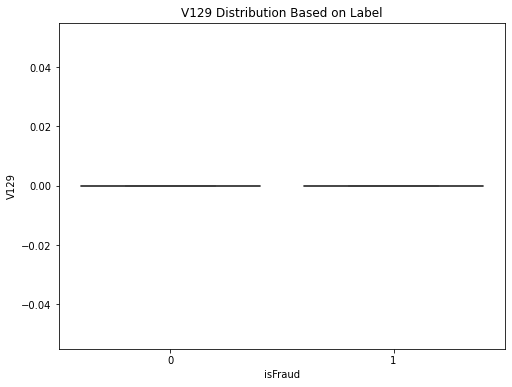

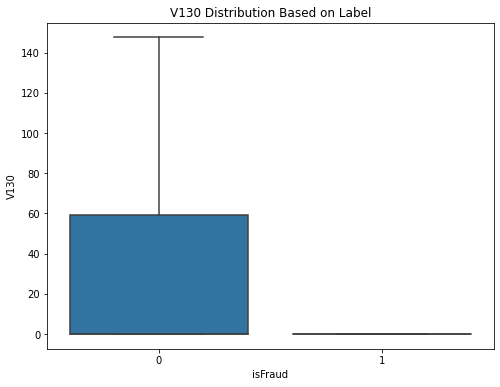

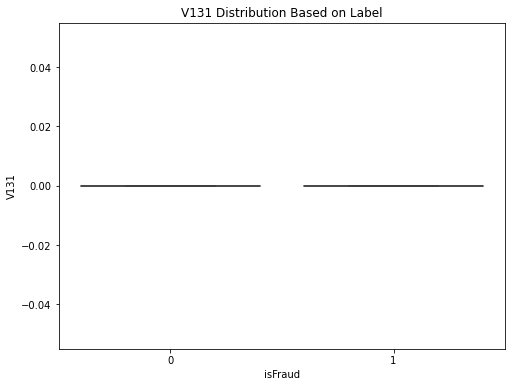

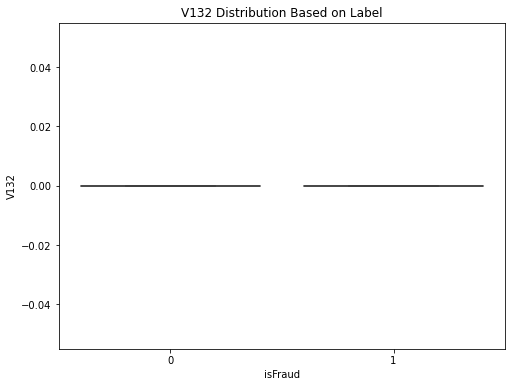

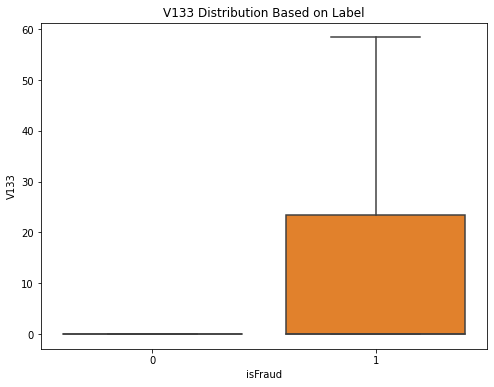

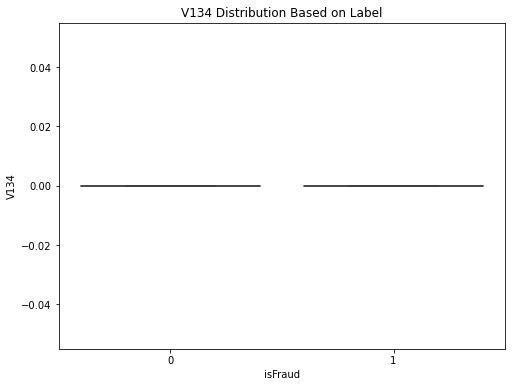

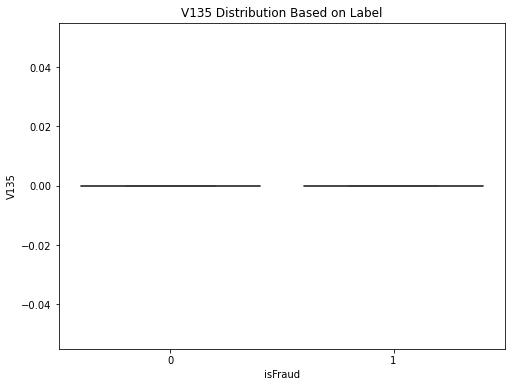

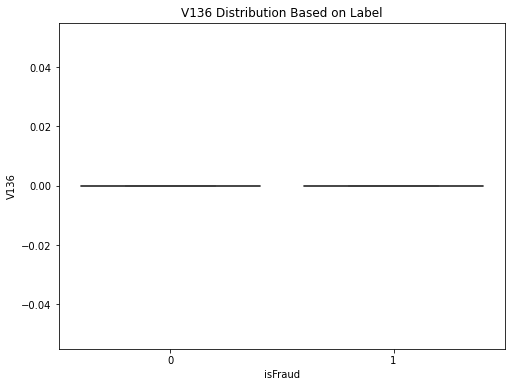

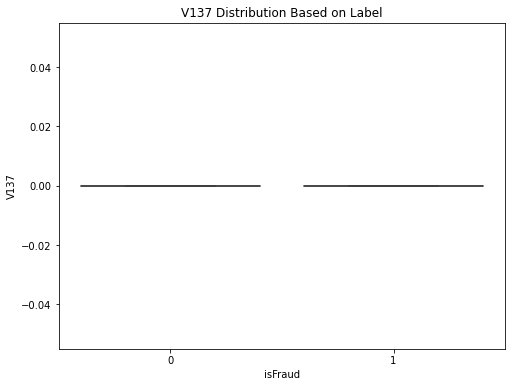

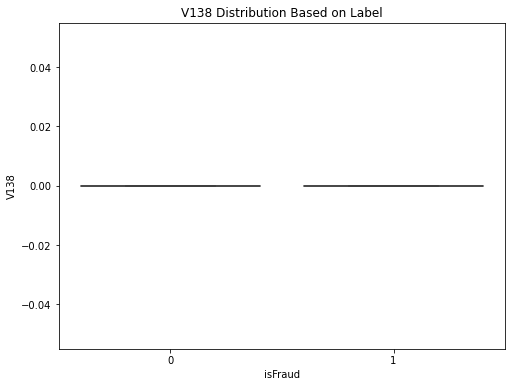

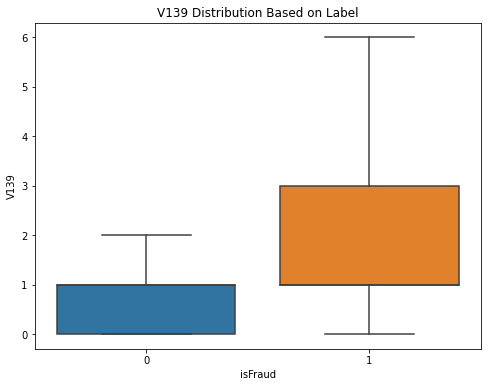

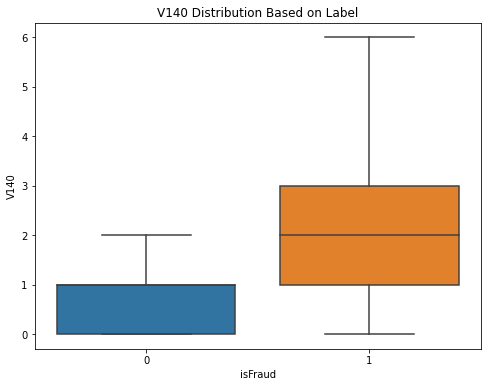

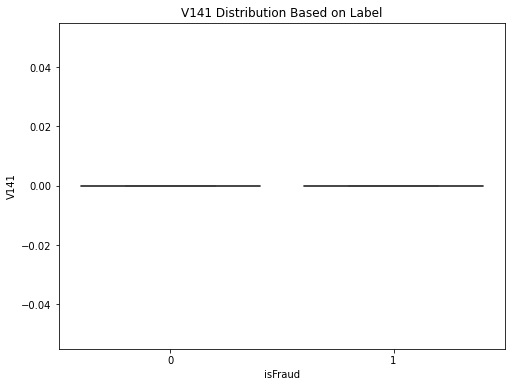

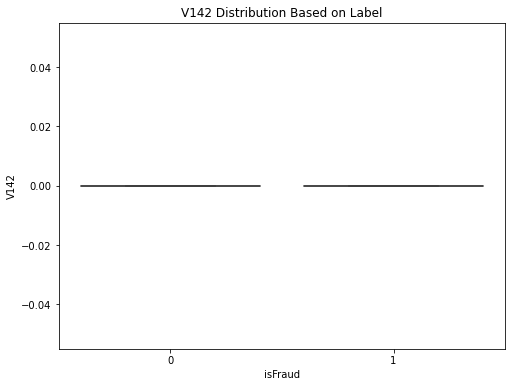

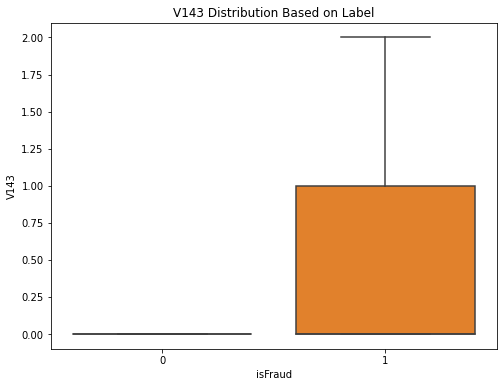

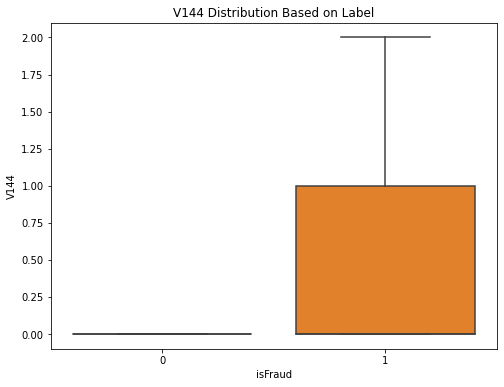

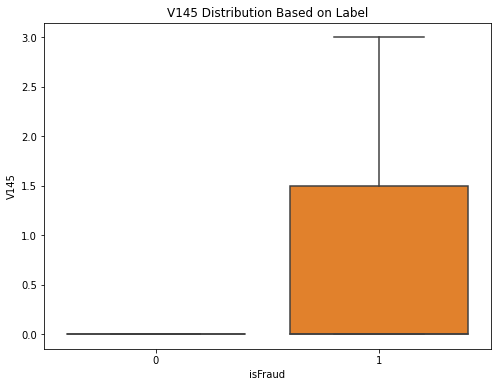

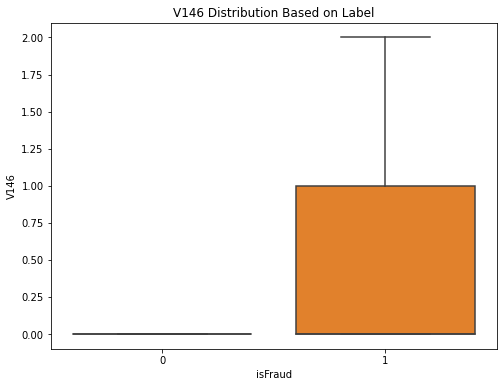

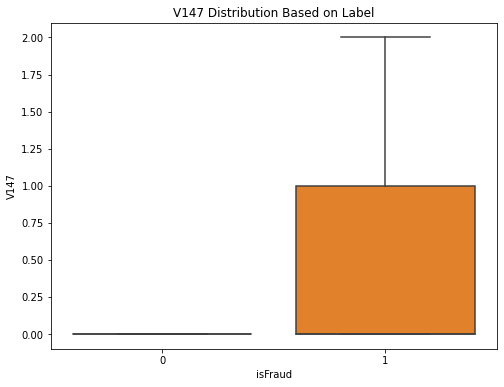

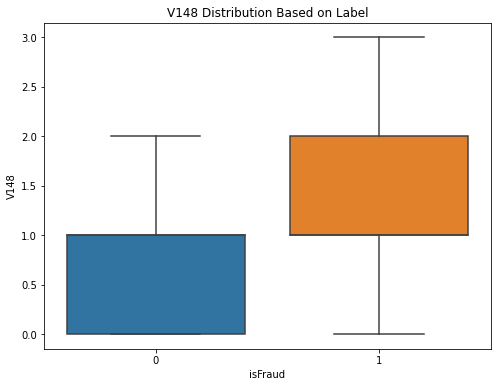

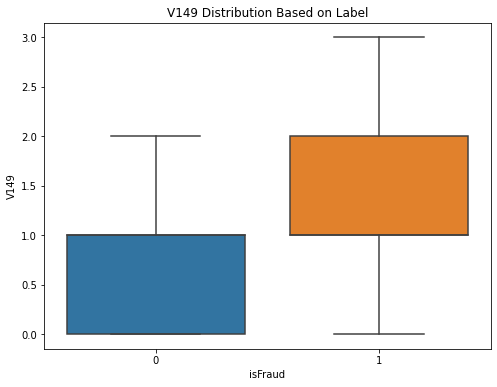

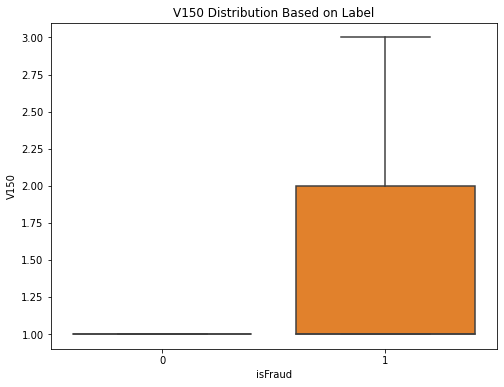

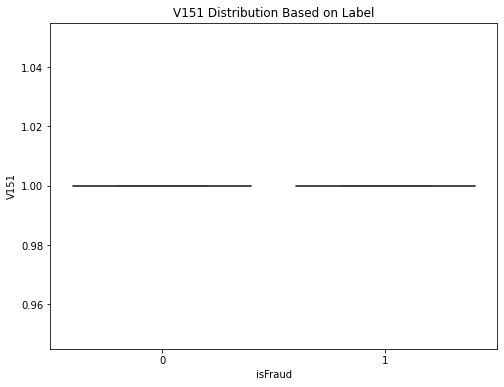

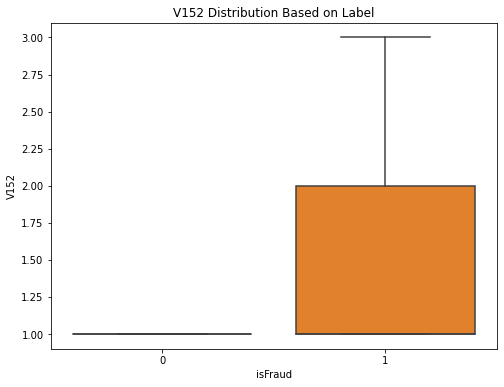

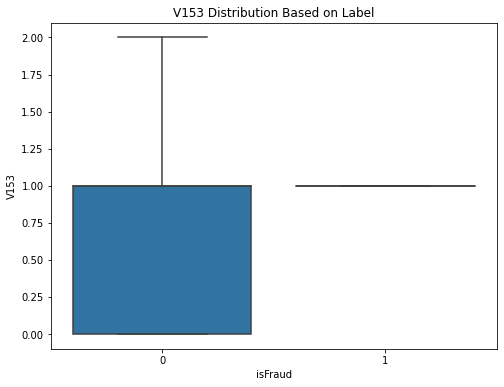

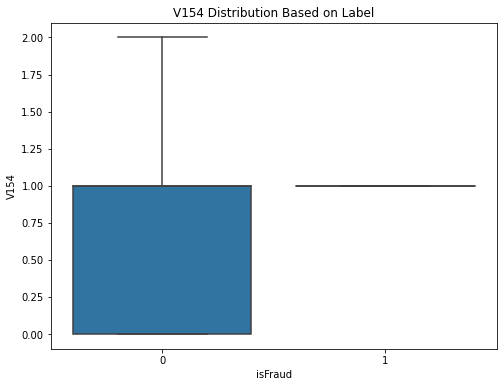

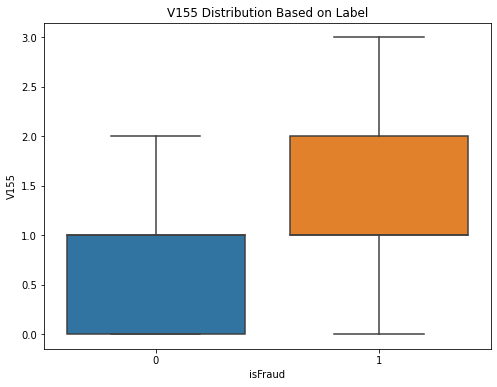

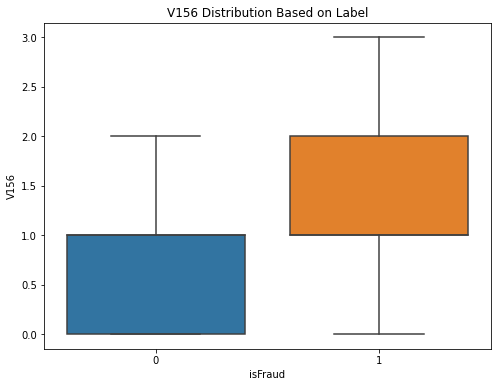

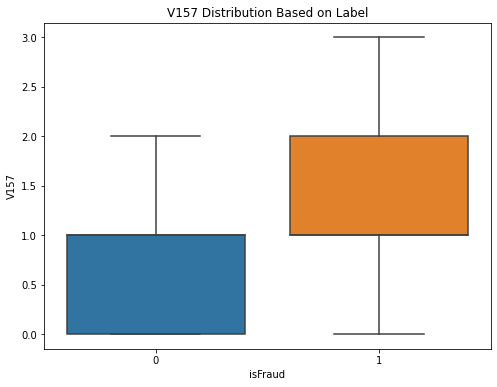

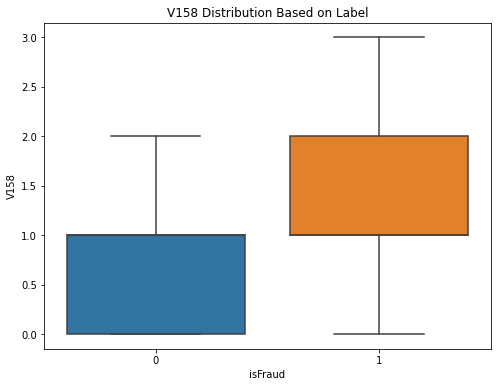

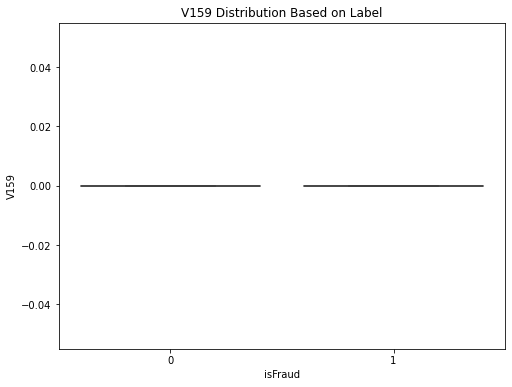

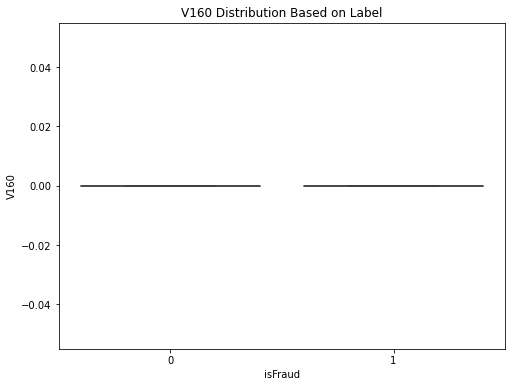

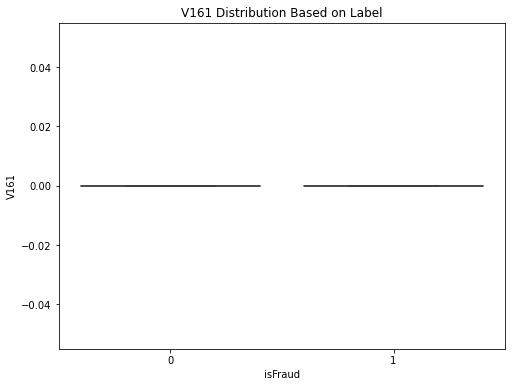

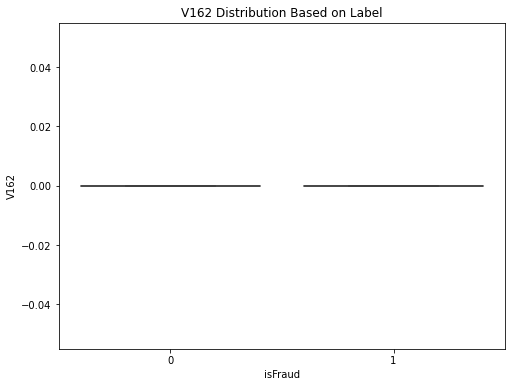

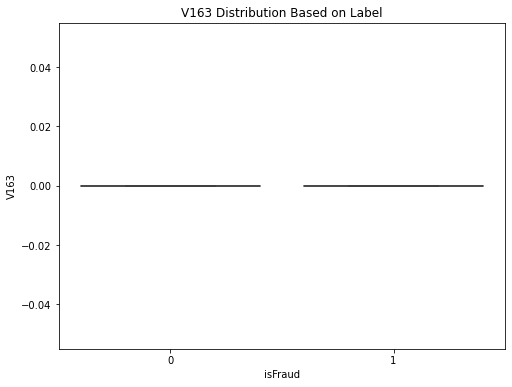

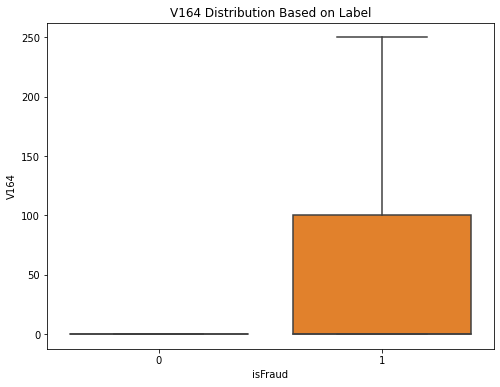

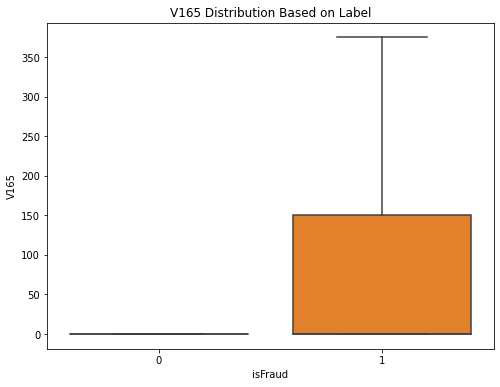

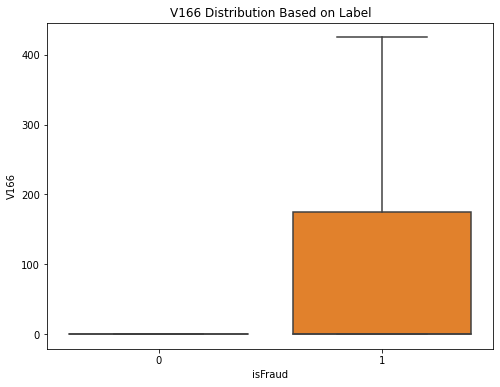

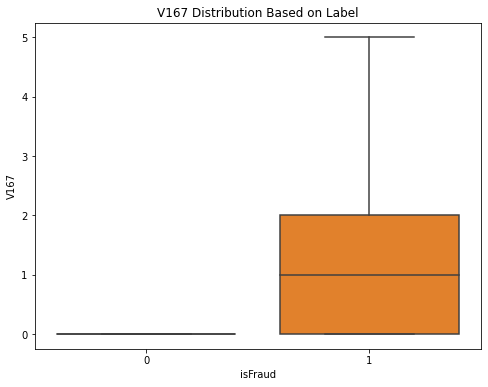

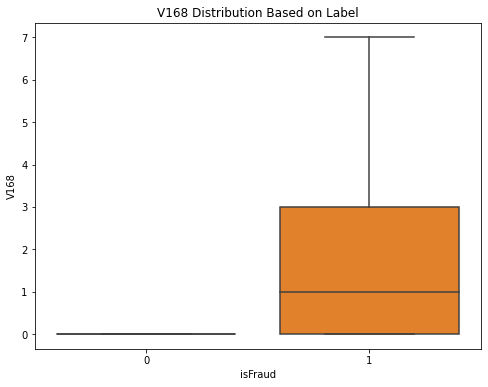

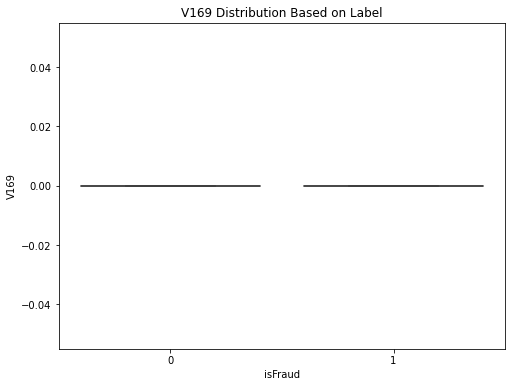

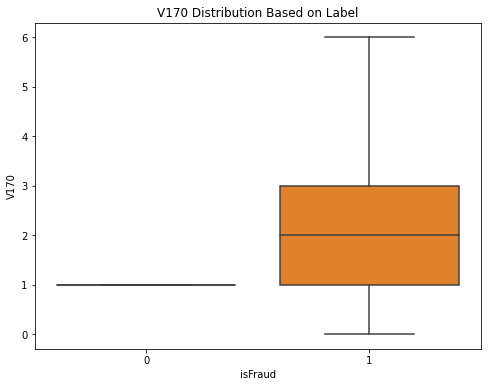

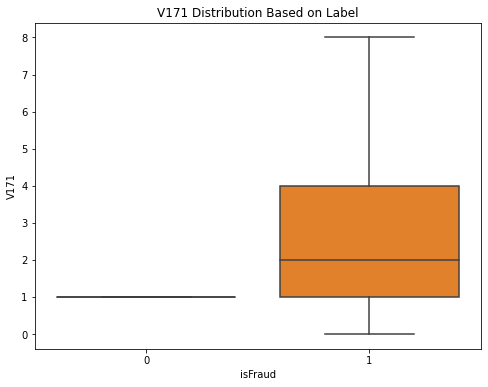

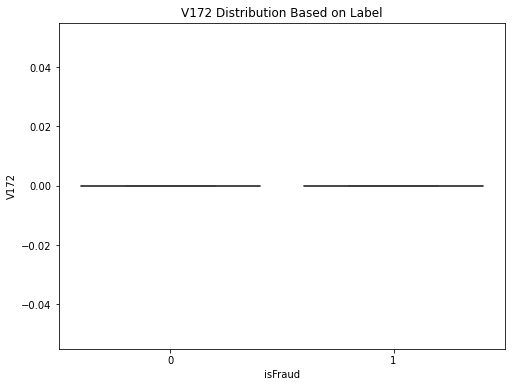

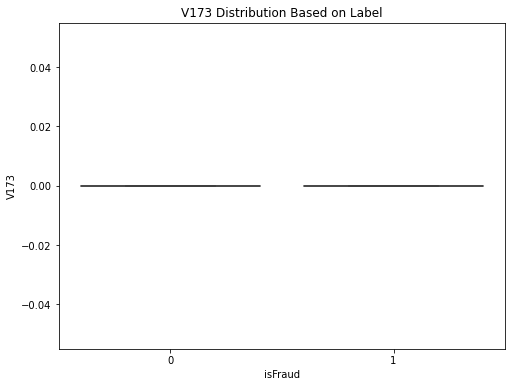

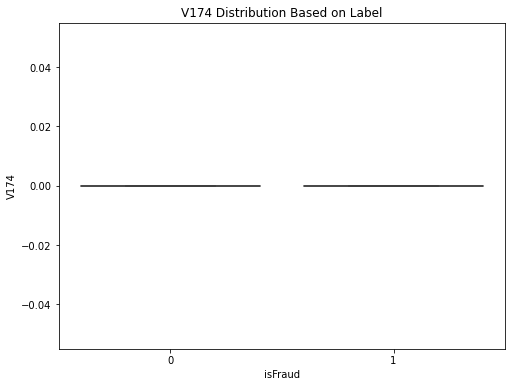

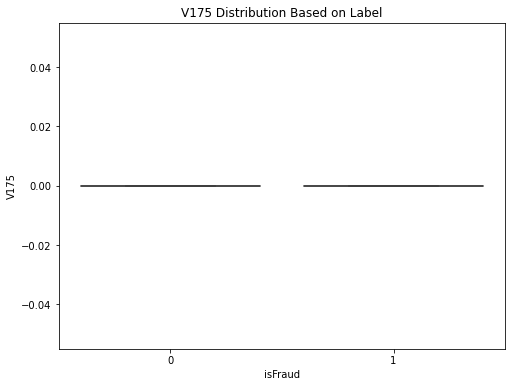

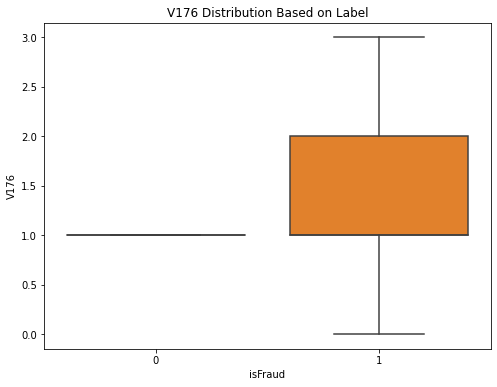

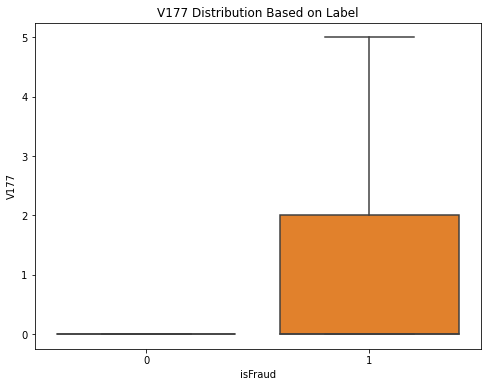

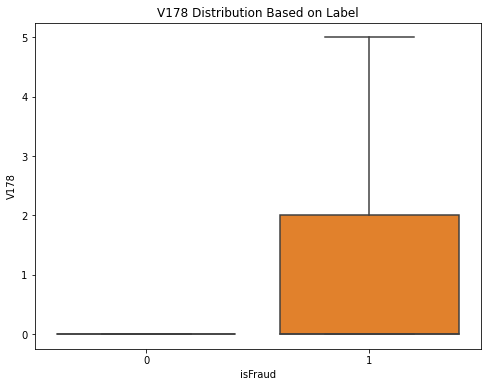

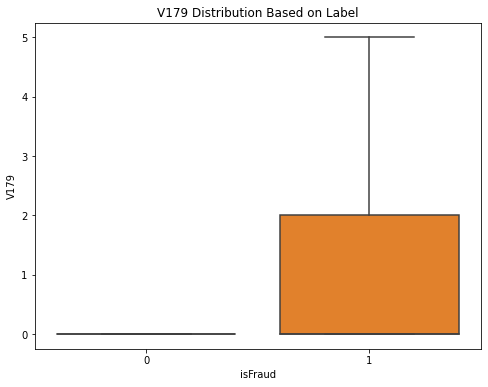

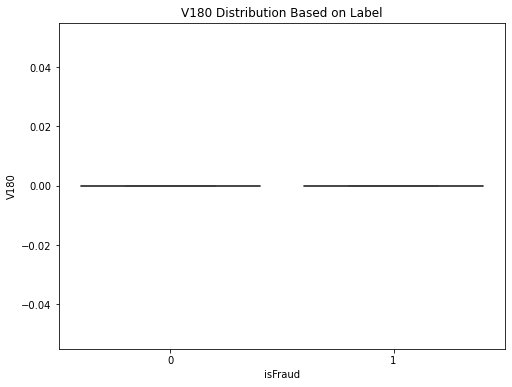

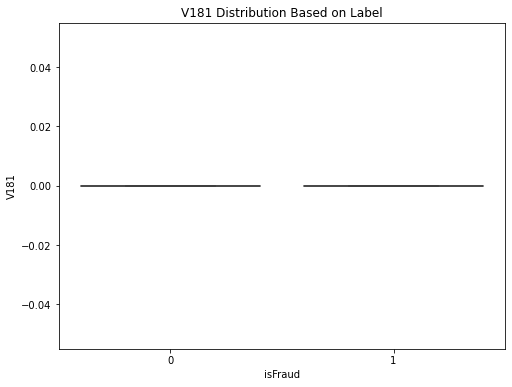

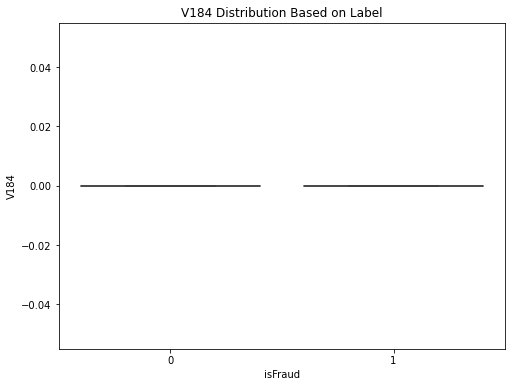

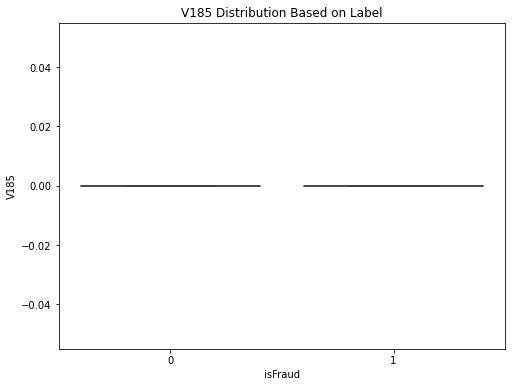

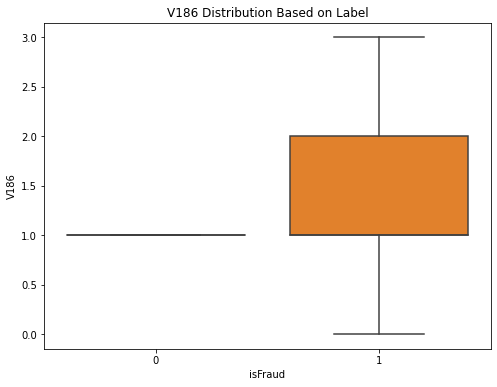

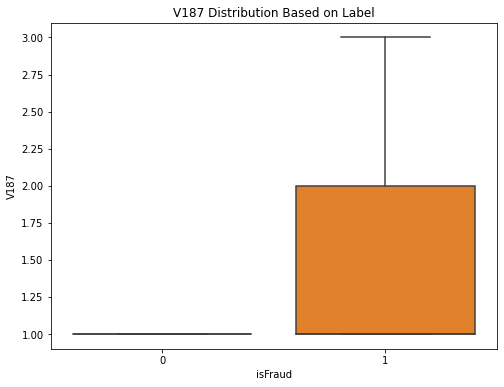

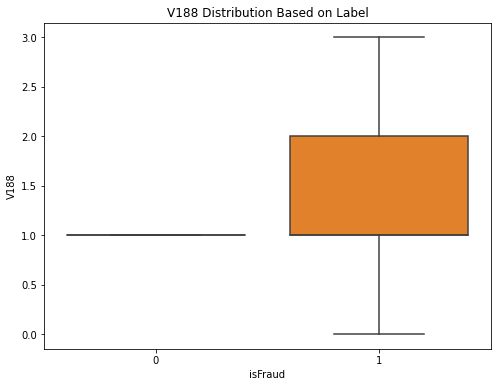

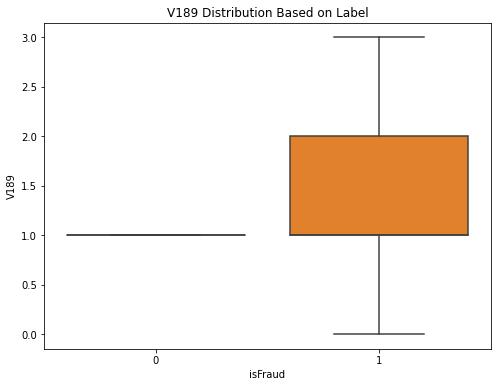

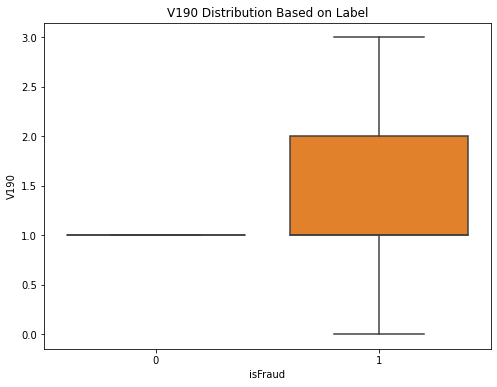

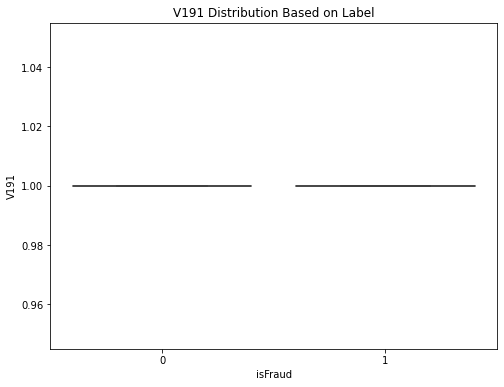

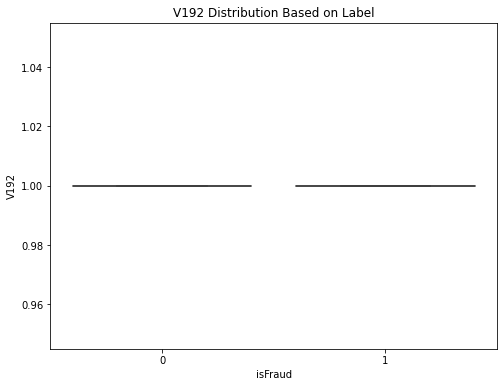

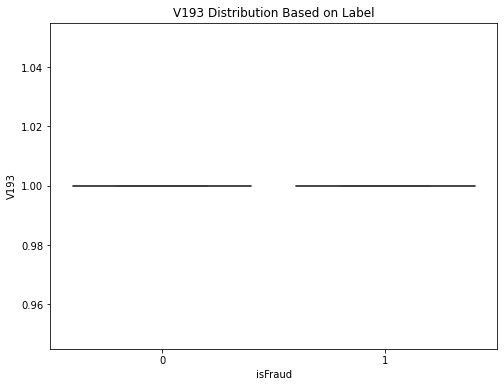

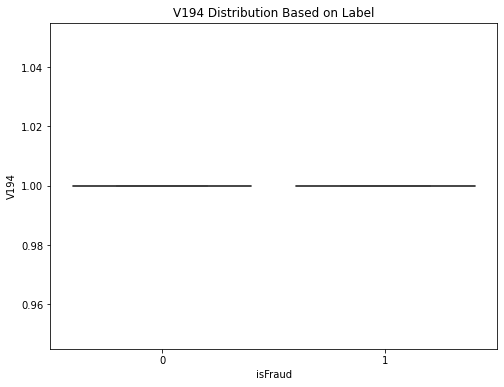

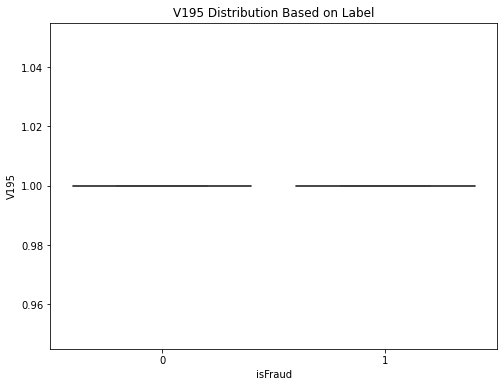

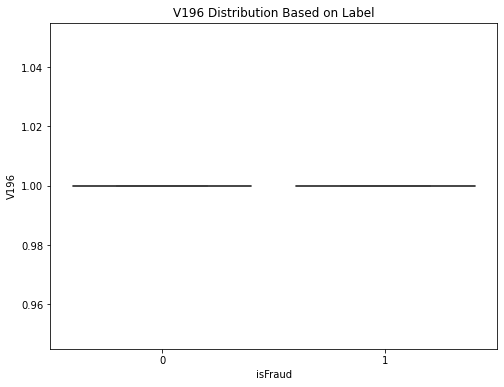

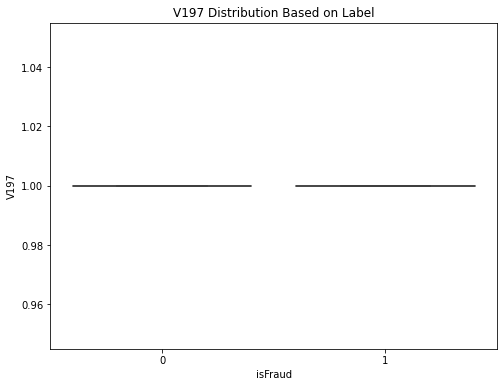

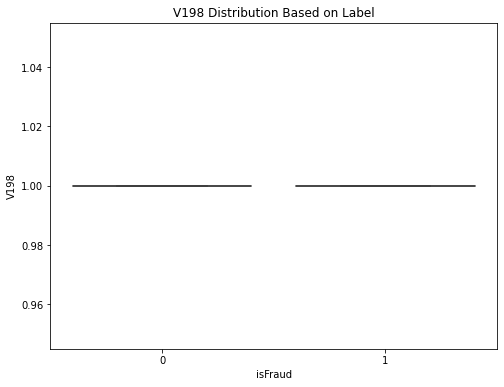

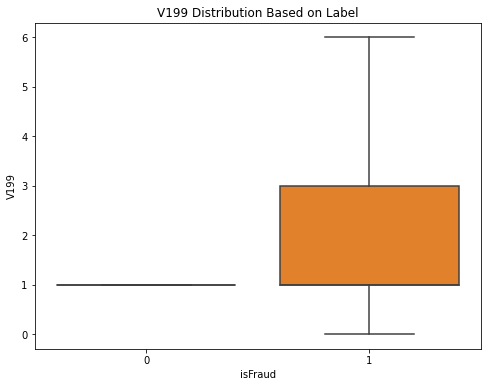

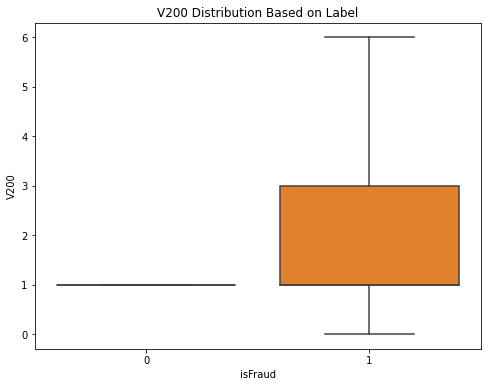

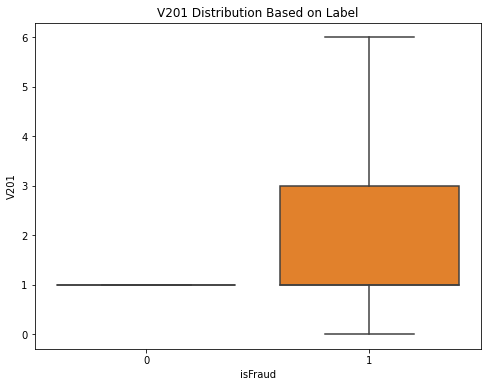

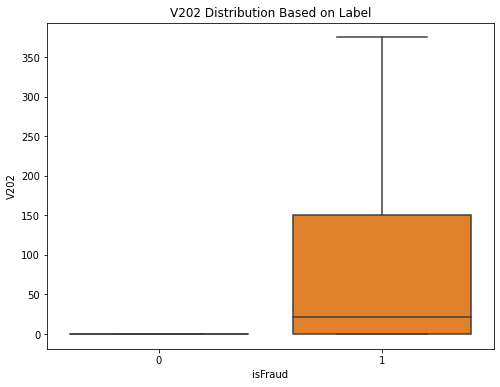

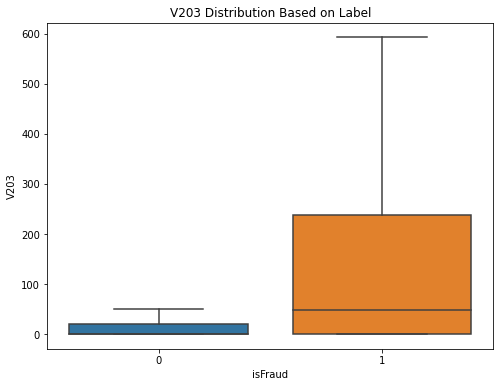

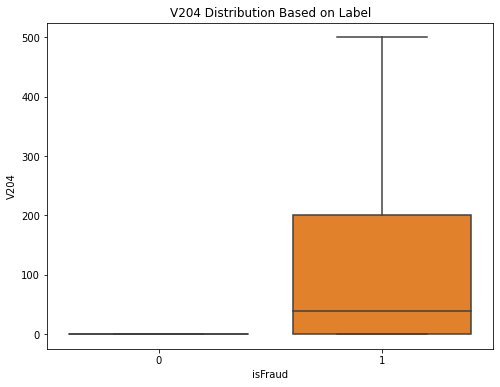

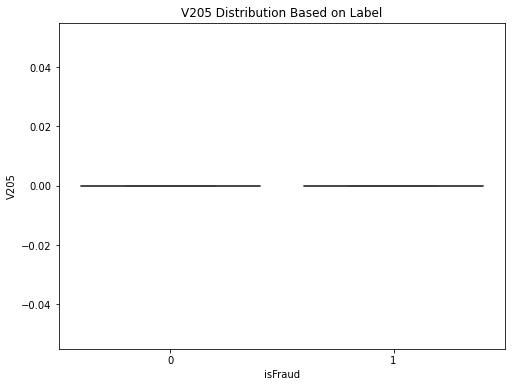

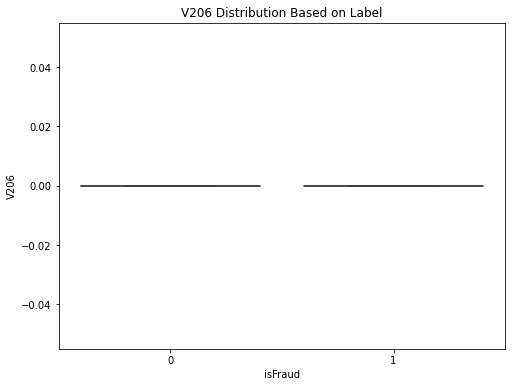

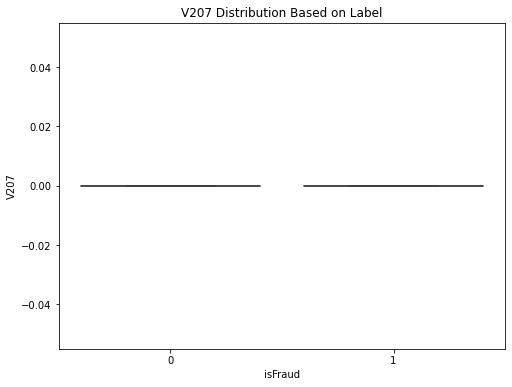

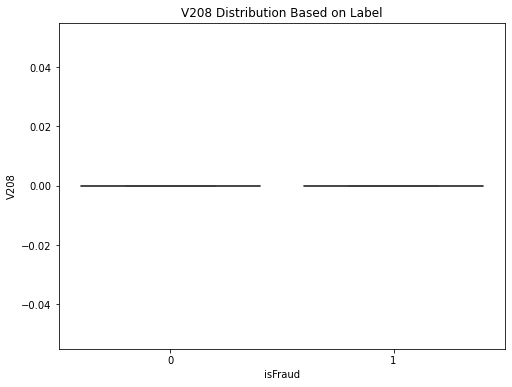

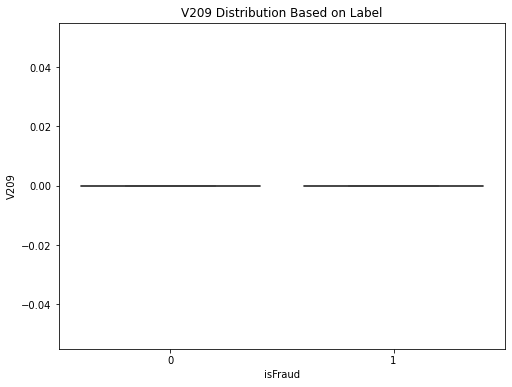

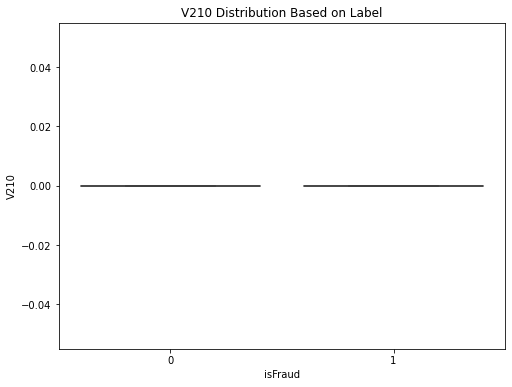

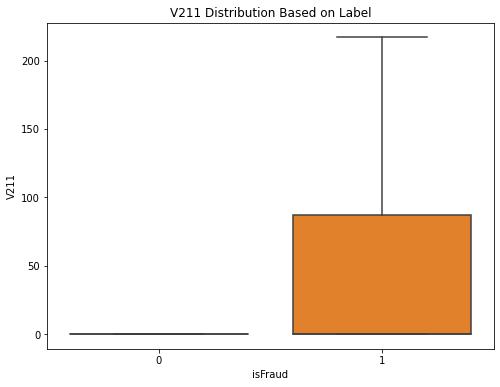

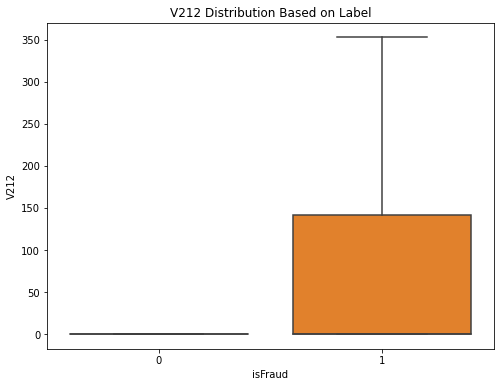

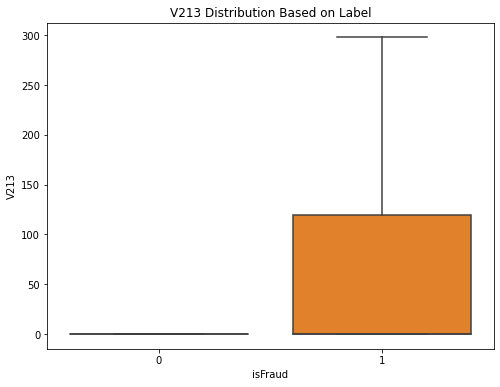

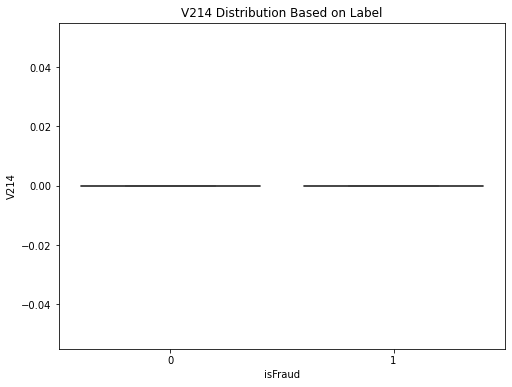

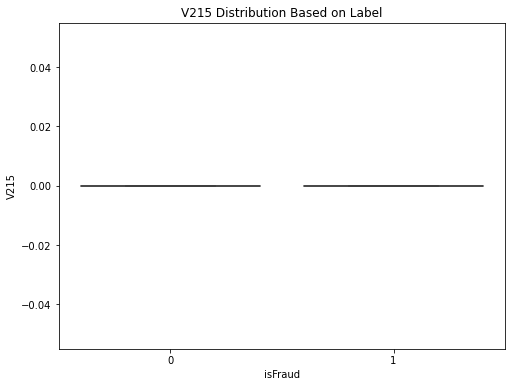

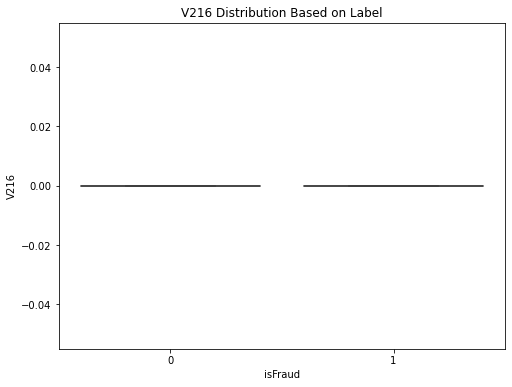

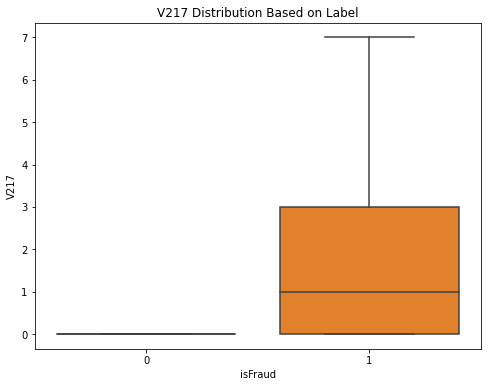

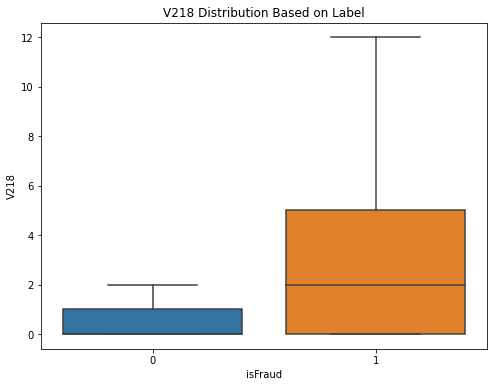

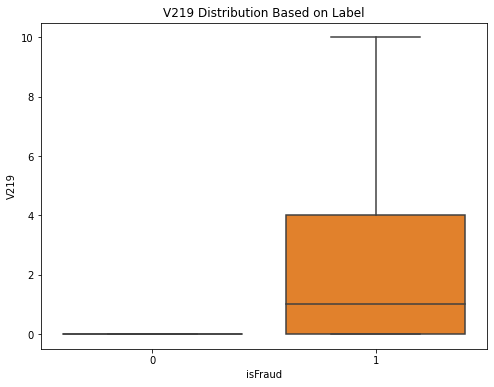

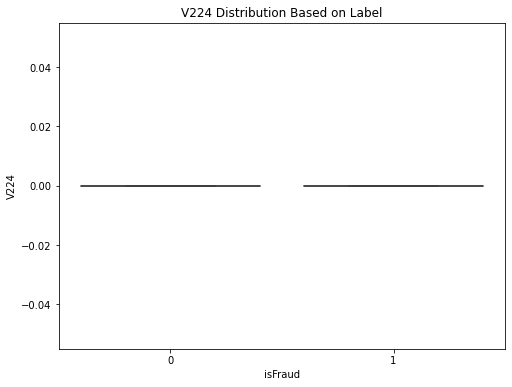

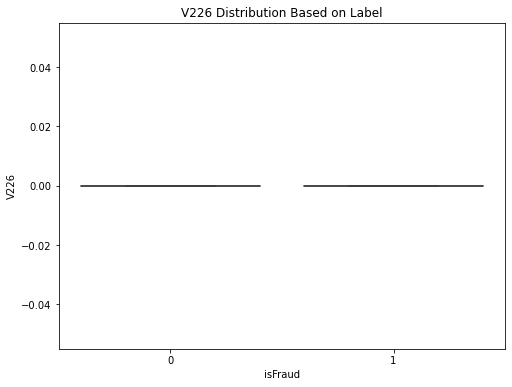

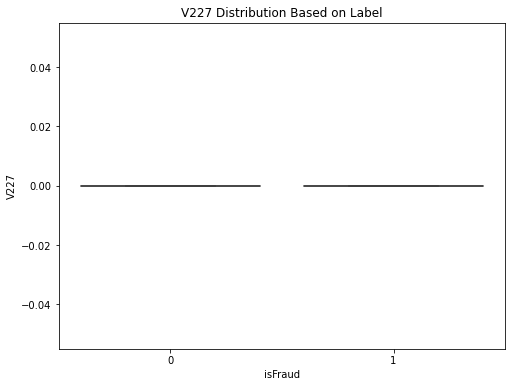

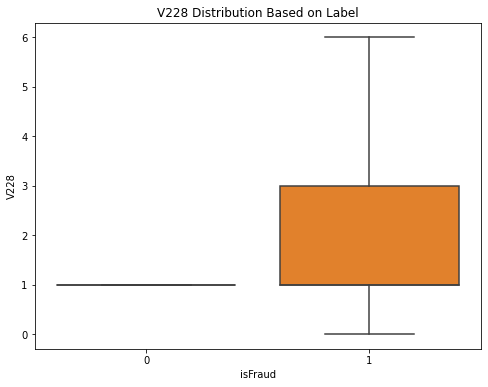

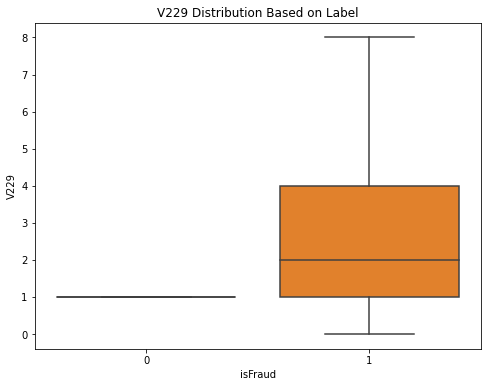

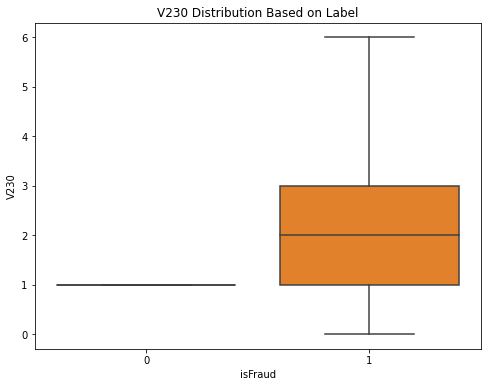

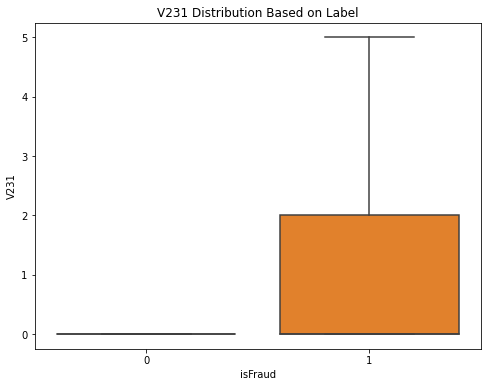

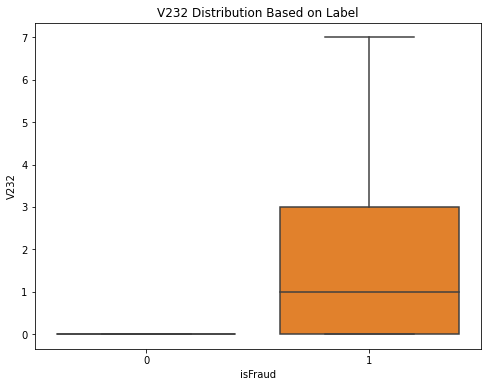

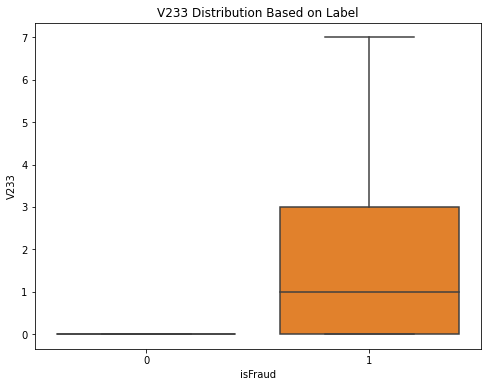

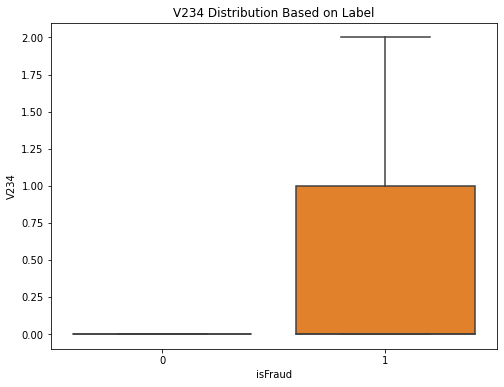

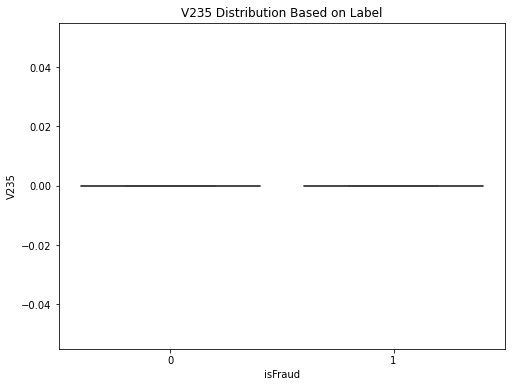

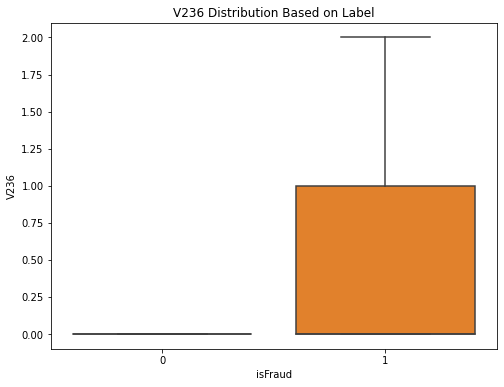

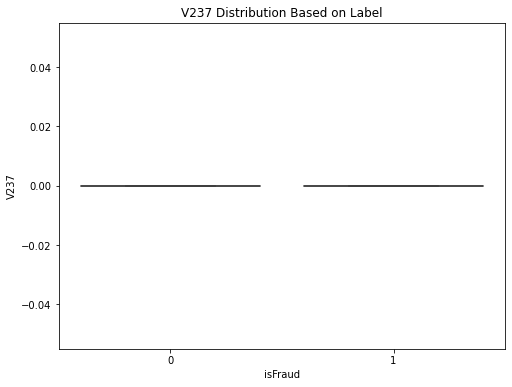

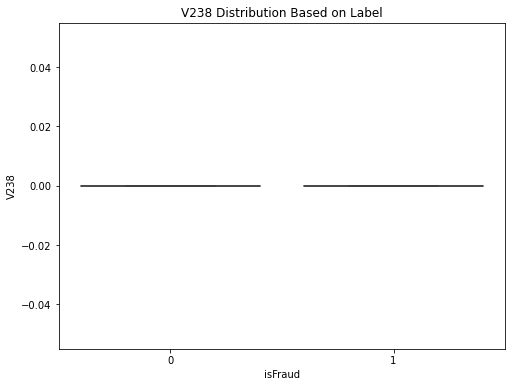

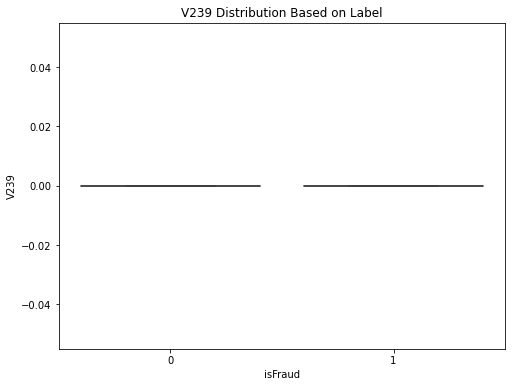

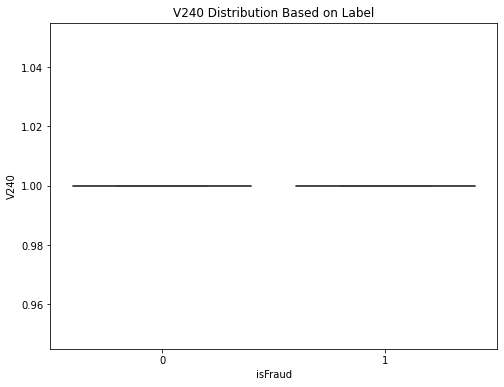

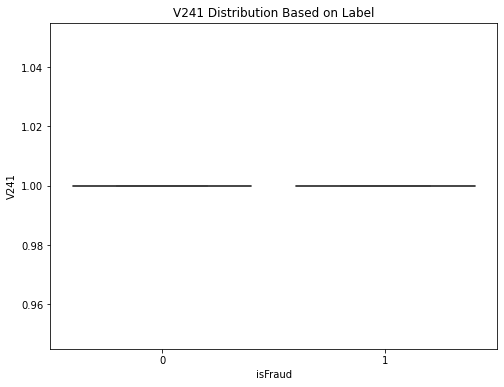

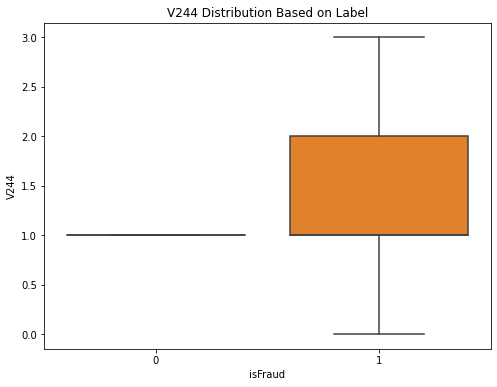

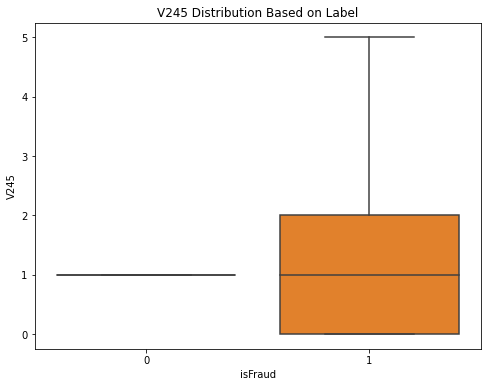

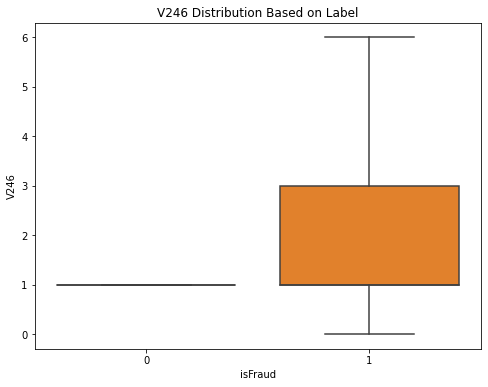

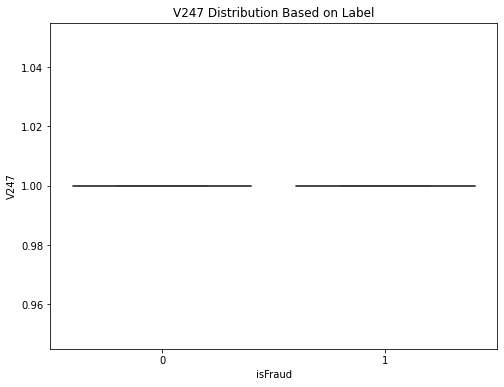

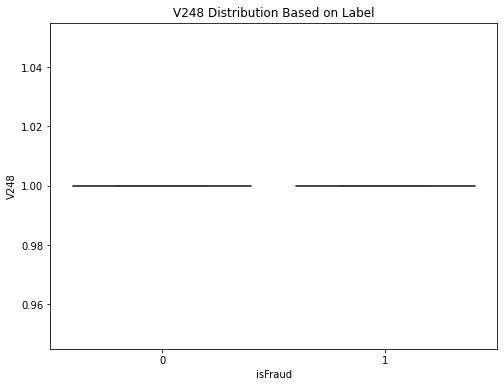

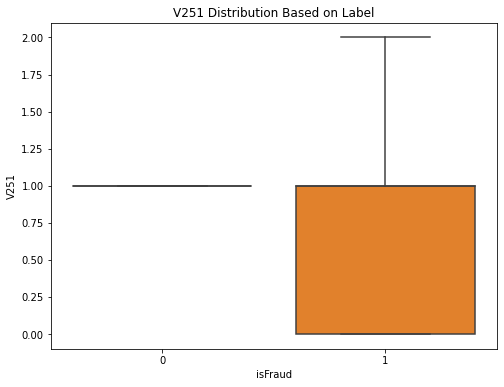

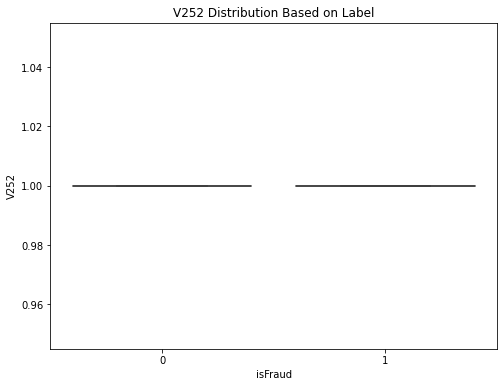

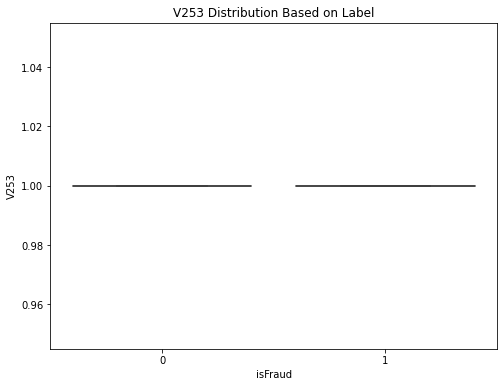

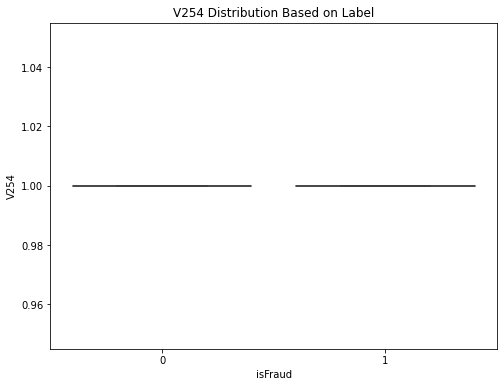

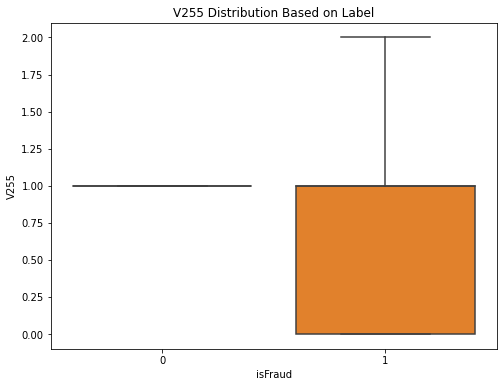

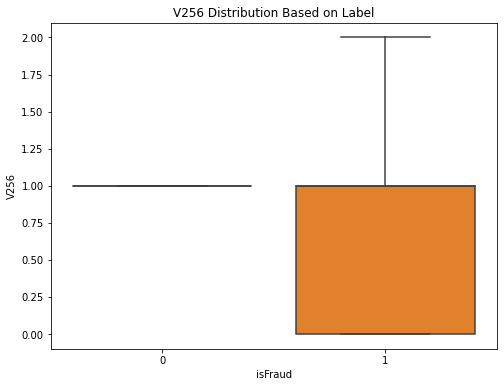

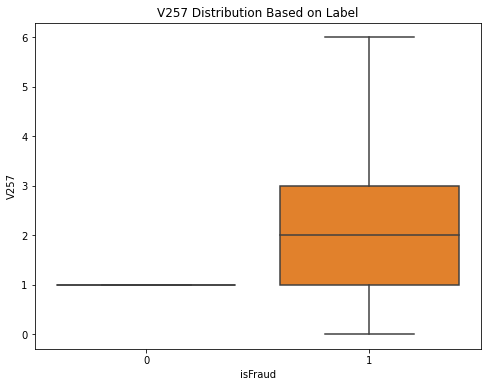

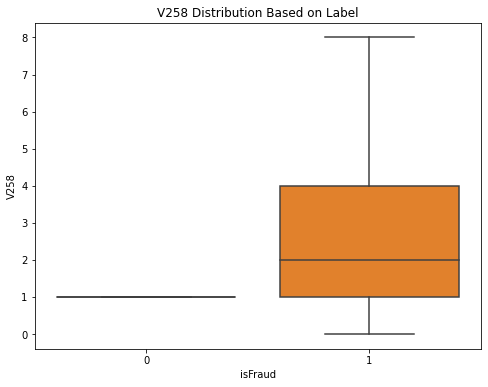

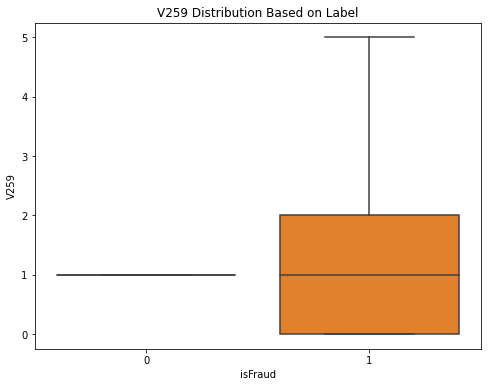

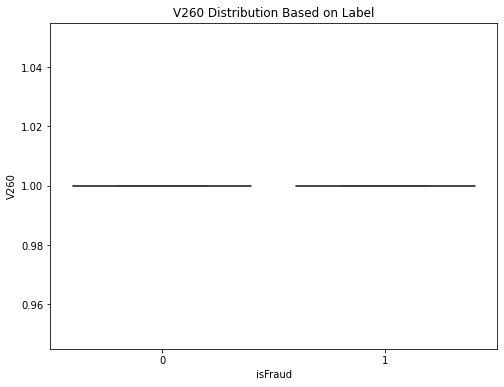

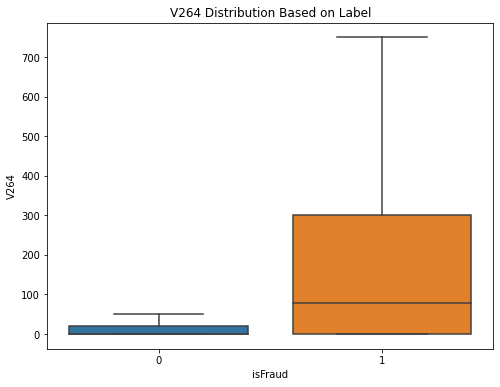

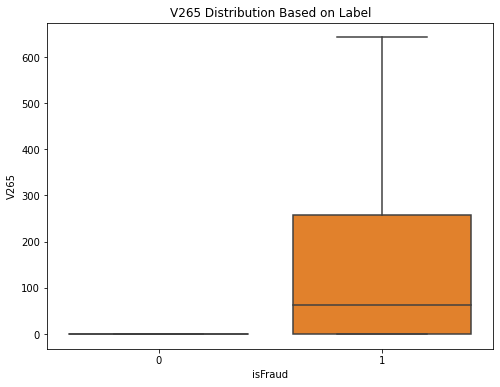

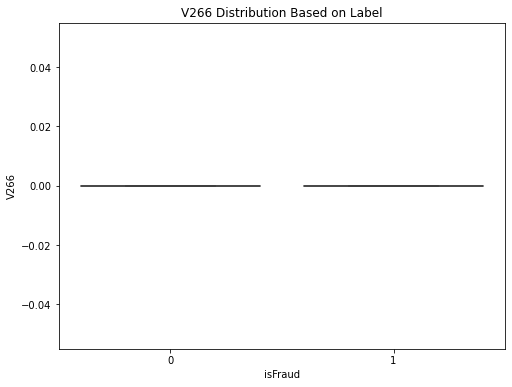

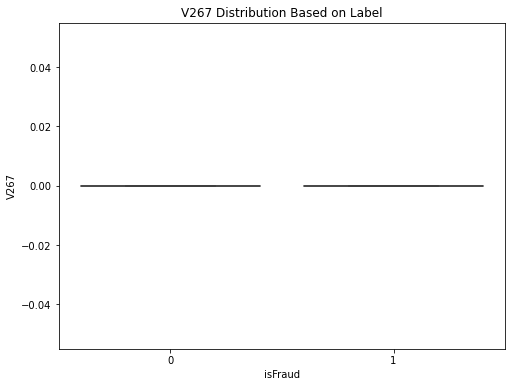

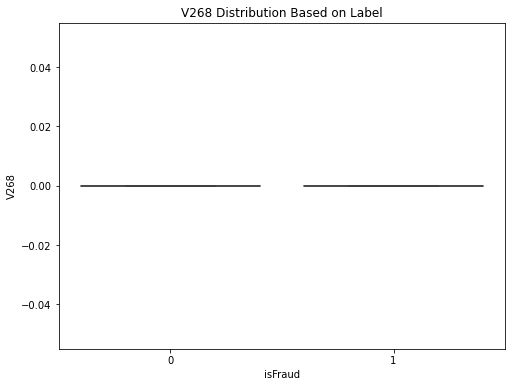

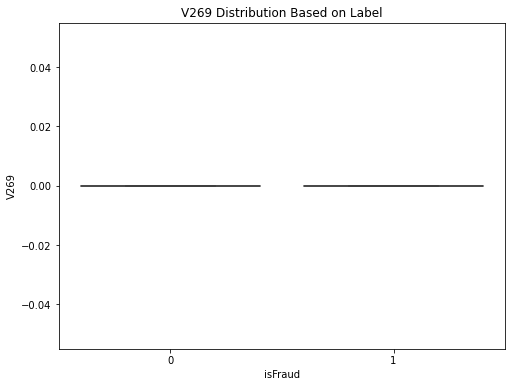

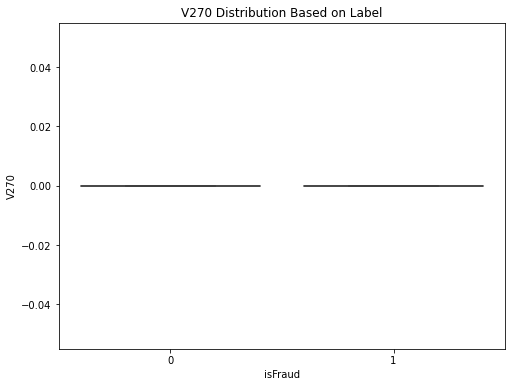

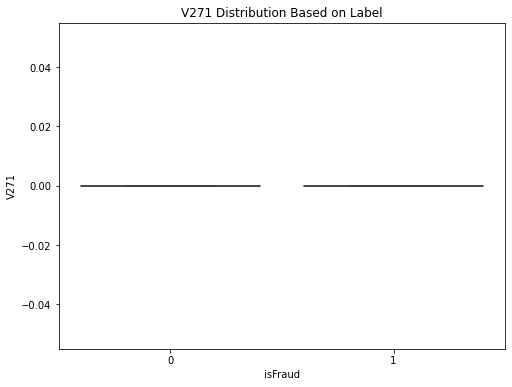

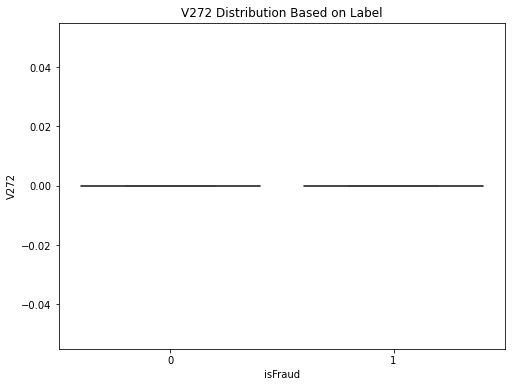

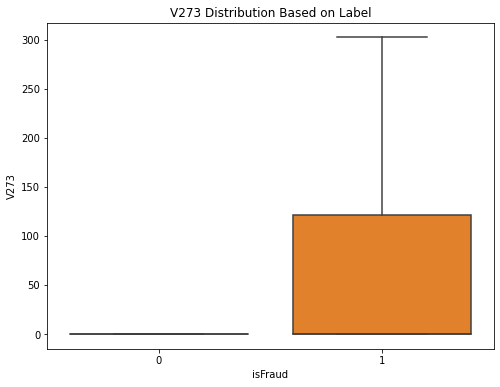

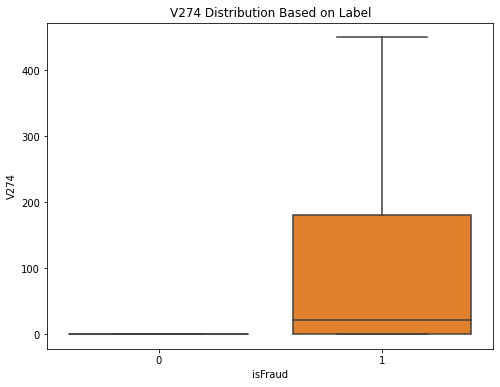

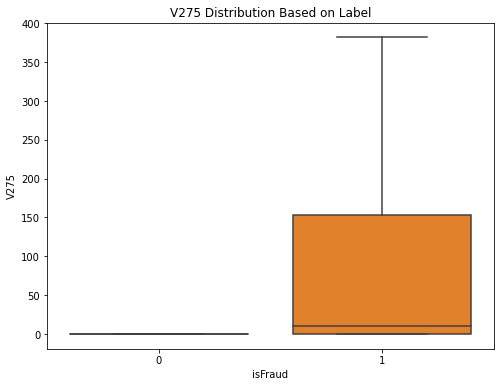

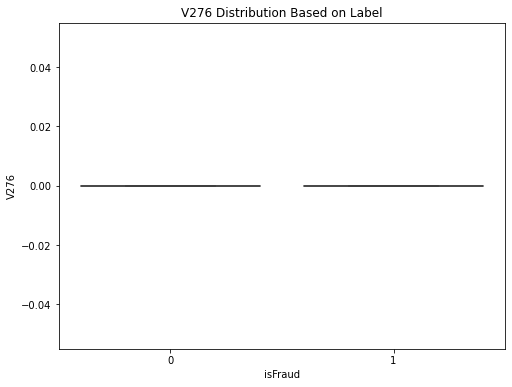

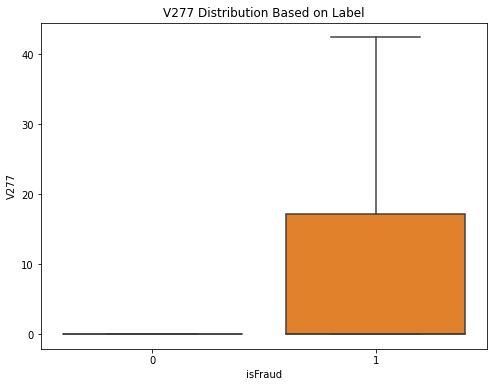

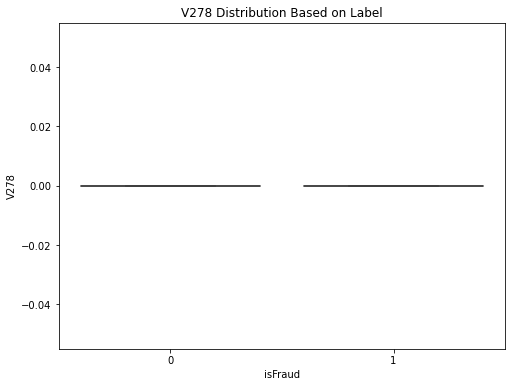

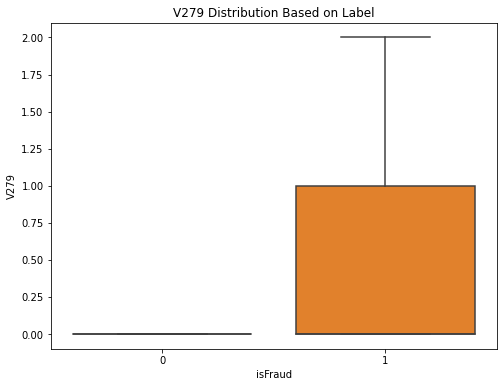

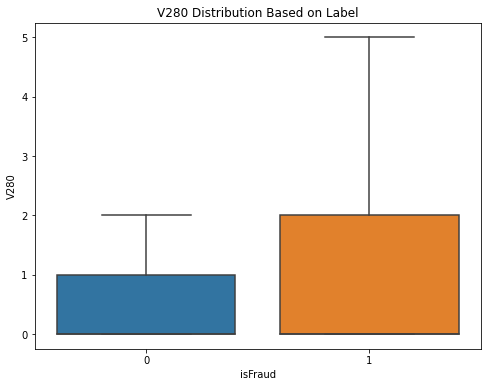

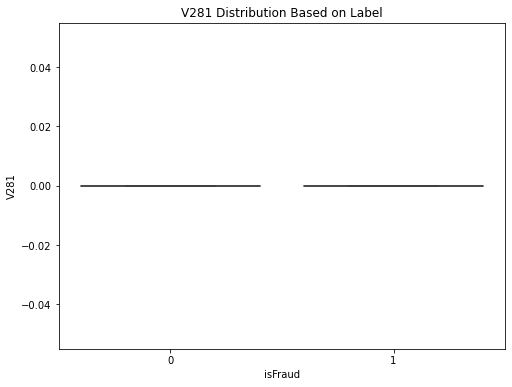

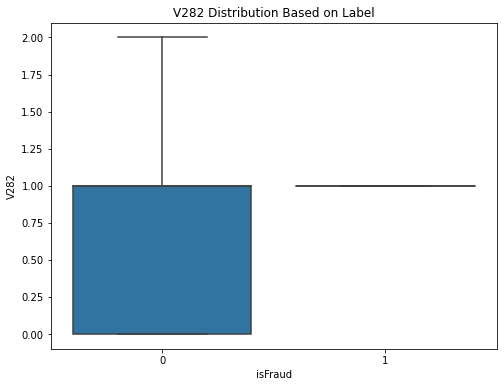

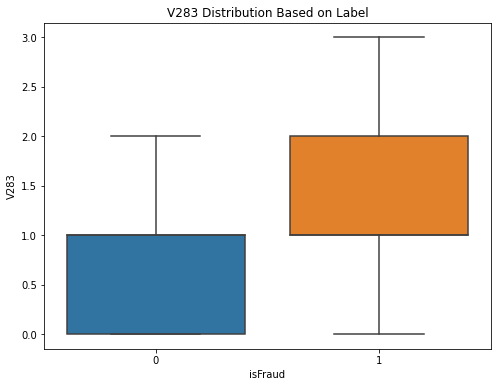

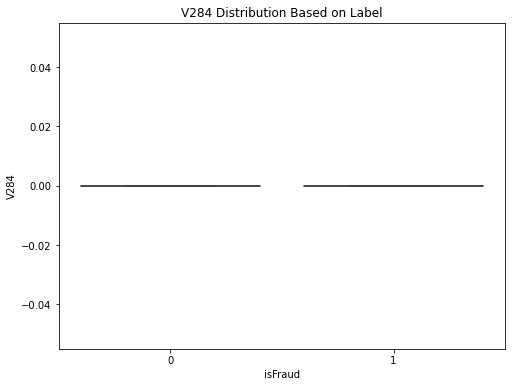

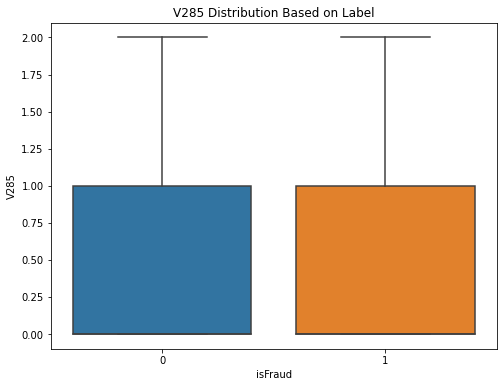

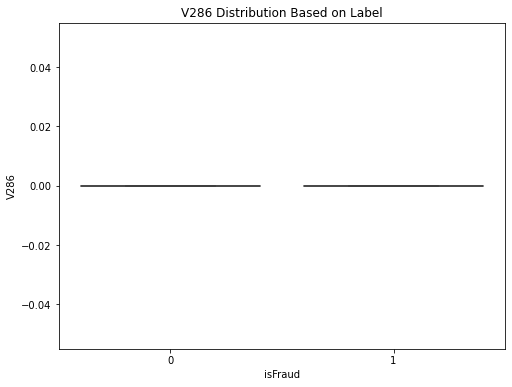

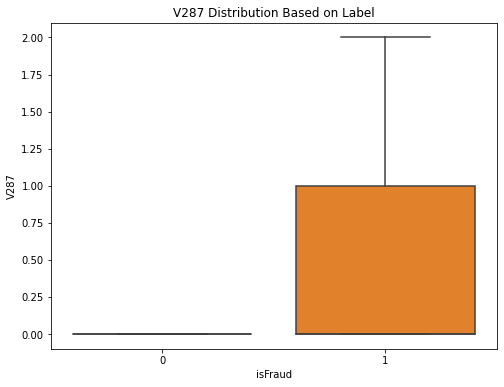

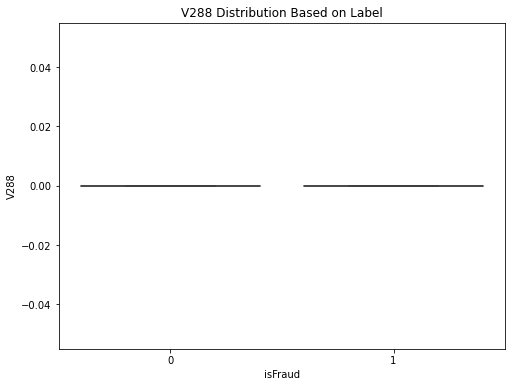

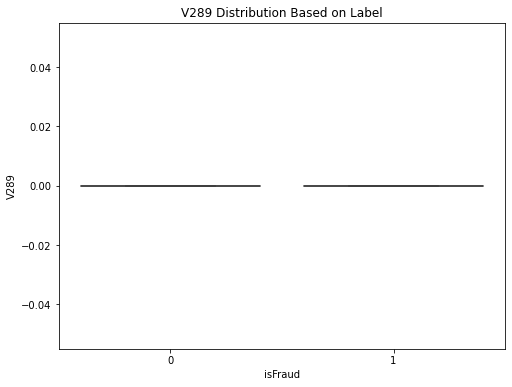

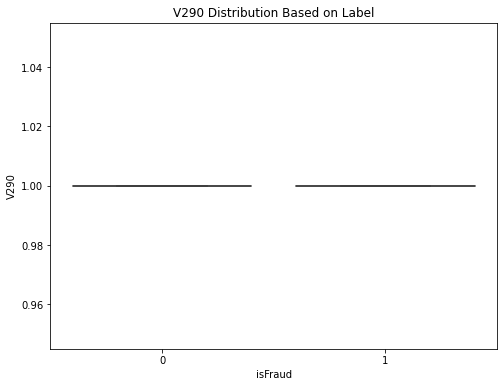

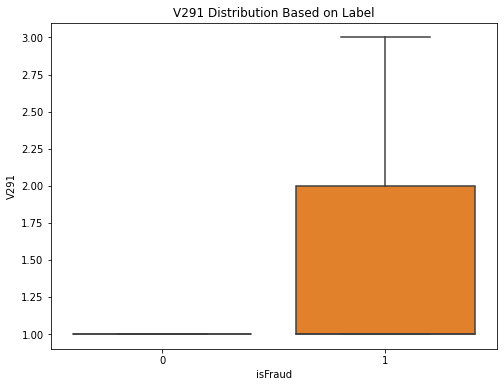

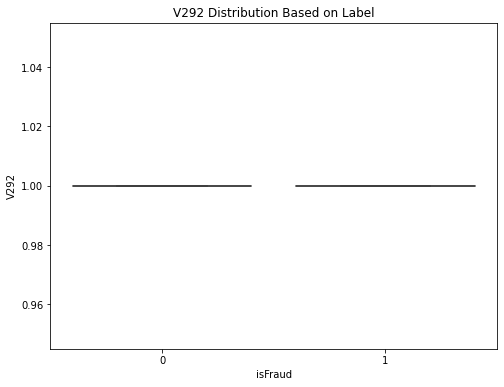

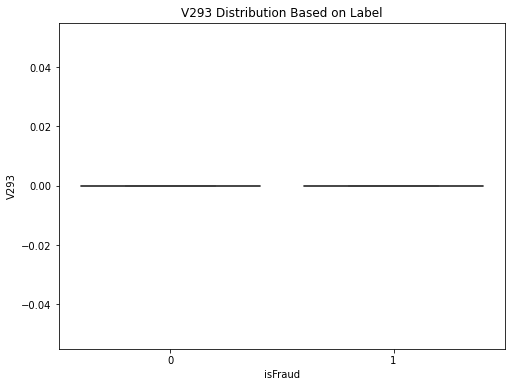

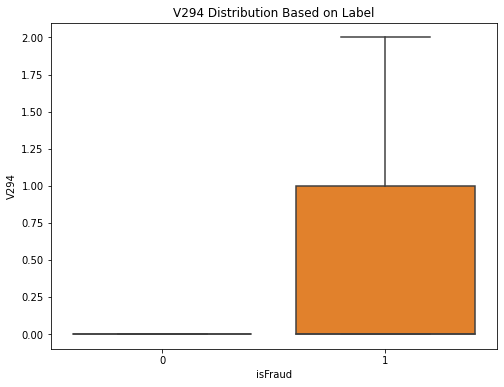

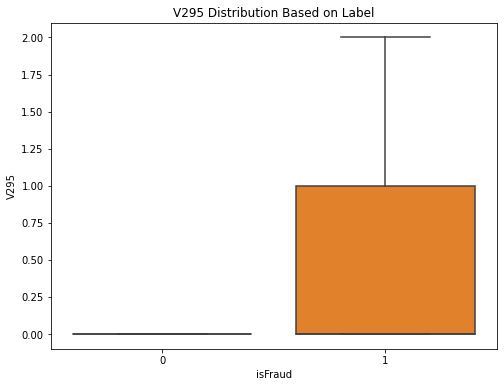

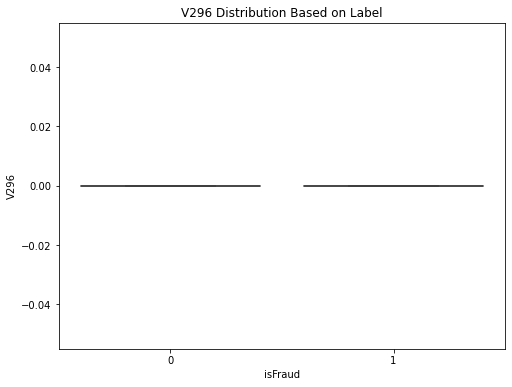

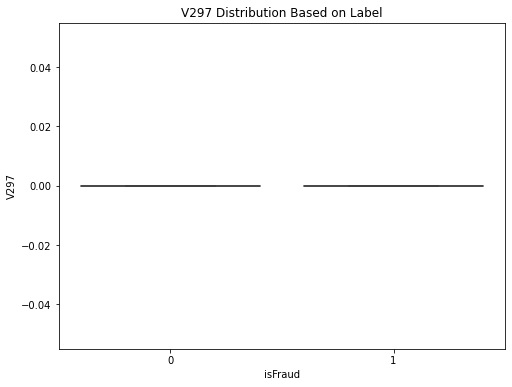

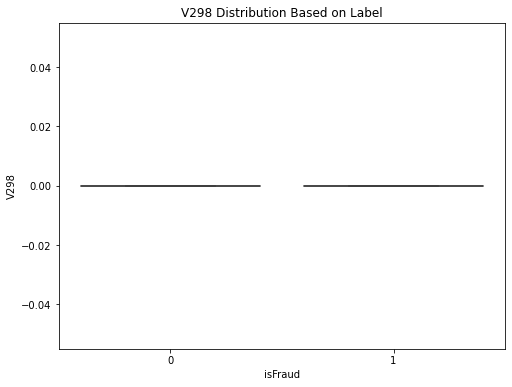

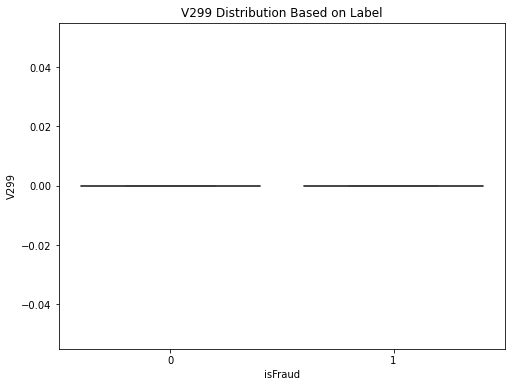

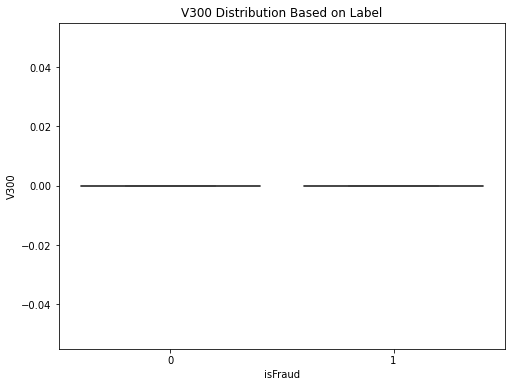

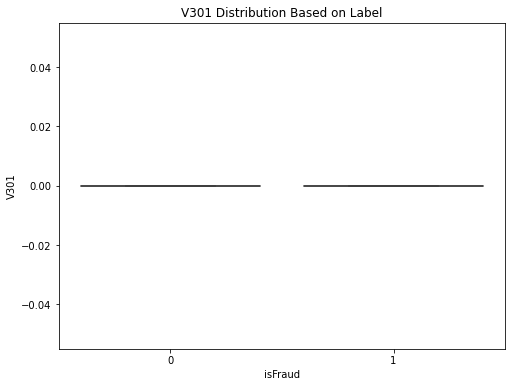

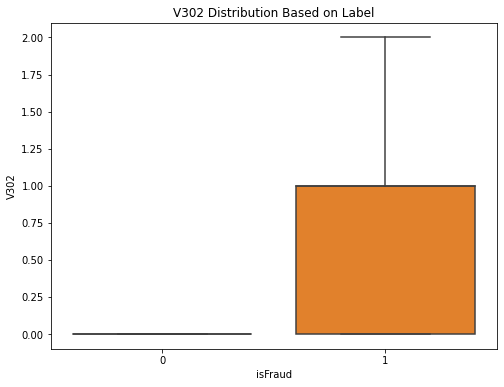

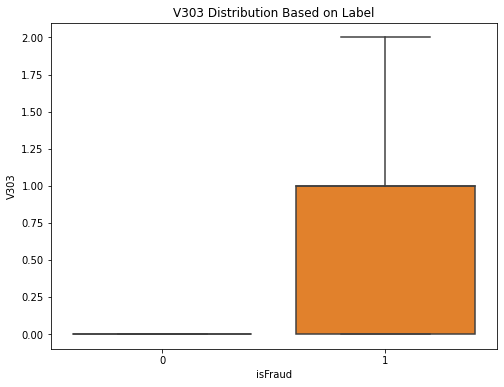

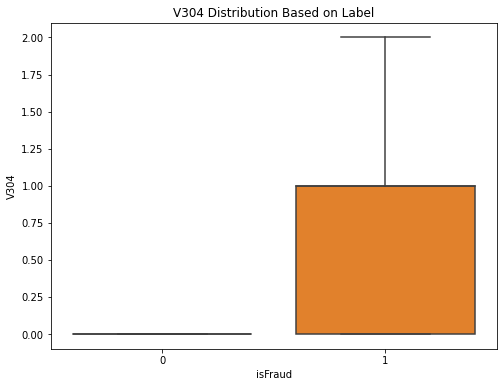

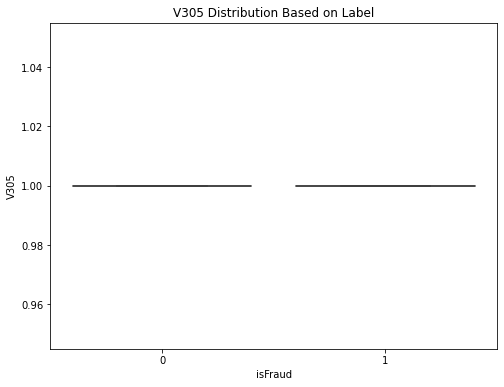

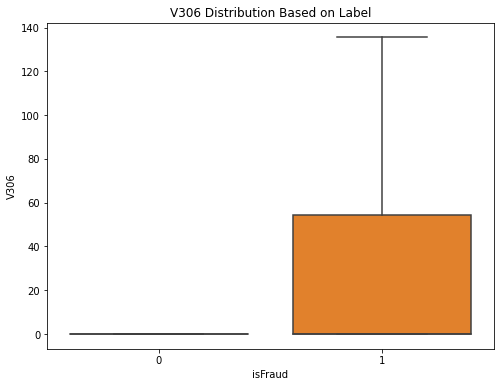

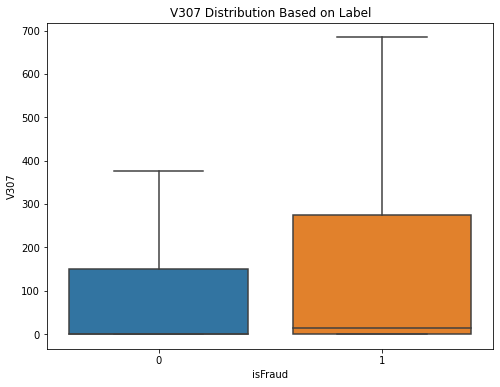

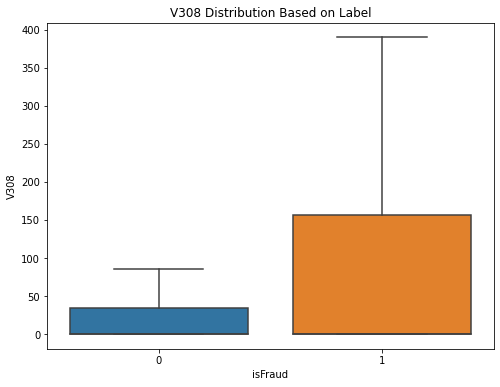

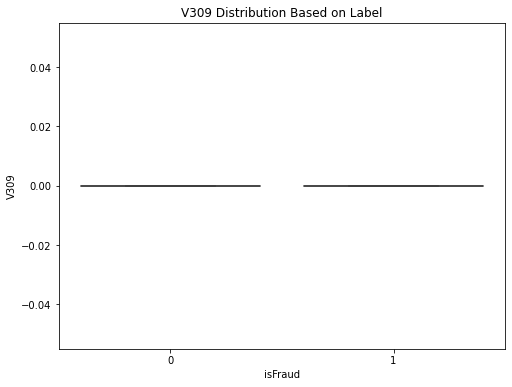

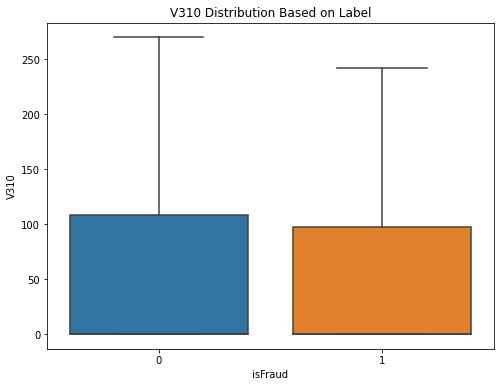

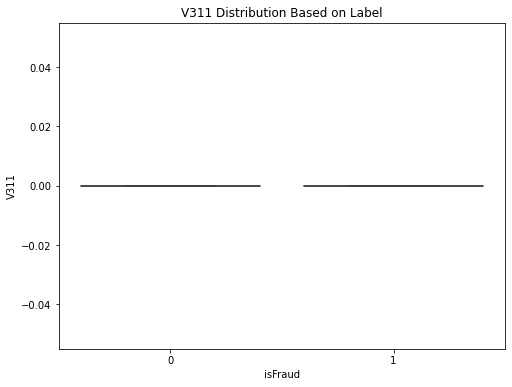

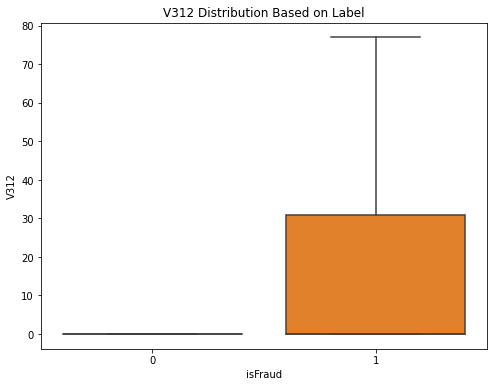

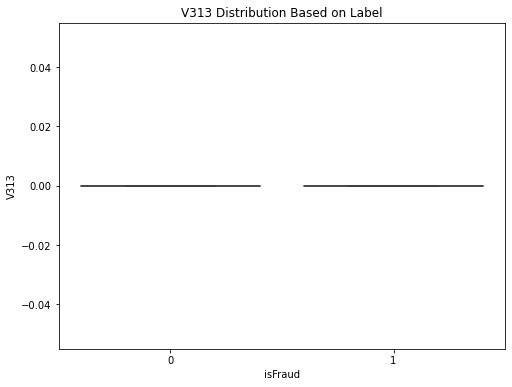

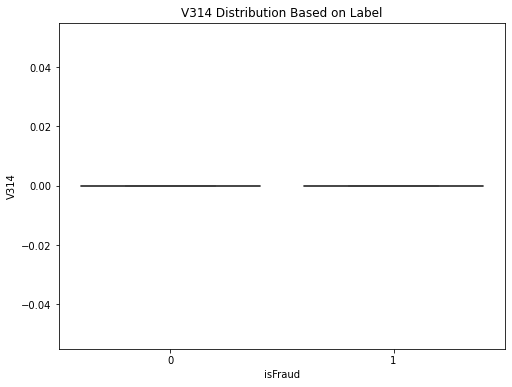

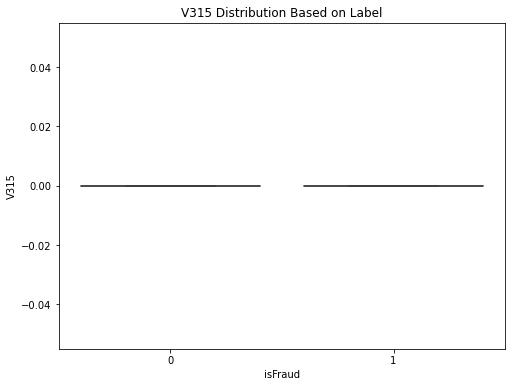

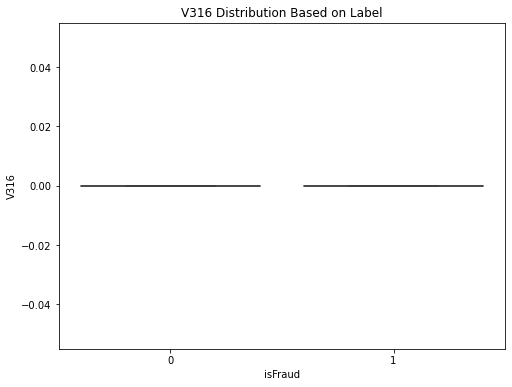

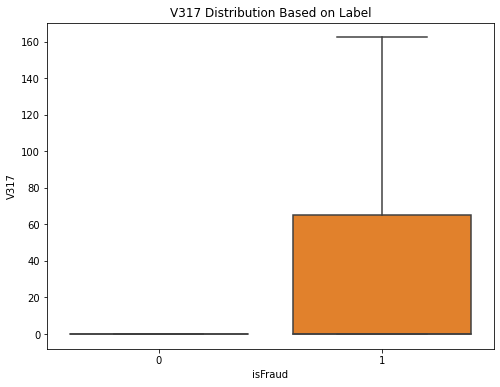

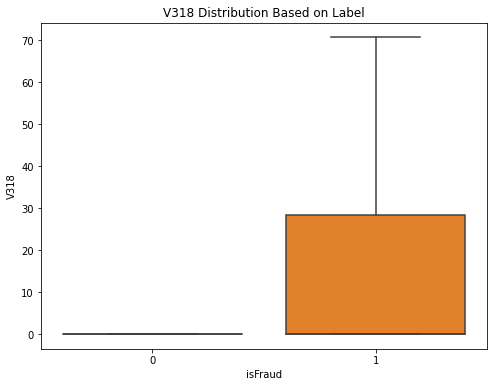

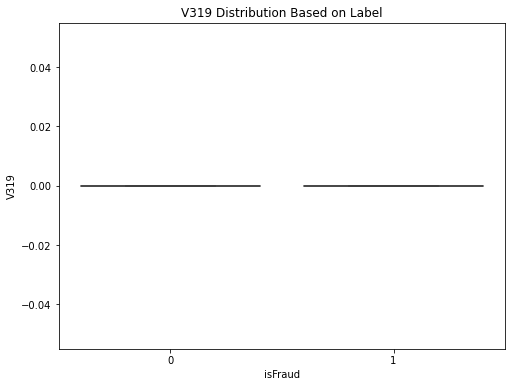

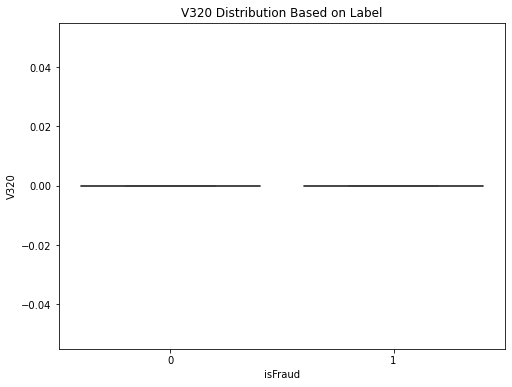

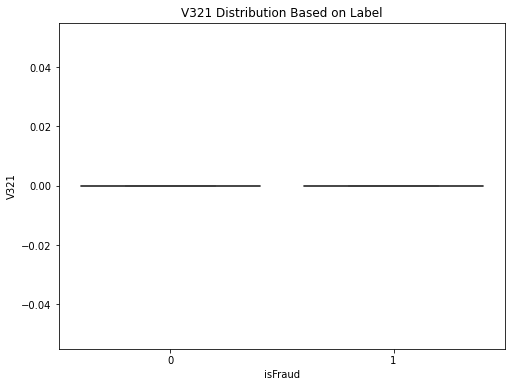

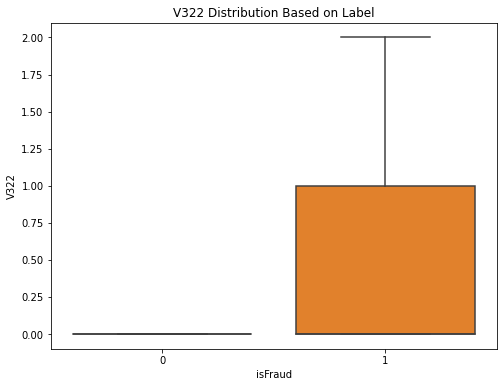

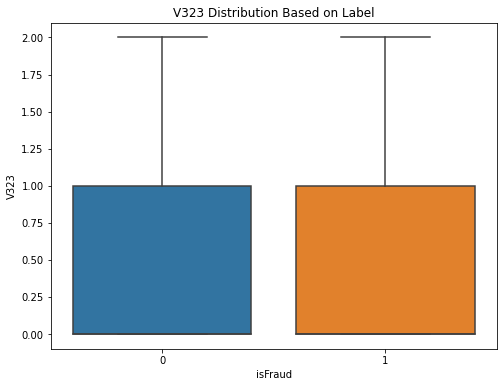

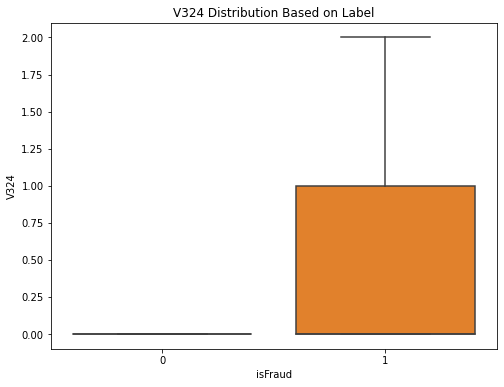

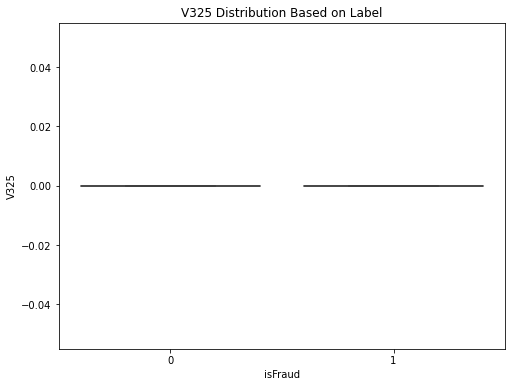

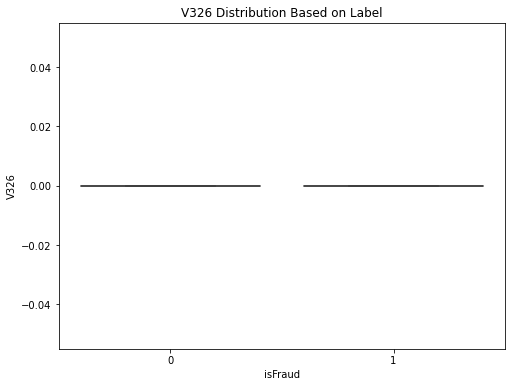

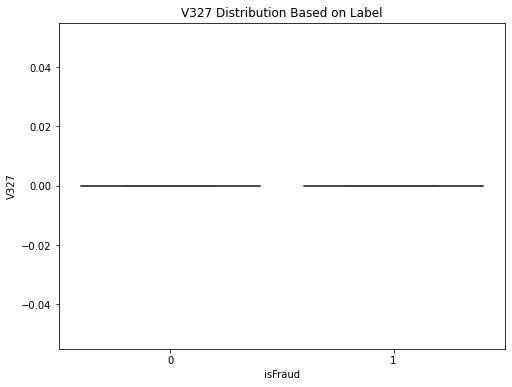

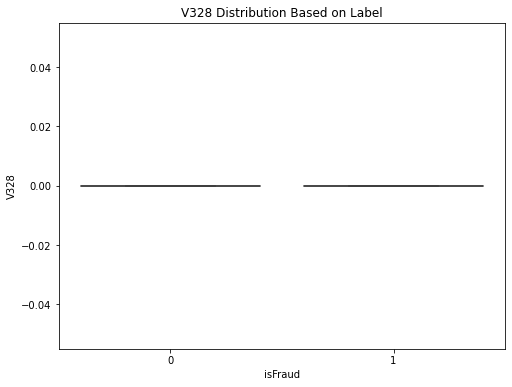

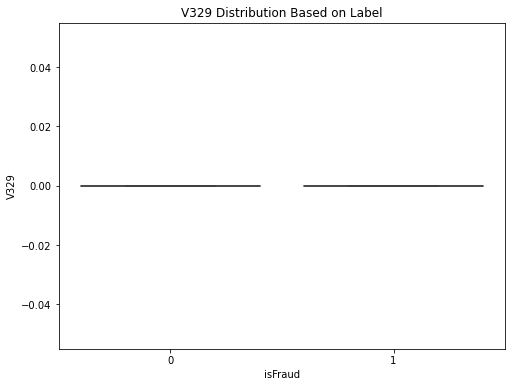

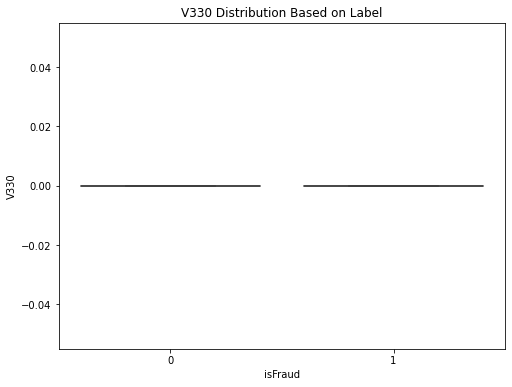

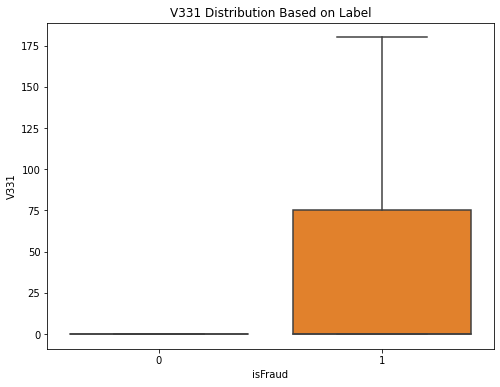

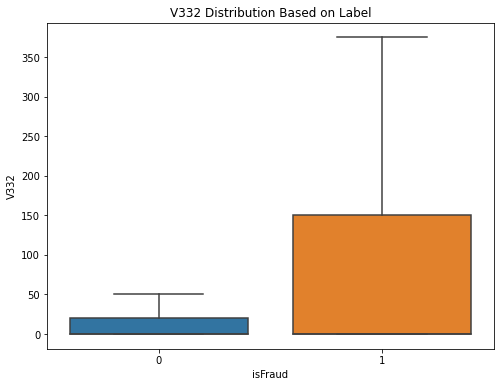

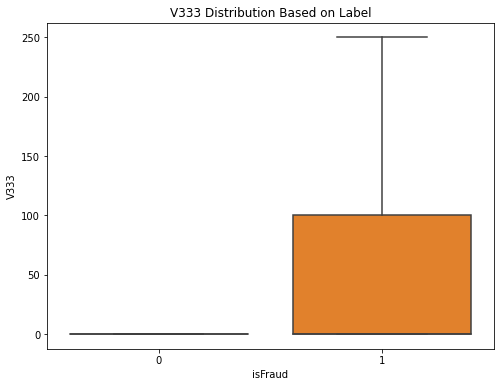

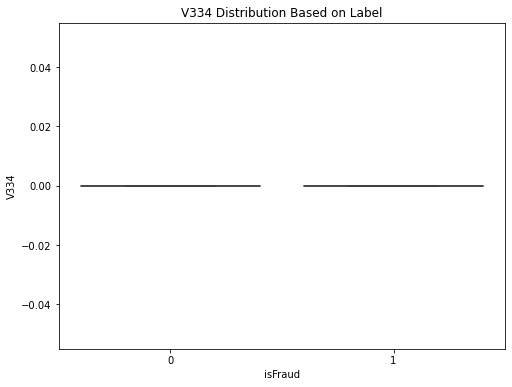

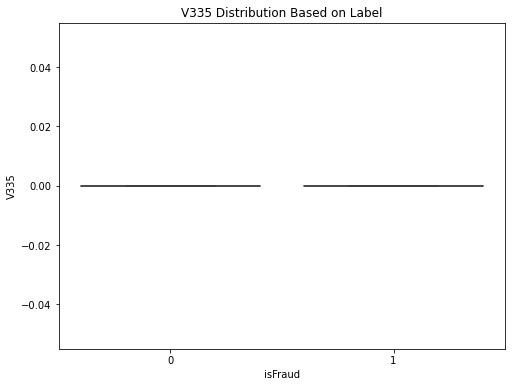

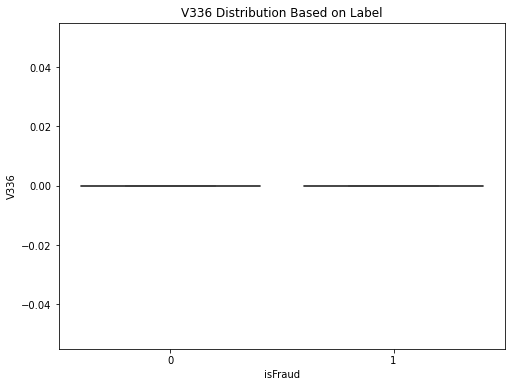

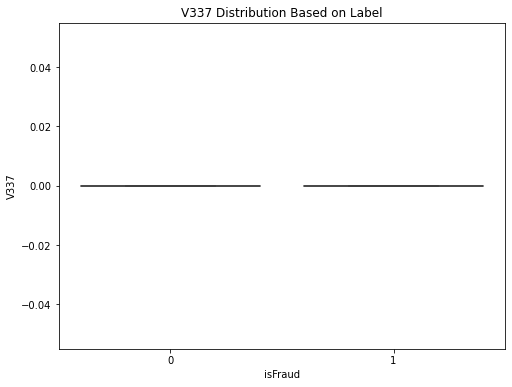

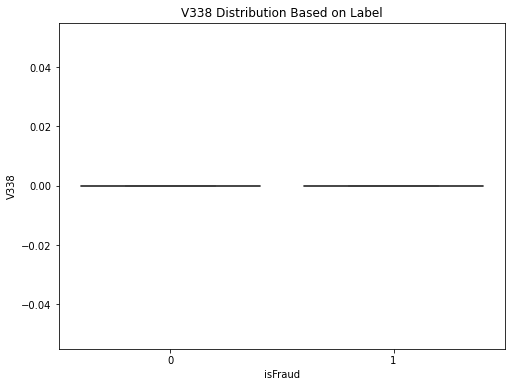

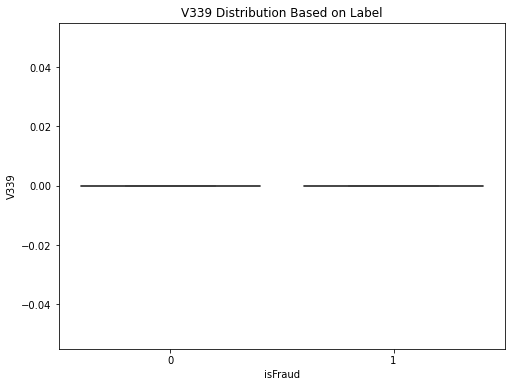

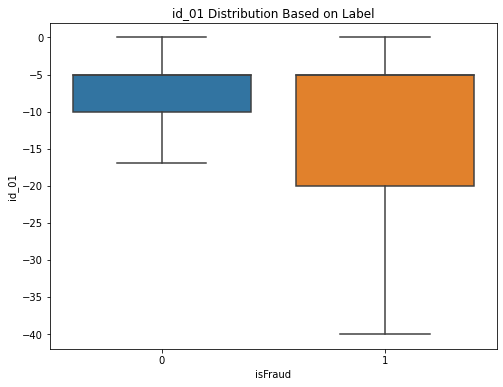

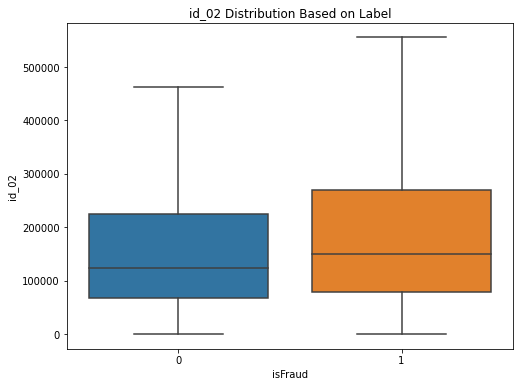

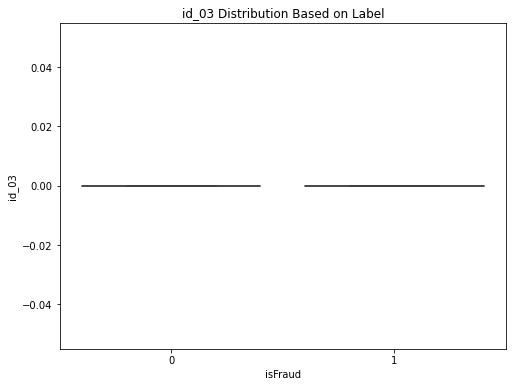

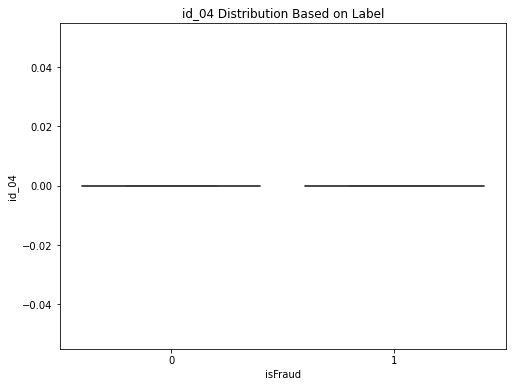

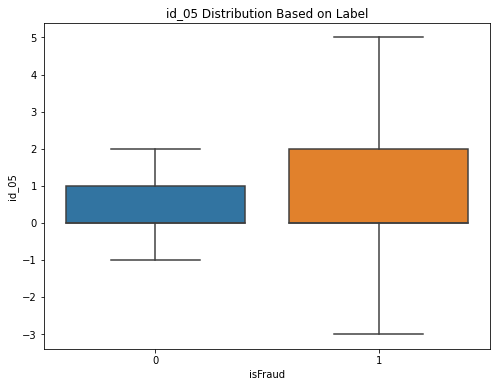

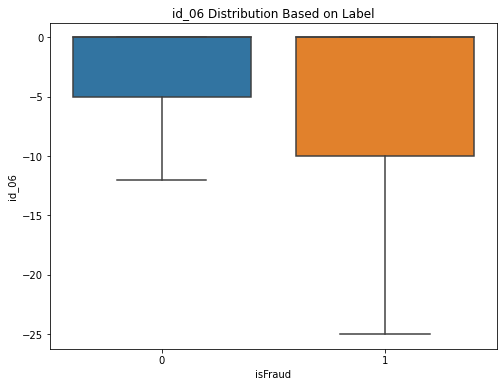

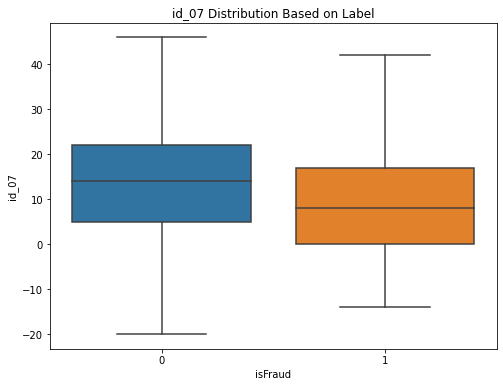

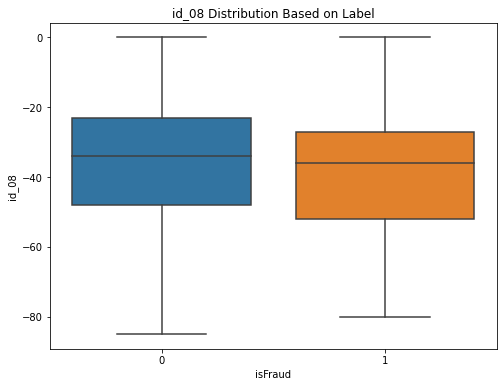

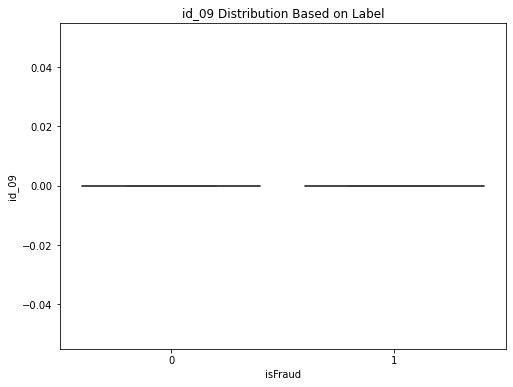

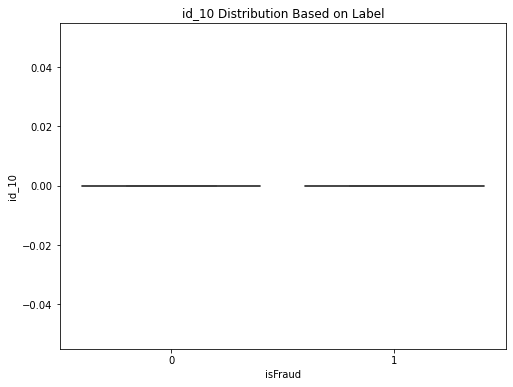

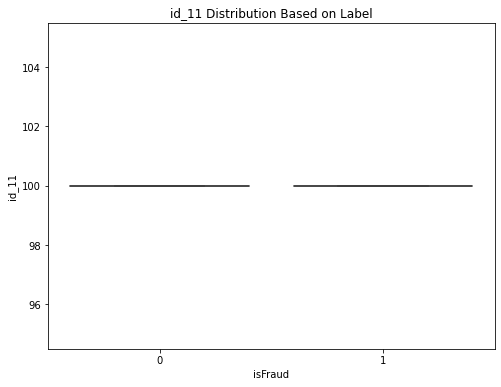

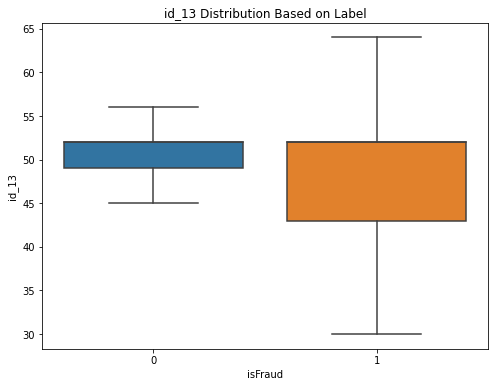

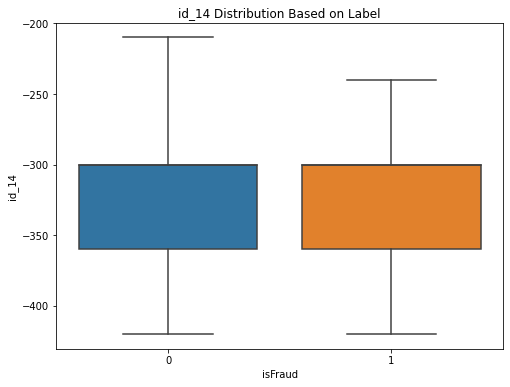

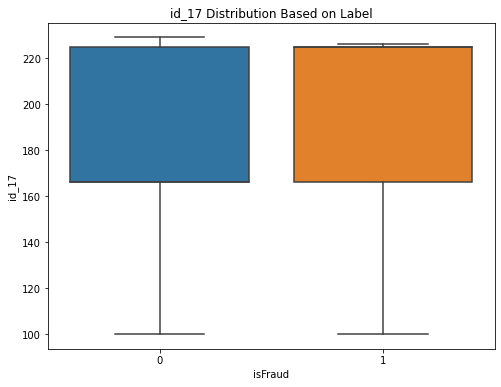

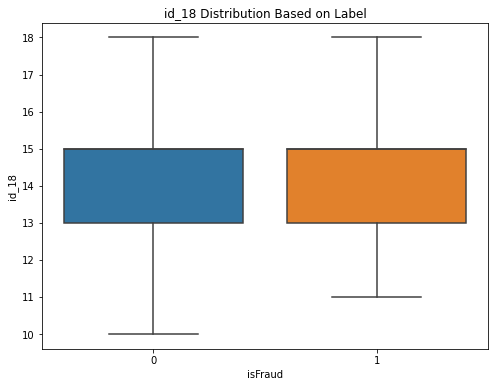

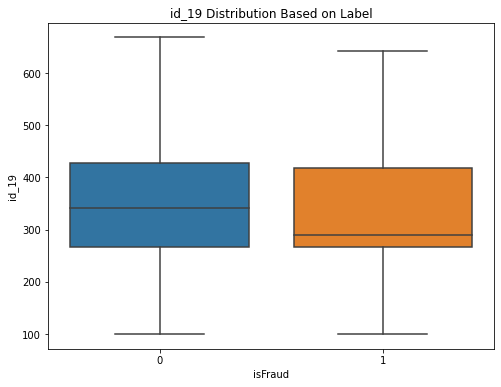

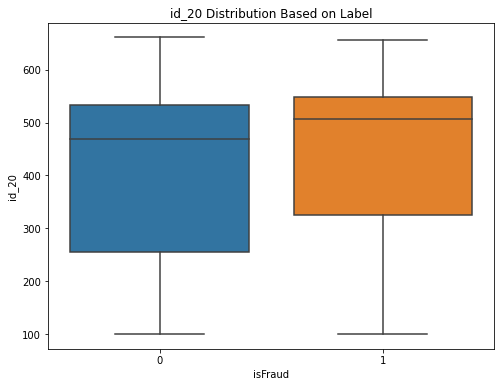

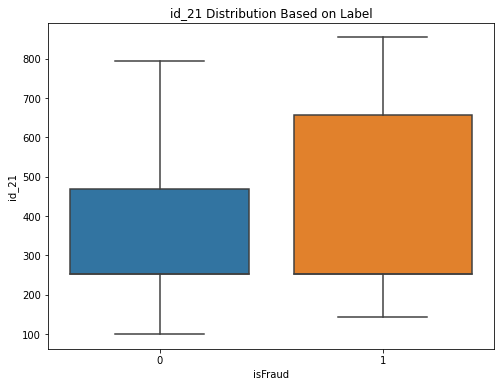

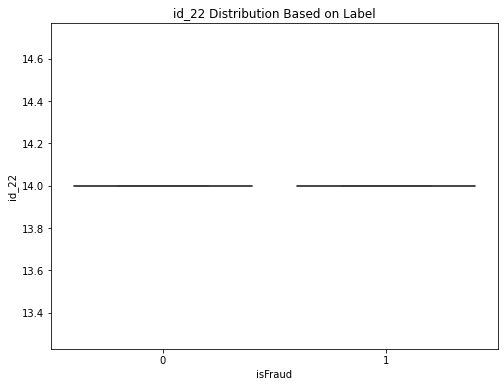

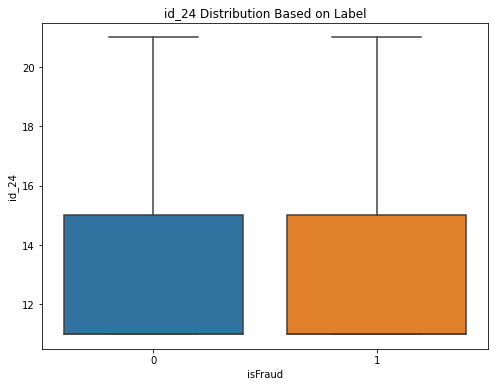

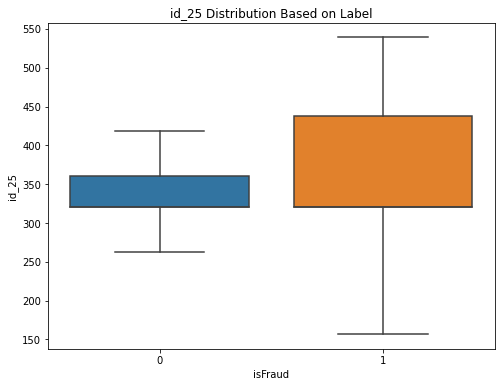

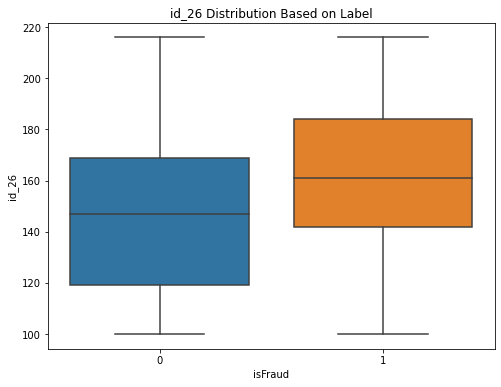

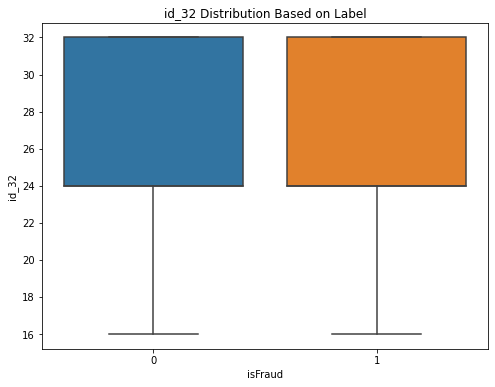

In [57]:
num_features = dfDesc[dfDesc['dataType'] != 'object']['dataFeatures'].values.tolist()[2:]

for i in num_features:
    plt.figure(figsize=(8,6))
    sns.boxplot(data=df, x='isFraud', y=i, showfliers=False)
    plt.title(f'{i} Distribution Based on Label')
    plt.show()

In [58]:
potential_features = ['TransactionAmt', 'card3', 'dist1', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6',
                      'D7', 'D8', 'D10', 'D11', 'D12', 'D14', 'D15', 'V10', 'V11', 'V15', 'V16',
                      'V17', 'V18', 'V21', 'V22', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V37',
                      'V38', 'V39', 'V40', 'V42', 'V43', 'V44', 'V45', 'V48', 'V49', 'V50', 'V51',
                      'V52', 'V57', 'V58', 'V59', 'V60', 'V63', 'V64', 'V69', 'V70', 'V71', 'V72',
                      'V73', 'V74', 'V78', 'V79', 'V80', 'V81', 'V84', 'V85', 'V87', 'V90', 'V91',
                      'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V102', 'V126', 'V128', 'V130',
                      'V133','V139','V140', #
                      'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V152', 'V153',
                      'V154', 'V155', 'V156', 'V157', 'V158', 'V165', 'V166', 'V167', 'V168', 'V170',
                      'V171', 'V176', 'V177', 'V178', 'V179', 'V186', 'V187', 'V188', 'V189', 'V190',
                      'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V211', 'V212', 'V213', 'V217',
                      'V218', 'V219', 'V221', 'V222', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 
                      'V236', 'V242', 'V243', 'V244', 'V245', 'V246', 'V250', 'V251', 'V255', 'V256',
                      'V257', 'V258', 'V259', 'V261', 'V263', 'V264', 'V265', 'V273', 'V274', 'V275', 
                      'V277', 'V279', 'V280', 'V282', 'V283', 'V287', 'V291', 'V294', 'V295', 'V302', 
                      'V303', 'V304', 'V306', 'V307', 'V308', 'V312', 'V317', 'V318', 'V322', 'V324', 
                      'V331', 'V332', 'V333', 'id_01', 'id_05', 'id_06', 'id_13', 'id_25', ]

Insight:
- Fitur-fitur di samping merupakan fitur dengan distribusi kasus fraud dan normal yang tersebar dengan cukup berbeda.
- Hal ini menandakan bahwa fitur-fitur ini bisa menjadi potensial fitur pada model yang akan dibangun.
- Terdapat 184 fitur yang memiliki sebaran yang cukup berbeda terhadap transaksi fraud dan transaksi normal. 

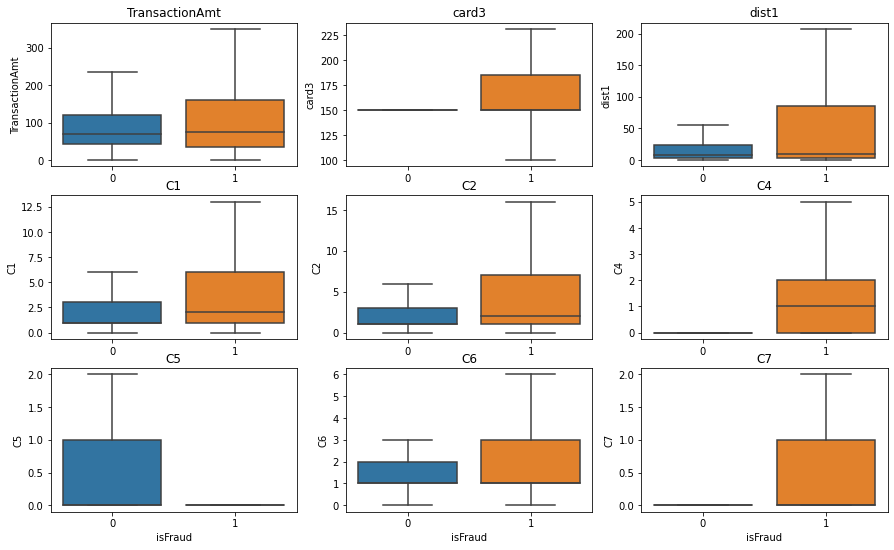

<Figure size 1440x864 with 0 Axes>

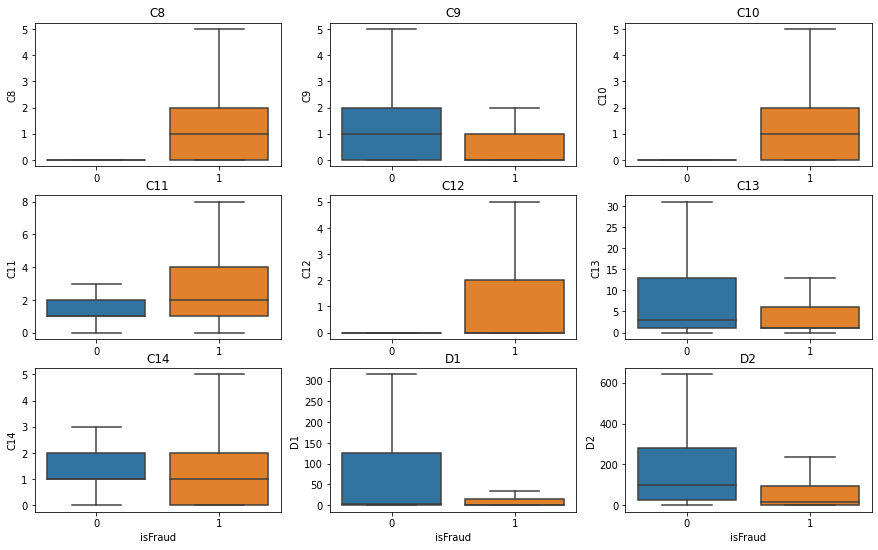

<Figure size 1440x864 with 0 Axes>

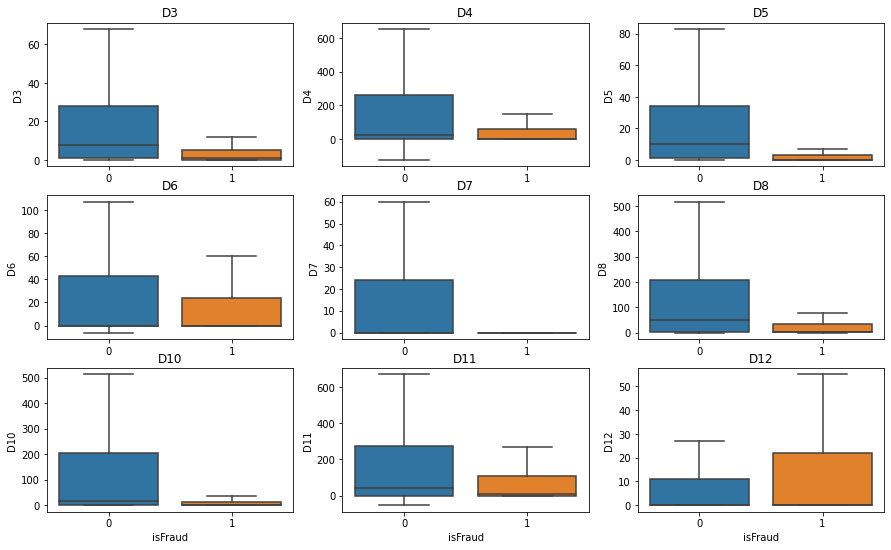

<Figure size 1440x864 with 0 Axes>

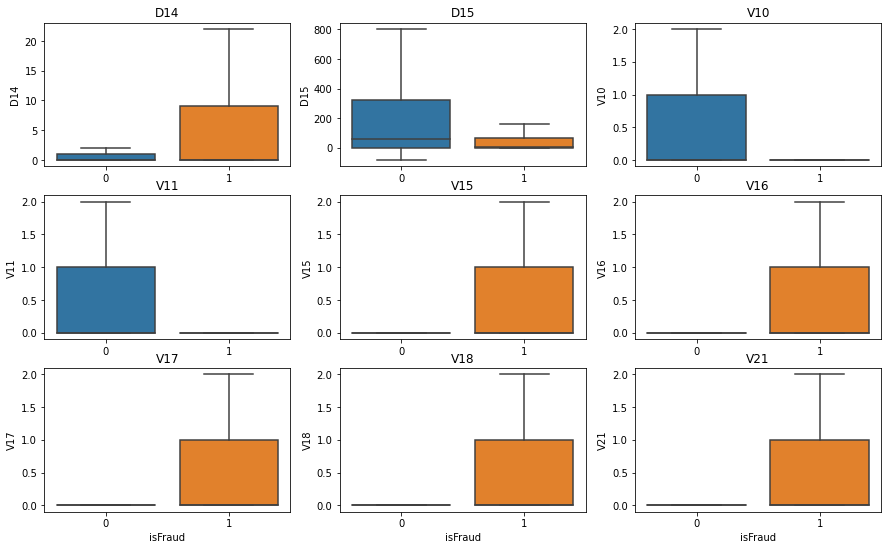

<Figure size 1440x864 with 0 Axes>

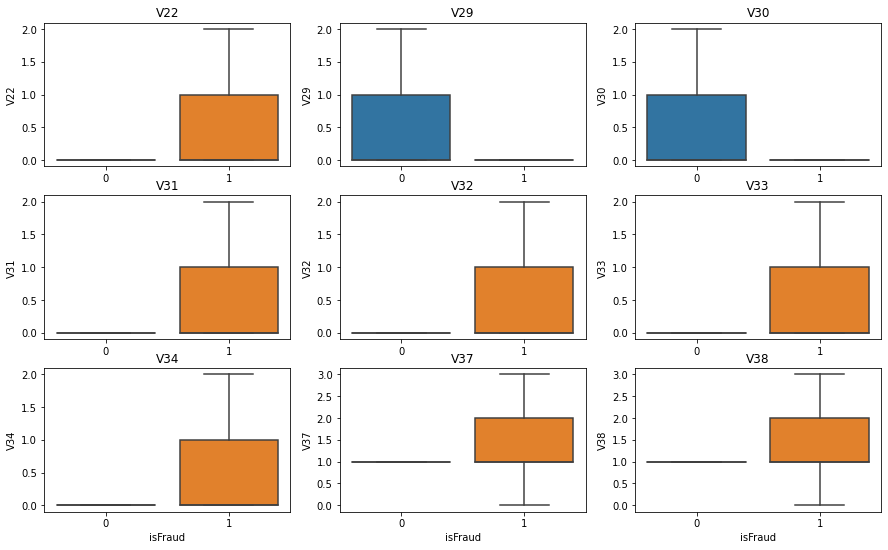

<Figure size 1440x864 with 0 Axes>

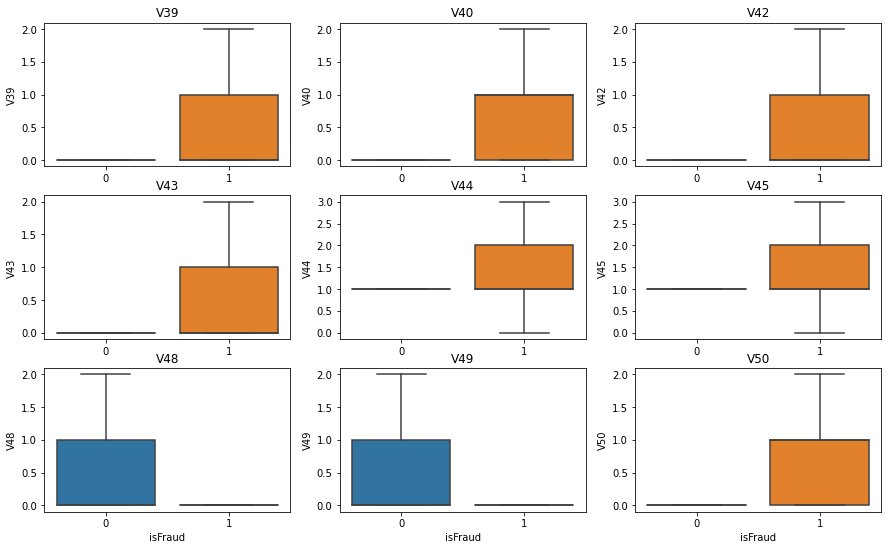

<Figure size 1440x864 with 0 Axes>

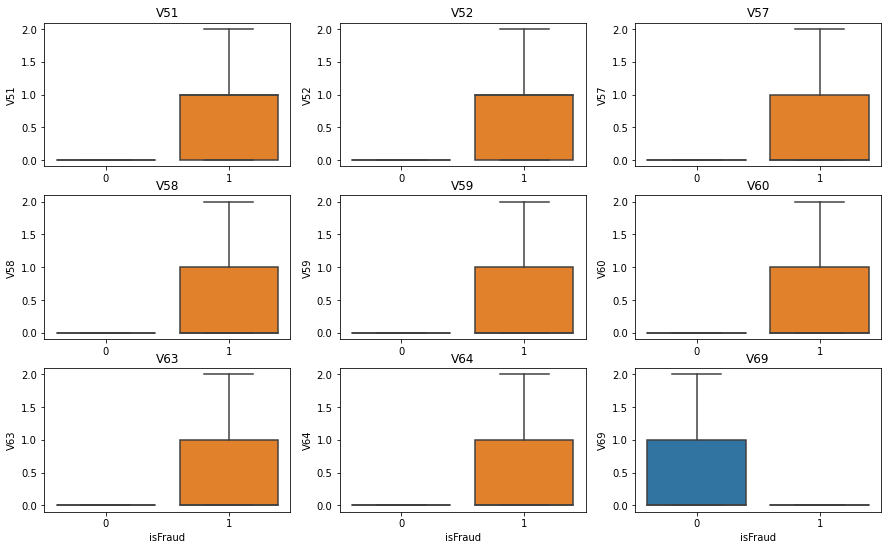

<Figure size 1440x864 with 0 Axes>

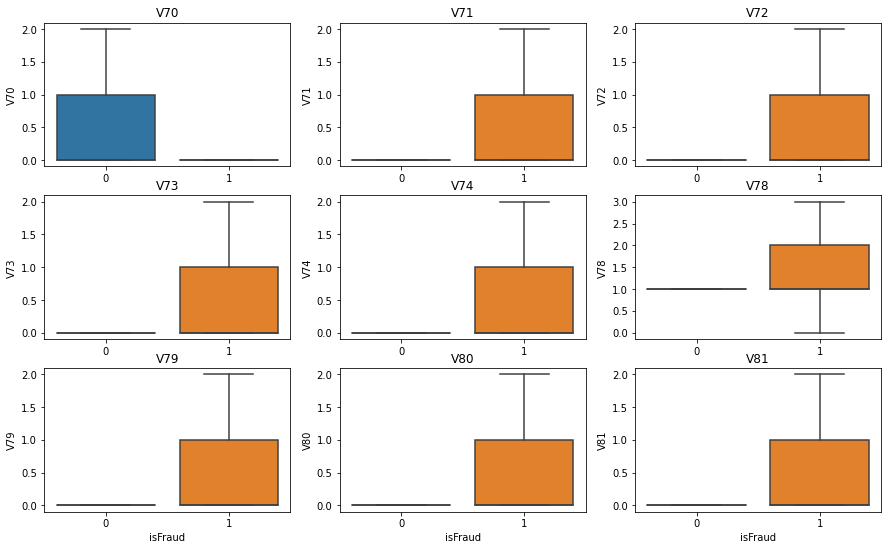

<Figure size 1440x864 with 0 Axes>

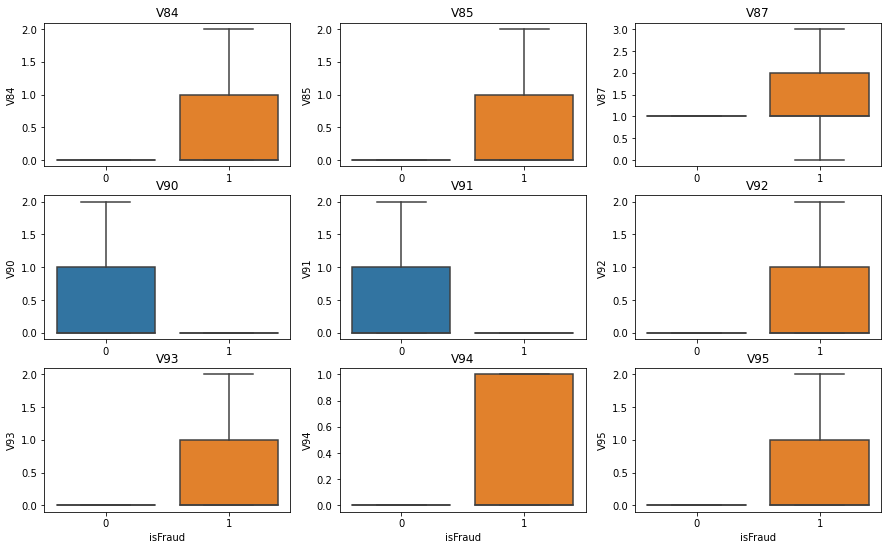

<Figure size 1440x864 with 0 Axes>

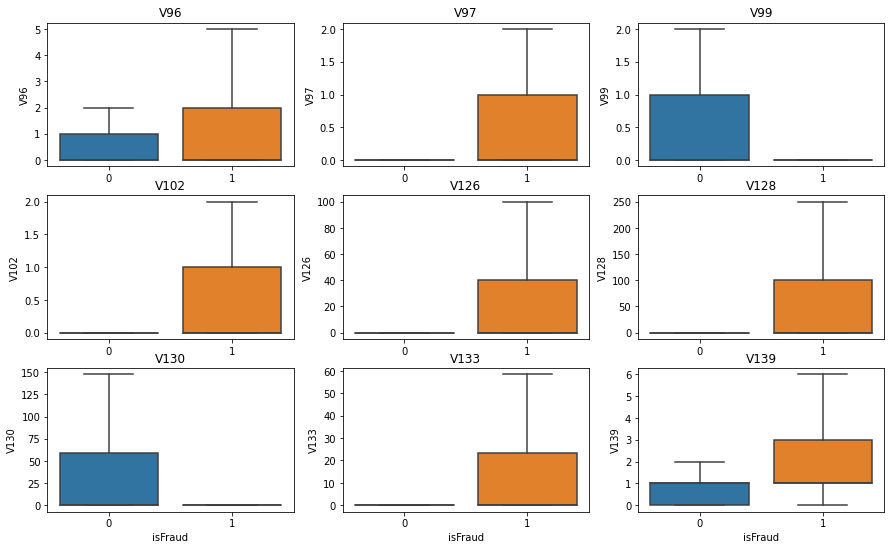

<Figure size 1440x864 with 0 Axes>

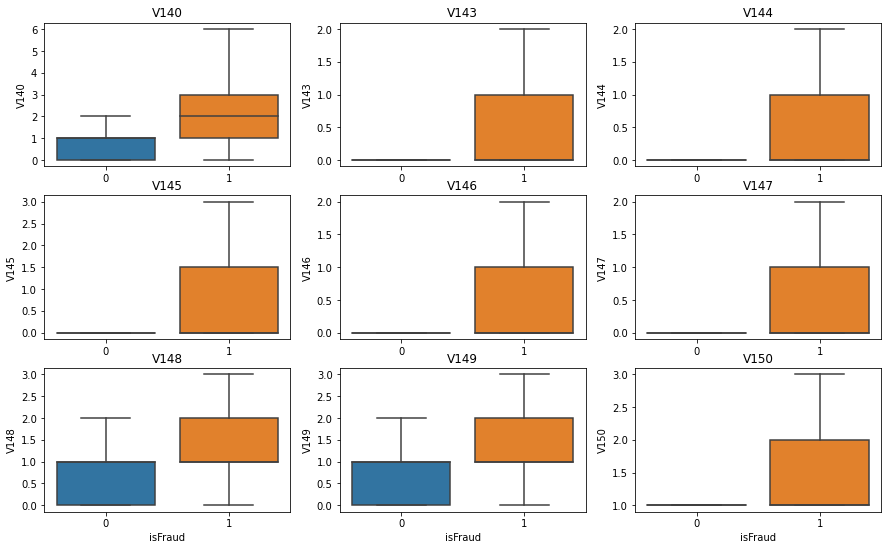

<Figure size 1440x864 with 0 Axes>

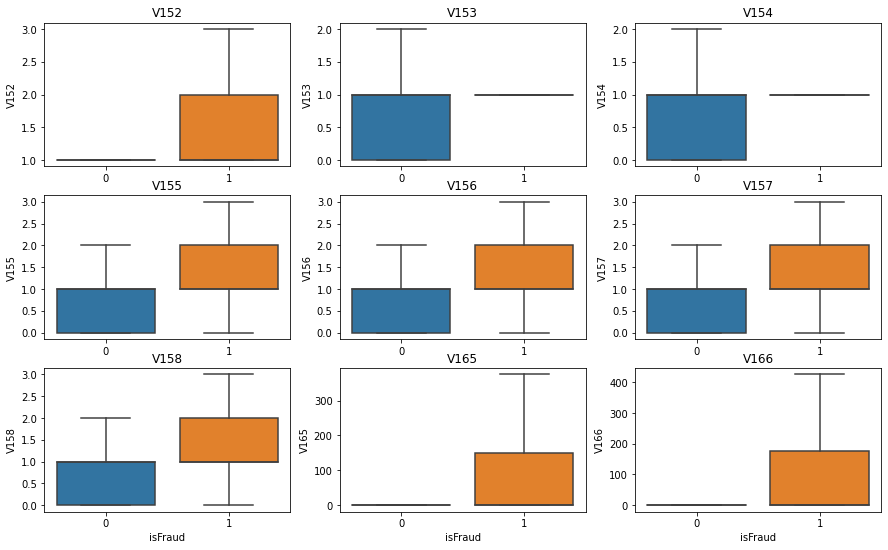

<Figure size 1440x864 with 0 Axes>

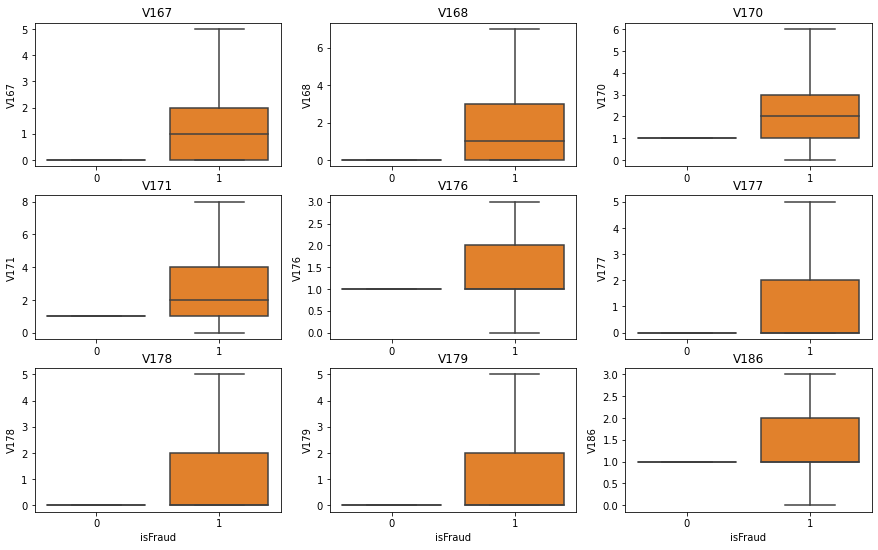

<Figure size 1440x864 with 0 Axes>

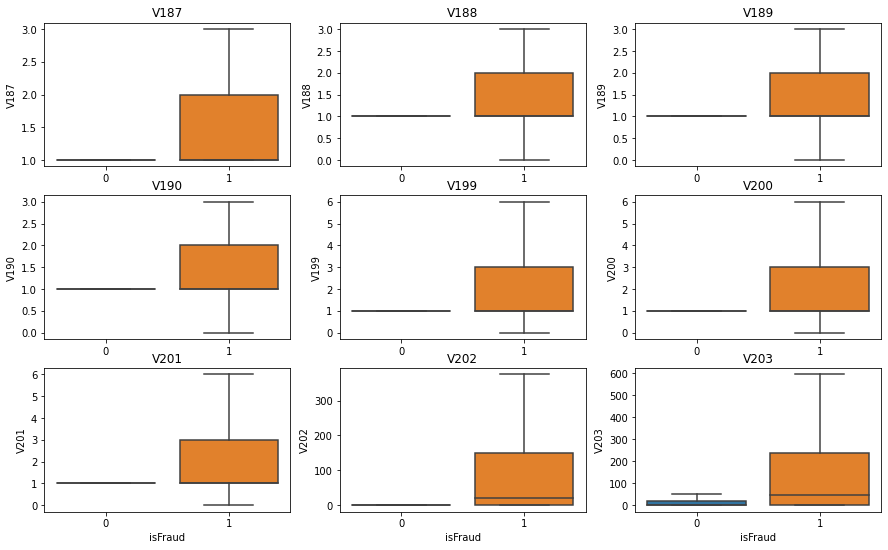

<Figure size 1440x864 with 0 Axes>

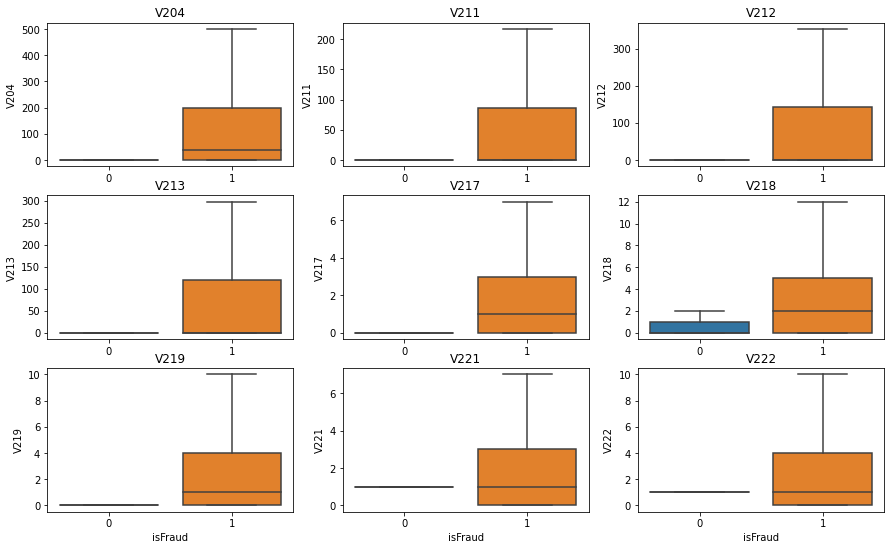

<Figure size 1440x864 with 0 Axes>

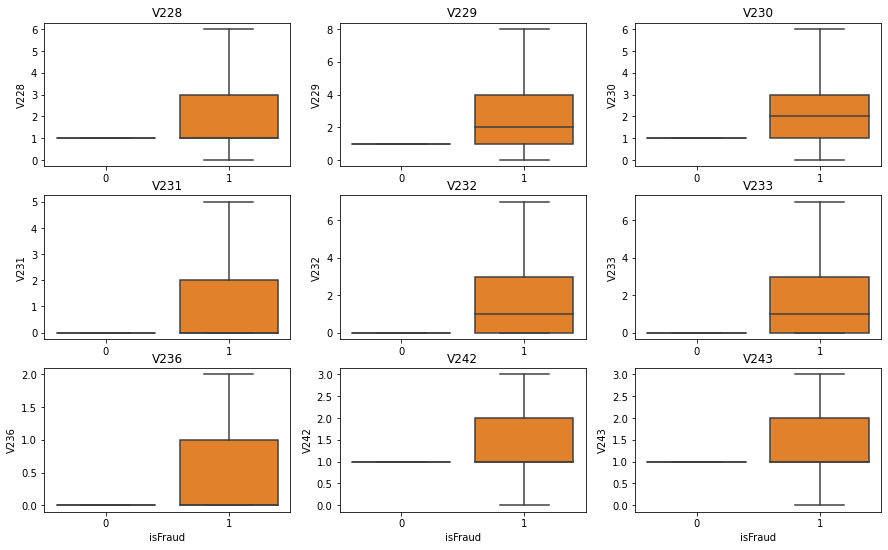

<Figure size 1440x864 with 0 Axes>

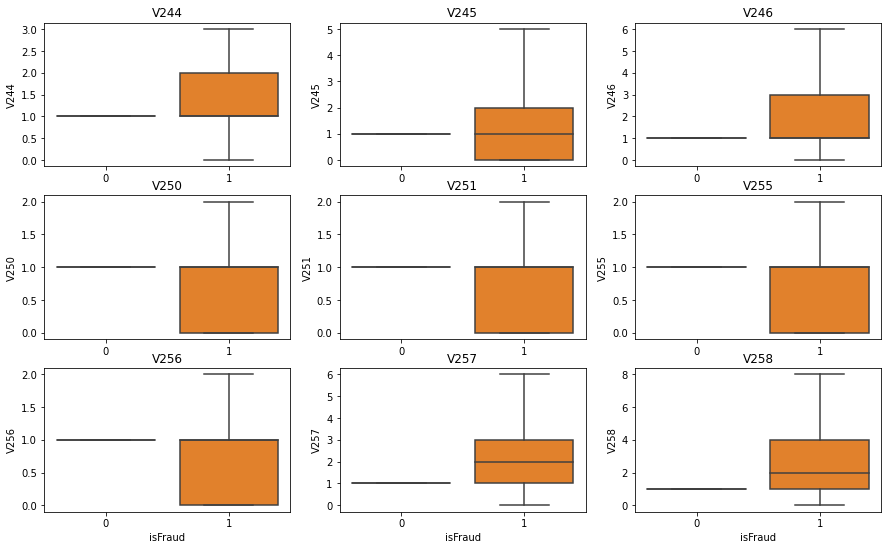

<Figure size 1440x864 with 0 Axes>

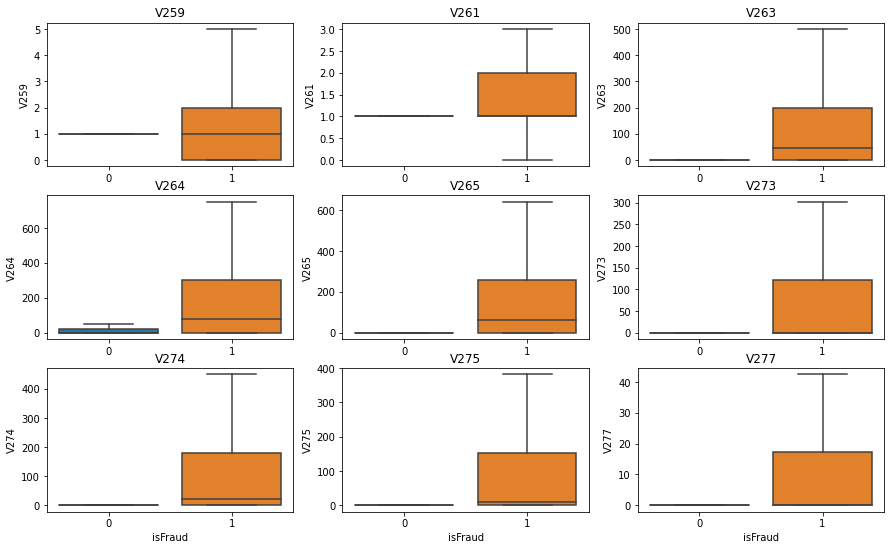

<Figure size 1440x864 with 0 Axes>

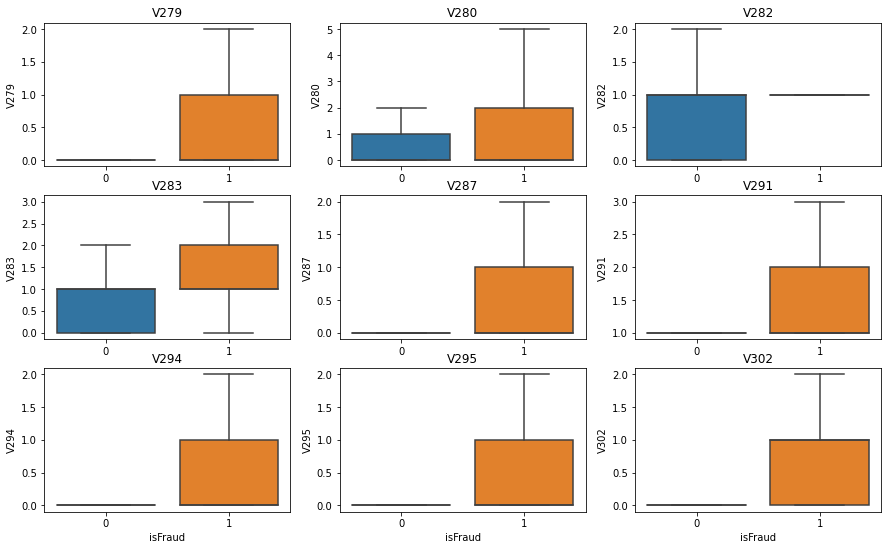

<Figure size 1440x864 with 0 Axes>

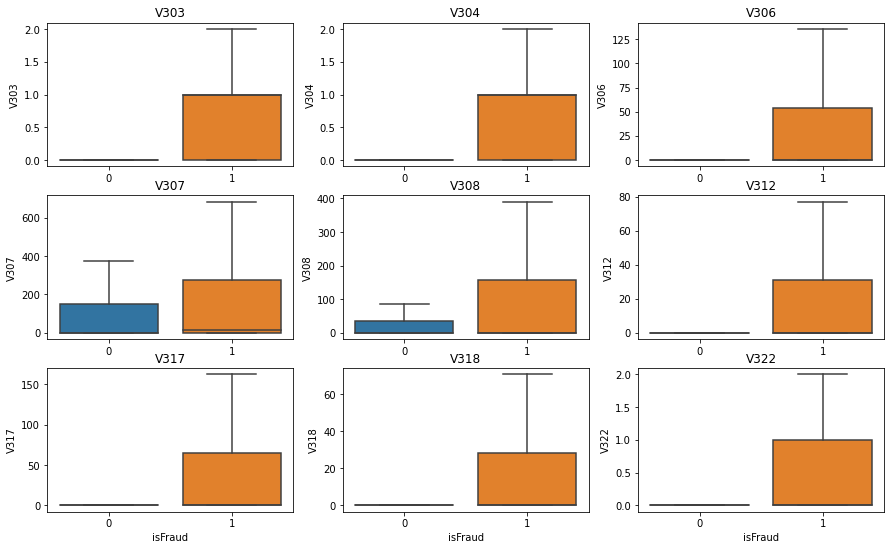

<Figure size 1440x864 with 0 Axes>

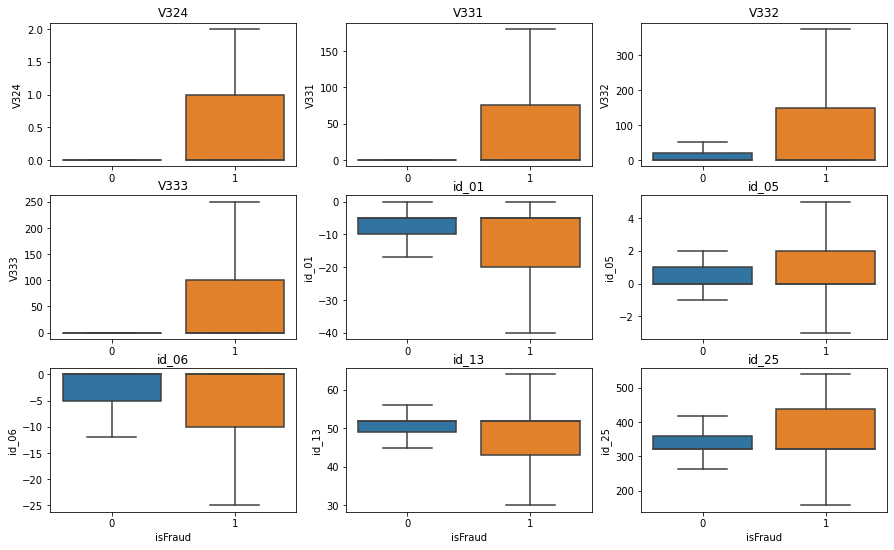

<Figure size 1440x864 with 0 Axes>

In [59]:
for i in range(int(len(potential_features)/9)):
    fig, axs = plt.subplots(3, 3, figsize=(15,9))
    plt.figure(figsize=(20,12))
    
    sns.boxplot(data=df, x='isFraud', y=potential_features[i*9 + 0], showfliers=False, ax=axs[0, 0])
    axs[0, 0].set_title(potential_features[i*9 + 0])
    axs[0, 0].set(xlabel=None)
    sns.boxplot(data=df, x='isFraud', y=potential_features[i*9 + 1], showfliers=False, ax=axs[0, 1])
    axs[0, 1].set_title(potential_features[i*9 + 1])
    axs[0, 1].set(xlabel=None)
    sns.boxplot(data=df, x='isFraud', y=potential_features[i*9 + 2], showfliers=False, ax=axs[0, 2])
    axs[0, 2].set_title(potential_features[i*9 + 2])
    axs[0, 2].set(xlabel=None)
    
    sns.boxplot(data=df, x='isFraud', y=potential_features[i*9 + 3], showfliers=False, ax=axs[1, 0])
    axs[1, 0].set_title(potential_features[i*9 + 3])
    axs[1, 0].set(xlabel=None)
    sns.boxplot(data=df, x='isFraud', y=potential_features[i*9 + 4], showfliers=False, ax=axs[1, 1])
    axs[1, 1].set_title(potential_features[i*9 + 4])
    axs[1, 1].set(xlabel=None)
    sns.boxplot(data=df, x='isFraud', y=potential_features[i*9 + 5], showfliers=False, ax=axs[1, 2])
    axs[1, 2].set_title(potential_features[i*9 + 5])
    axs[1, 2].set(xlabel=None)
    
    sns.boxplot(data=df, x='isFraud', y=potential_features[i*9 + 6], showfliers=False, ax=axs[2, 0])
    axs[2, 0].set_title(potential_features[i*9 + 6])
    sns.boxplot(data=df, x='isFraud', y=potential_features[i*9 + 7], showfliers=False, ax=axs[2, 1])
    axs[2, 1].set_title(potential_features[i*9 + 7])
    sns.boxplot(data=df, x='isFraud', y=potential_features[i*9 + 8], showfliers=False, ax=axs[2, 2])
    axs[2, 2].set_title(potential_features[i*9 + 8])
    
    plt.show()

## Data Preparation

Split data to training and testing

Data dibagi menjadi 80% untuk training dan 20% untuk testing.

In [22]:
categorical_features = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 
                        'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 
                        'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35',
                        'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
numeric_features = dfDesc[(dfDesc['dataType'] != 'object') & (dfDesc['dataFeatures'] != 'isFraud')]['dataFeatures'].values.tolist()

df_new = pd.merge(df_train_transaction, df_train_identity, on = 'TransactionID', how='left')

x = df_new.drop('isFraud', axis=1)
y = df_new['isFraud']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [179]:
x_test.shape

(118108, 433)

Undersampling data

In [23]:
def undersample(x_train, y_train, sampling_strategy=0.5):
    rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)
    x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)
    
    return x_train_rus, y_train_rus

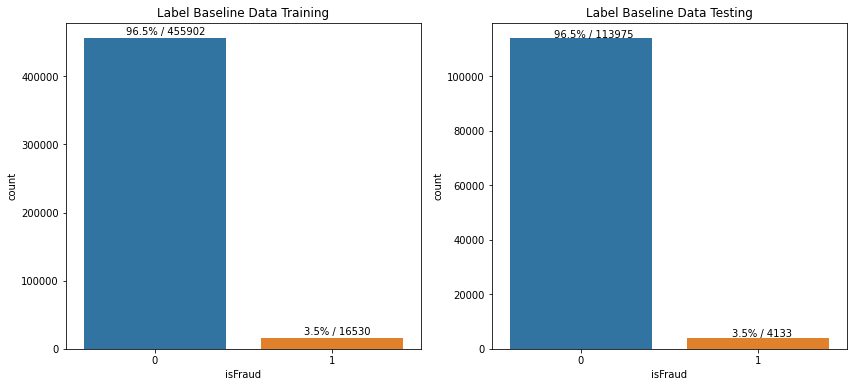

In [203]:

fig, axs = plt.subplots(1, 2, figsize=(14,6))

sns.countplot(y_train, ax=axs[0])
for i, v in enumerate(y_train.value_counts()):
    axs[0].text(i-0.16, v+5000, str(round((v/y_train.shape[0])*100, 2))+'% / '+str(v))
axs[0].set_title('Label Baseline Data Training')

sns.countplot(y_test, ax=axs[1])
for i, v in enumerate(y_test.value_counts()):
    axs[1].text(i-0.15, v+300, str(round((v/y_test.shape[0])*100, 2))+'% / '+str(v))
axs[1].set_title('Label Baseline Data Testing')
plt.show()

Jumlah data setelah dibagi menjadi training dan testing. Terlihat bahwa proporsi label antara training dan testing sama.

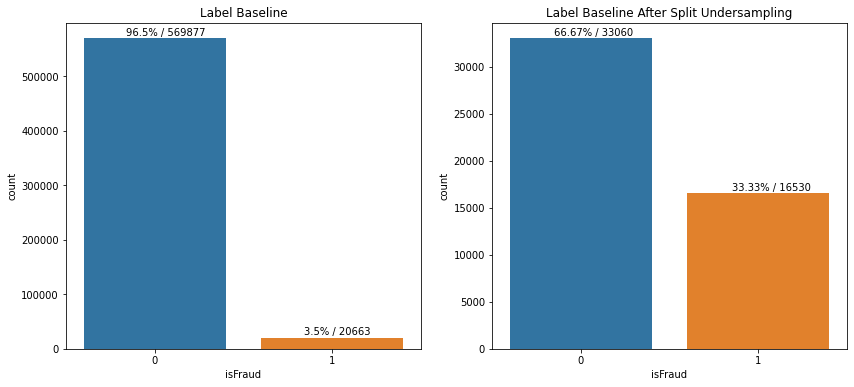

In [202]:
x_after_us, y_after_us = undersample(x_train, y_train, 0.5)
fig, axs = plt.subplots(1, 2, figsize=(14,6))

sns.countplot(df_train_transaction['isFraud'], ax=axs[0])
for i, v in enumerate(df_train_transaction['isFraud'].value_counts()):
    axs[0].text(i-0.16, v+5000, str(round((v/df_train_transaction['isFraud'].shape[0])*100, 2))+'% / '+str(v))
axs[0].set_title('Label Baseline')

sns.countplot(y_after_us, ax=axs[1])
for i, v in enumerate(y_after_us.value_counts()):
    axs[1].text(i-0.15, v+300, str(round((v/y_after_us.shape[0])*100, 2))+'% / '+str(v))
axs[1].set_title('Label Baseline After Split Undersampling')
plt.show()

Setelah dilakukan split antara data training dan data testing. Kelompok data training dilakukan undersampling. Hasil distribusi label setelah dilakukan undersampling dapat dilihat pada gambar di sebelah kanan.

Fill missing value with '-999' for categorical boosting (CatBoost) model requirement

In [24]:
x_train_v1 = x_train.copy()
x_train_v1 = x_train_v1.fillna(-999)

x_test_v1 = x_test.copy()
x_test_v1 = x_test_v1.fillna(-999)

Feature Selection

In [49]:
mrmr_features = mrmr_classif(X=x[numeric_features], y=y, K=150)
selected_features = mrmr_features + categorical_features

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [08:59<00:00,  3.60s/it]


## Modelling

### Model Benchmarking 

Pertama kali yang dilakukan yaitu membandingkan model dengan data training tanpa undersampling. Model yang digunakan adalah XGBoost, CatBoost, dan LightGBM.

In [26]:
xgb = XGBClassifier(tree_method="hist", enable_categorical=True)
catb = CatBoostClassifier(verbose=False, cat_features=categorical_features)
lgbm = LGBMClassifier(enable_categorical=True)

models = [xgb, catb, lgbm]
score = []
rata = []
std = []
score_test = []

# Training
for model in models:
    skfold = StratifiedKFold(n_splits=5)

    if model == xgb or model == lgbm:    
        x_train_benchmark = x_train
        y_train_benchmark = y_train
        
        for feature in categorical_features:
            x_train_benchmark[feature] = x_train_benchmark[feature].astype('category')
        
        model_cv = cross_val_score(model, x_train_benchmark, y_train_benchmark, cv=skfold, scoring='roc_auc')
    else:
        x_train_benchmark = x_train.copy()
        x_train_benchmark = x_train_v1.fillna(-999)
        
        for feature in categorical_features:
            x_train_benchmark[feature] = x_train_benchmark[feature].astype('object')

        model_cv = cross_val_score(model, x_train_benchmark, y_train_benchmark, cv=skfold, scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())

[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: enable_categorical


In [27]:
# Testing

score_test = []
def y_pred_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    
    return model, model.predict(x_test)

for model, j in zip(models, ['XGBoost', 'CatBoost', 'LightGBM']):
    if model == xgb or model == lgbm:    
        x_train_benchmark = x_train
        y_train_benchmark = y_train
        
        x_test_benchmark = x_test
        y_test_benchmark = y_test
    else:
        x_train_benchmark = x_train_v1
        y_train_benchmark = y_train
        
        x_test_benchmark = x_test_v1
        y_test_benchmark = y_test
        
    for feature in categorical_features:
        x_train_benchmark[feature] = x_train_benchmark[feature].astype('category')
        x_test_benchmark[feature] = x_test_benchmark[feature].astype('category')

    estimator, y_pred_benchmark = y_pred_func(model, 
                                            x_train_benchmark, y_train_benchmark, 
                                            x_test_benchmark, y_test_benchmark)
        
    y_predict_proba = estimator.predict_proba(x_test_benchmark)[:,1]
    score_test.append(roc_auc_score(y_test_benchmark, y_predict_proba))
    
    print(j,'\n', classification_report(y_test_benchmark, y_pred_benchmark))

XGBoost 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.90      0.45      0.60      4133

    accuracy                           0.98    118108
   macro avg       0.94      0.73      0.80    118108
weighted avg       0.98      0.98      0.98    118108

CatBoost 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.95      0.55      0.69      4133

    accuracy                           0.98    118108
   macro avg       0.97      0.77      0.84    118108
weighted avg       0.98      0.98      0.98    118108

[LightGBM] [Warning] Unknown parameter: enable_categorical
LightGBM 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.90      0.47      0.61      4133

    accuracy                           0.98    118108
   macro avg       0.94      0.73    

In [28]:
df_benchmark = pd.DataFrame({
                'Model':['XGBoost', 'CatBoost', 'LightGBM'],
                'Mean ROC_AUC Training': rata,
                'Stdev ROC_AUC': std,
                'ROC_AUC Testing': score_test}).set_index('Model').sort_values(by='Mean ROC_AUC Training',ascending=False)

df_benchmark

Mean ROC_AUC Training  Stdev ROC_AUC  ROC_AUC Testing
Model                                                          
XGBoost                0.940844       0.002758         0.938299
CatBoost               0.935683       0.003021         0.939619
LightGBM               0.931602       0.001998         0.934585

Dari hasil tersebut, dapat dilihat bahwa model XGBoost memiliki skor terbaik saat training. Namun pada saat testing model CatBoost memiliki performance yang terbaik. Walaupun begitu, model CatBoost memiliki standar deviasi yang cukup tinggi pada saat training data yang mengindikasikan bahwa model tersebut kurang stabil. Oleh karna itu, yang akan dipilih untuk proses selanjutnya adalah model XGBoost.

### Modelling With Undersampling

In [29]:
def calc_error(X, y, model):
    # '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X)
    predictProba = model.predict_proba(X)
    
    roc_auc = roc_auc_score(y, predictProba[:,1])
    recall = recall_score(y, predictions)
    precision = precision_score(y, predictions)
    report = classification_report(y, predictions)

    cf_matrix = confusion_matrix(y, predictions)
    fpr = cf_matrix[0][1]/(cf_matrix[0][1]+cf_matrix[0][0])    
    return { 
        'report': report, 
        'roc': roc_auc, 
        'recall': recall,
        'precision': precision,
        'fpr': fpr
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    # '''fits model and returns the in-sample error and out-of-sample error'''
    train_error = calc_error(X_train, y_train, model)
    validation_error = calc_error(X_test, y_test, model)
    return train_error, validation_error

def evaluation(train_error, validation_error):
    listItem = []

    for tr, val in zip(train_error, validation_error) :
        listItem.append([tr['roc'], val['roc'], 
                         tr['recall'], val['recall'], 
                         tr['precision'], val['precision'],
                         tr['fpr'], val['fpr']])

    listItem.append(list(np.mean(listItem,axis=0)))

    dfEvaluate = pd.DataFrame(listItem, 
                        columns=['Train ROC AUC', 
                                 'Val ROC AUC', 
                                 'Train Recall',
                                 'Val Recall',
                                 'Train Precision',
                                 'Val Precision',
                                 'Train FPR',
                                 'Val FPR'])

    listIndex = list(dfEvaluate.index)
    listIndex[-1] = 'Average'
    dfEvaluate.index = listIndex
    
    return dfEvaluate

In [36]:
# Training
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_errors_without_undersampling_xgb = []
validation_errors_without_undersampling_xgb = []

train_errors_with_undersampling_xgb = []
validation_errors_with_undersampling_xgb = []

train_errors_with_undersampling_xgb_2 = []
validation_errors_with_undersampling_xgb_2 = []

train_errors_with_undersampling_xgb_3 = []
validation_errors_with_undersampling_xgb_3 = []

data = x_train
target = y_train

for feature in categorical_features:
    data[feature] = data[feature].astype('category')

for train_index, val_index in kf.split(data, target):
    # split data
    x_train_, x_val_ = data.iloc[train_index], data.iloc[val_index]
    y_train_, y_val_ = target.iloc[train_index], target.iloc[val_index]
    
    # WITHOUT UNDERSAMPLING
    # calculate errors without undersampling
    estimator_3 = XGBClassifier(tree_method="hist", 
                                enable_categorical=True)
    estimator_3.fit(x_train_, y_train_)
    
    train_error_without_undersampling_xgb, val_error_without_undersampling_xgb = calc_metrics(x_train_, y_train_, x_val_, y_val_, estimator_3)
    
    # WITH UNDERSAMPLING (FRAC = 0.3)
    # instantiate model
    x_train_rus, y_train_rus = undersample(x_train_, y_train_, 0.3)
    
    estimator_4 = XGBClassifier(tree_method="hist", 
                                enable_categorical=True)
    estimator_4.fit(x_train_rus, y_train_rus)
    
    train_error_with_undersampling_xgb, val_error_with_undersampling_xgb = calc_metrics(x_train_rus, y_train_rus, x_val_, y_val_, estimator_4)
    
    # WITH UNDERSAMPLING (FRAC = 0.5)
    # instantiate model
    x_train_rus_2, y_train_rus_2 = undersample(x_train_, y_train_, 0.5)
    
    estimator_5 = XGBClassifier(tree_method="hist", 
                                enable_categorical=True)
    estimator_5.fit(x_train_rus_2, y_train_rus_2)
    
    train_error_with_undersampling_xgb_2, val_error_with_undersampling_xgb_2 = calc_metrics(x_train_rus_2, y_train_rus_2, x_val_, y_val_, estimator_5)
    
    # WITH UNDERSAMPLING (FRAC = 0.7)
    # instantiate model
    x_train_rus_3, y_train_rus_3 = undersample(x_train_, y_train_, 0.7)
    
    estimator_6 = XGBClassifier(tree_method="hist", 
                                enable_categorical=True)
    estimator_6.fit(x_train_rus_3, y_train_rus_3)
    
    train_error_with_undersampling_xgb_3, val_error_with_undersampling_xgb_3 = calc_metrics(x_train_rus_3, y_train_rus_3, x_val_, y_val_, estimator_6)
    
    # append to appropriate list
    train_errors_without_undersampling_xgb.append(train_error_without_undersampling_xgb)
    validation_errors_without_undersampling_xgb.append(val_error_without_undersampling_xgb)
    
    train_errors_with_undersampling_xgb.append(train_error_with_undersampling_xgb)
    validation_errors_with_undersampling_xgb.append(val_error_with_undersampling_xgb)
    
    train_errors_with_undersampling_xgb_2.append(train_error_with_undersampling_xgb_2)
    validation_errors_with_undersampling_xgb_2.append(val_error_with_undersampling_xgb_2)
    
    train_errors_with_undersampling_xgb_3.append(train_error_with_undersampling_xgb_3)
    validation_errors_with_undersampling_xgb_3.append(val_error_with_undersampling_xgb_3)

Without Undersampling

In [37]:
df_eval_without_undersampling_xgb = evaluation(train_errors_without_undersampling_xgb, validation_errors_without_undersampling_xgb)
df_eval_without_undersampling_xgb

Train ROC AUC  Val ROC AUC  Train Recall  Val Recall  \
0             0.967211     0.940920      0.594601    0.514519   
1             0.966191     0.940326      0.595886    0.507562   
2             0.964470     0.943610      0.590820    0.511494   
3             0.966605     0.938497      0.591878    0.504840   
4             0.962525     0.943942      0.582804    0.514217   
Average       0.965400     0.941459      0.591198    0.510526   

         Train Precision  Val Precision  Train FPR   Val FPR  
0               0.974712       0.924959   0.000559  0.001513  
1               0.973561       0.936384   0.000587  0.001250  
2               0.973461       0.922531   0.000584  0.001557  
3               0.969768       0.913519   0.000669  0.001733  
4               0.971879       0.932018   0.000611  0.001360  
Average         0.972676       0.925882   0.000602  0.001483

With Undersampling (Frac=0.3)

In [38]:
df_eval_with_undersampling_xgb = evaluation(train_errors_with_undersampling_xgb, validation_errors_with_undersampling_xgb)
df_eval_with_undersampling_xgb

Train ROC AUC  Val ROC AUC  Train Recall  Val Recall  \
0             0.973695     0.936115      0.786978    0.707502   
1             0.973855     0.939241      0.787886    0.697520   
2             0.974562     0.944278      0.789701    0.705687   
3             0.976827     0.941491      0.799834    0.707502   
4             0.975449     0.946113      0.785541    0.712644   
Average       0.974878     0.941448      0.789988    0.706171   

         Train Precision  Val Precision  Train FPR   Val FPR  
0               0.960942       0.496919   0.009596  0.025970  
1               0.963206       0.500434   0.009029  0.025246  
2               0.961602       0.509834   0.009460  0.024600  
3               0.965760       0.491593   0.008507  0.026530  
4               0.961318       0.500957   0.009483  0.025740  
Average         0.962566       0.499947   0.009215  0.025617

With Undersampling (Frac=0.5)

In [39]:
df_eval_with_undersampling_xgb_2 = evaluation(train_errors_with_undersampling_xgb_2, validation_errors_with_undersampling_xgb_2)
df_eval_with_undersampling_xgb_2

Train ROC AUC  Val ROC AUC  Train Recall  Val Recall  \
0             0.976915     0.936989      0.843088    0.765880   
1             0.978326     0.940641      0.841878    0.765275   
2             0.978277     0.940867      0.845130    0.766788   
3             0.978125     0.936874      0.842332    0.767393   
4             0.977826     0.944203      0.841349    0.779189   
Average       0.977894     0.939915      0.842756    0.768905   

         Train Precision  Val Precision  Train FPR   Val FPR  
0               0.957982       0.355818   0.018489  0.050274  
1               0.957348       0.364134   0.018754  0.048453  
2               0.958408       0.358405   0.018338  0.049770  
3               0.958606       0.348250   0.018187  0.052073  
4               0.956993       0.350048   0.018905  0.052457  
Average         0.957868       0.355331   0.018534  0.050605

With Undersampling (Frac=0.7)

In [40]:
df_eval_with_undersampling_xgb_3 = evaluation(train_errors_with_undersampling_xgb_3, validation_errors_with_undersampling_xgb_3)
df_eval_with_undersampling_xgb_3

Train ROC AUC  Val ROC AUC  Train Recall  Val Recall  \
0             0.978467     0.935750      0.870614    0.800363   
1             0.982112     0.938324      0.880218    0.800968   
2             0.978683     0.939073      0.870992    0.808832   
3             0.981197     0.936108      0.875378    0.798548   
4             0.980444     0.942088      0.876134    0.818512   
Average       0.980181     0.938269      0.874667    0.805445   

         Train Precision  Val Precision  Train FPR   Val FPR  
0               0.955356       0.278614   0.028479  0.075136  
1               0.959051       0.282755   0.026309  0.073667  
2               0.953951       0.282574   0.029432  0.074457  
3               0.961622       0.272305   0.024456  0.077374  
4               0.958471       0.277652   0.026574  0.077210  
Average         0.957690       0.278780   0.027050  0.075569

Hasil model XGBoost dengan undersampling memiliki nilai yang baik pada training, namun memiliki nilai yang lebih rendah dibandingkan dengan model tanpa undersampling pada tahap validation. Akan tetapi, recall dari model dengan data undersampling jauh lebih baik dibandingkan dengan recall pada data tanpa undersampling.

In [48]:
# Testing
score_test = []
roc_auc = []
models_us = [xgb, xgb, xgb, xgb]
my_lists = ['XGBoost Without Undersampling', 'XGBoost With Undersampling V1', 
            'XGBoost With Undersampling V2', 'XGBoost With Undersampling V3']

def y_pred_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    
    return model, model.predict(x_test)

for i, model in zip([0,1,2,3], models_us):
    if i == 0:
        x_train_ = x_train
        y_train_ = y_train
        
        x_test_ = x_test
        y_test_ = y_test
    else:
        x_train_rus, y_train_rus = undersample(x_train_, y_train_, 0.1 + 0.2*i)
        
        x_train_ = x_train_rus
        y_train_ = y_train_rus
        
        x_test_ = x_test
        y_test_ = y_test
        
    for feature in categorical_features:
        x_train_[feature] = x_train_[feature].astype('category')
        x_test_[feature] = x_test_[feature].astype('category')

    estimator, y_pred_ = y_pred_func(model, 
                                     x_train_, y_train_, 
                                     x_test_, y_test_)
    
    y_predict_proba_training = estimator.predict_proba(x_train_)[:,1]
    roc_auc.append(roc_auc_score(y_train_, y_predict_proba_training))
        
    y_predict_proba = estimator.predict_proba(x_test_)[:,1]
    score_test.append(roc_auc_score(y_test_, y_predict_proba))
    
    print(my_lists[i],'\n', classification_report(y_test_, y_pred_))
    
df_benchmark = pd.DataFrame({
                'Model': my_lists,
                'ROC_AUC Training': roc_auc,
                'ROC_AUC Testing': score_test}).set_index('Model').reset_index()

df_benchmark

XGBoost Without Undersampling 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.90      0.45      0.60      4133

    accuracy                           0.98    118108
   macro avg       0.94      0.73      0.80    118108
weighted avg       0.98      0.98      0.98    118108

XGBoost With Undersampling V1 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    113975
           1       0.49      0.69      0.57      4133

    accuracy                           0.96    118108
   macro avg       0.74      0.83      0.78    118108
weighted avg       0.97      0.96      0.97    118108

XGBoost With Undersampling V2 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    113975
           1       0.36      0.76      0.49      4133

    accuracy                           0.94    118108
   macro avg       0.68      0.8

Model  ROC_AUC Training  ROC_AUC Testing
0  XGBoost Without Undersampling          0.963140         0.938299
1  XGBoost With Undersampling V1          0.972427         0.941040
2  XGBoost With Undersampling V2          0.976786         0.941860
3  XGBoost With Undersampling V3          0.977437         0.938428

### Modelling With Feature Selection

#### MRMR Feature Selection

In [99]:
# Training
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fix undersample
x_train_rus_fix, y_train_rus_fix = undersample(x_train, y_train, 0.5)

train_errors_with_fs_xgb = []
validation_errors_with_fs_xgb = []

train_errors_without_fs_xgb = []
validation_errors_without_fs_xgb = []

data = x_train_rus_fix
target = y_train_rus_fix

for feature in categorical_features:
    data[feature] = data[feature].astype('category')

for train_index, val_index in kf.split(data, target):
    # split data
    x_train_, x_val_ = data.iloc[train_index], data.iloc[val_index]
    y_train_, y_val_ = target.iloc[train_index], target.iloc[val_index]
    
    # WITHOUT FEATURE SELECTION
    estimator_7 = XGBClassifier(tree_method="hist", enable_categorical=True)
    estimator_7.fit(x_train_, y_train_)
    
    train_error_without_fs_xgb, val_error_without_fs_xgb = calc_metrics(x_train_, y_train_, x_val_, y_val_, estimator_7)
    
    # WITH MRMR FEATURE SELECTION
    y_val_fs = y_val_.copy()
    x_val_fs = x_val_.copy()
    x_val_fs = x_val_fs[selected_features]
    
    y_train_fs = y_train_.copy()
    x_train_fs = x_train_.copy()
    x_train_fs = x_train_fs[selected_features]
    
    estimator_8 = XGBClassifier(tree_method="hist", enable_categorical=True)
    estimator_8.fit(x_train_fs, y_train_fs)
    
    train_error_with_fs_xgb, val_error_with_fs_xgb = calc_metrics(x_train_fs, y_train_fs, x_val_fs, y_val_fs, estimator_8)
    
    # append to appropriate list
    train_errors_without_fs_xgb.append(train_error_without_fs_xgb)
    validation_errors_without_fs_xgb.append(val_error_without_fs_xgb)
    
    train_errors_with_fs_xgb.append(train_error_with_fs_xgb)
    validation_errors_with_fs_xgb.append(val_error_with_fs_xgb)

#### Feature Selection by Feature Importance

In [100]:
# Extract feature importance
estimator_bw = XGBClassifier(tree_method="hist", enable_categorical=True)
estimator_bw.fit(x_train_rus_fix, y_train_rus_fix)

df_feature_importance = pd.DataFrame(data={'Feature': estimator_bw.feature_names_in_, 
                                           'Feature Importance Score': estimator_bw.feature_importances_})
df_feature_importance = df_feature_importance.sort_values('Feature Importance Score', ascending=False).reset_index(drop=True).head(200)

selected_features_bw = df_feature_importance['Feature'].values.tolist()

# Training
train_errors_with_fs_bw_xgb = []
validation_errors_with_fs_bw_xgb = []

data = x_train_rus_fix
target = y_train_rus_fix

for feature in categorical_features:
    data[feature] = data[feature].astype('category')

for train_index, val_index in kf.split(data, target):
    # split data
    x_train_, x_val_ = data.iloc[train_index], data.iloc[val_index]
    y_train_, y_val_ = target.iloc[train_index], target.iloc[val_index]
    
    # WITH BACKWARD FEATURE SELECTION
    y_val_fs = y_val_.copy()
    x_val_fs = x_val_.copy()
    x_val_fs = x_val_fs[selected_features_bw]
    
    y_train_fs = y_train_.copy()
    x_train_fs = x_train_.copy()
    x_train_fs = x_train_fs[selected_features_bw]
    
    estimator_9 = XGBClassifier(tree_method="hist", enable_categorical=True)
    estimator_9.fit(x_train_fs, y_train_fs)
    
    train_error_with_fs_bw_xgb, val_error_with_fs_bw_xgb = calc_metrics(x_train_fs, y_train_fs, x_val_fs, y_val_fs, estimator_9)
    
    # append to appropriate list
    train_errors_with_fs_bw_xgb.append(train_error_with_fs_bw_xgb)
    validation_errors_with_fs_bw_xgb.append(val_error_with_fs_bw_xgb)

With MRMR Feature Selection

In [54]:
df_eval_with_fs_xgb = evaluation(train_errors_with_fs_xgb, validation_errors_with_fs_xgb)
df_eval_with_fs_xgb

Train ROC AUC  Val ROC AUC  Train Recall  Val Recall  \
0             0.955866     0.904373      0.772946    0.693006   
1             0.955986     0.905901      0.773041    0.685066   
2             0.955874     0.911240      0.770321    0.709909   
3             0.955351     0.905666      0.770961    0.700189   
4             0.956091     0.910662      0.779563    0.696408   
Average       0.955833     0.907568      0.773367    0.696916   

         Train Precision  Val Precision  Train FPR   Val FPR  
0               0.941834       0.850975   0.023868  0.060681  
1               0.940432       0.858768   0.024482  0.056333  
2               0.936459       0.861800   0.026137  0.056900  
3               0.939090       0.853850   0.025001  0.059936  
4               0.939722       0.863168   0.025001  0.055209  
Average         0.939507       0.857712   0.024898  0.057812

With Backward Feature Selection

In [101]:
df_eval_with_fs_bw_xgb = evaluation(train_errors_with_fs_bw_xgb, validation_errors_with_fs_bw_xgb)
df_eval_with_fs_bw_xgb

Train ROC AUC  Val ROC AUC  Train Recall  Val Recall  \
0             0.976797     0.941918      0.841878    0.768300   
1             0.979862     0.936517      0.848306    0.765880   
2             0.978906     0.937975      0.843769    0.759226   
3             0.977980     0.944340      0.844449    0.780702   
4             0.979899     0.942178      0.848004    0.769208   
Average       0.978689     0.940585      0.845281    0.768663   

         Train Precision  Val Precision  Train FPR   Val FPR  
0               0.958419       0.891854   0.018262  0.046582  
1               0.961351       0.884387   0.017052  0.050060  
2               0.958838       0.878544   0.018111  0.052480  
3               0.956570       0.884207   0.019170  0.051119  
4               0.960596       0.898587   0.017393  0.043406  
Average         0.959155       0.887516   0.017998  0.048730

Without Feature Selection

In [55]:
df_eval_without_fs_xgb = evaluation(train_errors_without_fs_xgb, validation_errors_without_fs_xgb)
df_eval_without_fs_xgb

Train ROC AUC  Val ROC AUC  Train Recall  Val Recall  \
0             0.980408     0.934753      0.853861    0.755009   
1             0.981685     0.939002      0.854807    0.761815   
2             0.980856     0.936969      0.851323    0.776475   
3             0.981894     0.931987      0.854807    0.755766   
4             0.980084     0.937208      0.847055    0.760681   
Average       0.980985     0.935984      0.852371    0.761949   

         Train Precision  Val Precision  Train FPR   Val FPR  
0               0.962904       0.870532   0.016448  0.056144  
1               0.965514       0.879145   0.015266  0.052363  
2               0.961054       0.876976   0.017251  0.054442  
3               0.966029       0.881782   0.015029  0.050671  
4               0.963031       0.884396   0.016258  0.049726  
Average         0.963706       0.878566   0.016050  0.052669

Hasil yang paling baik didapatkan adalah model XGBoost dengan menggunakan fitur dari Feature Importance Extraction. Berdasarkan hal ini, fitur yang akan digunakan selanjutnya adalah fitur yang berasal dari metode feature selection.

In [107]:
# Testing
score_test_us_fs = []
roc_auc_us_fs = []
models_us_fs = [xgb, xgb, xgb]
my_lists_us_fs = ['XGBoost Without Feature Selection', 
                  'XGBoost With MRMR Feature Selection',
                  'XGBoost With Feature Selection by Feature Importance']

def y_pred_func(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    
    return model, model.predict(x_test)

for i, model in zip([0,1,2], models_us_fs):
    if i == 0:
        x_train_ = x_train_rus_fix
        y_train_ = y_train_rus_fix
        
        x_test_ = x_test
        y_test_ = y_test
    elif i == 1:
        x_train_ = x_train_rus_fix
        x_train_ = x_train_[selected_features]
        y_train_ = y_train_rus_fix
        
        x_test_ = x_test
        x_test_ = x_test_[selected_features]
        y_test_ = y_test
    else:
        x_train_ = x_train_rus_fix
        x_train_ = x_train_[selected_features_bw]
        y_train_ = y_train_rus_fix
        
        x_test_ = x_test
        x_test_ = x_test_[selected_features_bw]
        y_test_ = y_test    

    estimator, y_pred_ = y_pred_func(model, 
                                     x_train_, y_train_, 
                                     x_test_, y_test_)
    
    y_predict_proba_training = estimator.predict_proba(x_train_)[:,1]
    roc_auc_us_fs.append(roc_auc_score(y_train_, y_predict_proba_training))
        
    y_predict_proba = estimator.predict_proba(x_test_)[:,1]
    score_test_us_fs.append(roc_auc_score(y_test_, y_predict_proba))
    
    print(my_lists_us_fs[i],'\n', classification_report(y_test_, y_pred_))
    
df_benchmark = pd.DataFrame({
                'Model': my_lists_us_fs,
                'ROC_AUC Training': roc_auc_us_fs,
                'ROC_AUC Testing': score_test_us_fs}).set_index('Model').reset_index()

df_benchmark

XGBoost Without Feature Selection 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    113975
           1       0.36      0.75      0.49      4133

    accuracy                           0.94    118108
   macro avg       0.67      0.85      0.73    118108
weighted avg       0.97      0.94      0.95    118108

XGBoost With MRMR Feature Selection 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    113975
           1       0.31      0.67      0.42      4133

    accuracy                           0.94    118108
   macro avg       0.65      0.81      0.69    118108
weighted avg       0.96      0.94      0.95    118108

XGBoost With Feature Selection by Feature Importance 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    113975
           1       0.36      0.75      0.48      4133

    accuracy                           0.94    118108

Model  ROC_AUC Training  \
0                  XGBoost Without Feature Selection          0.976130   
1                XGBoost With MRMR Feature Selection          0.949779   
2  XGBoost With Feature Selection by Feature Impo...          0.975269   

   ROC_AUC Testing  
0         0.940094  
1         0.903758  
2         0.939361

### Hyperparameter Tuning

Hyperparameter tuning pada tahap ini dilakukan dengan metode RandomizedCV. Hasil skor sebelum dan sesudah dilakukan hyperparameter tuning yang diperoleh dari model XGBoost dengan data undersampling dan feature selection adalah sebagai berikut.

In [172]:
pretuned_model = XGBClassifier()

params = {'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
          'max_depth' : [2, 3, 4, 5, 6, 8, 10, 12, 15],
          'min_child_weight' : [1, 3, 5, 7, 9],
          'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
          'colsample_bytree' : [0.3, 0.4, 0.5, 0.7],
          'tree_method': ["hist"],
          'enable_categorical': [True]
}

tuned_model = RandomizedSearchCV(pretuned_model,
                                 param_distributions=params,
                                 n_iter=10,
                                 scoring='roc_auc',
                                 n_jobs=-1,
                                 cv=5,
                                 verbose=3)

x_train_tuning = x_train_rus_fix[selected_features_bw]
y_train_tuning = y_train_rus_fix

x_test_tuning = x_test[selected_features_bw]
y_test_tuning = y_test

start = time.time()
tuned_model.fit(x_train_tuning, y_train_tuning)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), 10))

print(f'\nThe best score is {tuned_model.best_score_:.4f}')
print(f'The best hyperparameters are {tuned_model.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomizedSearchCV took 101.20 seconds for 10 candidates parameter settings.

The best score is 0.9548
The best hyperparameters are {'tree_method': 'hist', 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.2, 'gamma': 0.5, 'enable_categorical': True, 'colsample_bytree': 0.7}


In [173]:
roc_auc_tuning_training = []
roc_auc_tuning = []

# final model
final_model = tuned_model.best_estimator_
final_model.fit(x_train_tuning, y_train_tuning)

# predict
y_pred_tuning_train = final_model.predict(x_train_tuning)
y_predict_proba_tuning_train = final_model.predict_proba(x_train_tuning)[:,1]

y_pred_tuning = final_model.predict(x_test_tuning)
y_predict_proba_tuning = final_model.predict_proba(x_test_tuning)[:,1]

# training
roc_auc_tuning_training.append(df_benchmark.iloc[-1,-2])
roc_auc_tuning_training.append(roc_auc_score(y_train_tuning, y_predict_proba_tuning_train))

# testing
roc_auc_tuning.append(df_benchmark.iloc[-1,-1])
roc_auc_tuning.append(roc_auc_score(y_test_tuning, y_predict_proba_tuning))

index = ['XGBoost Before Tuning', 'XGBoost After Tuning']
score_after_tuning = pd.DataFrame({'ROC AUC Training': roc_auc_tuning_training,
                                   'ROC AUC Testing': roc_auc_tuning}, 
                                   index = index)
score_after_tuning

ROC AUC Training  ROC AUC Testing
XGBoost Before Tuning          0.975269         0.939361
XGBoost After Tuning           0.997722         0.957973

## Evaluation

### Evaluation Metrics

In [175]:
y_predictions = final_model.predict(x_test_tuning)
y_predictProba = final_model.predict_proba(x_test_tuning)

roc_auc = roc_auc_score(y_test_tuning, y_predictProba[:,1])
recall = recall_score(y_test_tuning, y_predictions)
precision = precision_score(y_test_tuning, y_predictions)
report = classification_report(y_test_tuning, y_predictions)

cf_matrix = confusion_matrix(y_test_tuning, y_predictions)
fpr = cf_matrix[0][1]/(cf_matrix[0][1]+cf_matrix[0][0])    

print(cf_matrix)
print(f'\nScore ROC_AUC: {roc_auc}')
print(f'Score Recall: {recall}')
print(f'Score Precision: {precision}')
print(f'Score FPR: {fpr}\n')
print(report)

[[109226   4749]
 [   795   3338]]

Score ROC_AUC: 0.9579733299678643
Score Recall: 0.8076457778853133
Score Precision: 0.41276122171386176
Score FPR: 0.04166703224391314

              precision    recall  f1-score   support

           0       0.99      0.96      0.98    113975
           1       0.41      0.81      0.55      4133

    accuracy                           0.95    118108
   macro avg       0.70      0.88      0.76    118108
weighted avg       0.97      0.95      0.96    118108



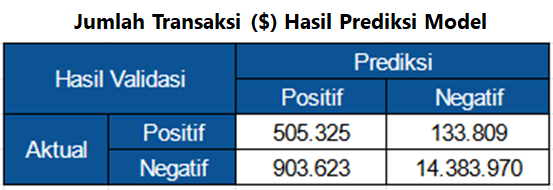

Dengan kondisi saat ini, model dapat menyelamatkan hingga 505.325 USD transaksi fraud, namun mencegah 903.623 USD transaksi normal terjadi. Adapun nilai opportunity loss kasus fraud yang masih dapat lolos yaitu 133.809 USD.

In [248]:
def metric(value):
    aktual = value[0]
    pred = value[1]
    if pred == 1 and aktual == 1:
        return 'TP'
    elif pred == 1 and aktual == 0:
        return 'FP'
    elif pred == 0 and aktual == 1:
        return 'FN'
    elif pred == 0 and aktual == 0:
        return 'TN'

df_result = pd.DataFrame(data = {'y_test': y_test_tuning, 
                                 'y_pred': y_predictions})

df_result['result'] = df_result[['y_test', 'y_pred']].apply(metric, axis=1)

df_result_2 = x_test_tuning.copy()
df_result_2['result'] = df_result['result']

df_result_2 = df_result_2.groupby('result', as_index=False)['TransactionAmt'].sum()
df_result_2

result  TransactionAmt
0     FN    1.338097e+05
1     FP    9.036231e+05
2     TN    1.438397e+07
3     TP    5.053250e+05

### ROC AUC Curve

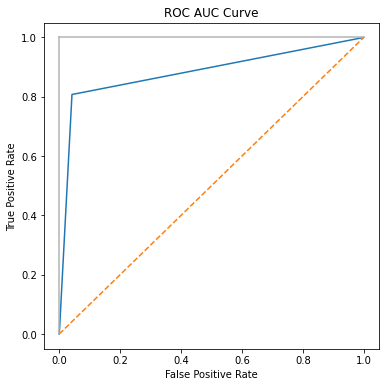

In [176]:
fpr, tpr, threshold = roc_curve(y_test_tuning, y_predictions) 

plt.subplots(1, figsize=(6,6))
plt.title('ROC AUC Curve')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Feature Importance & Shap Analysis

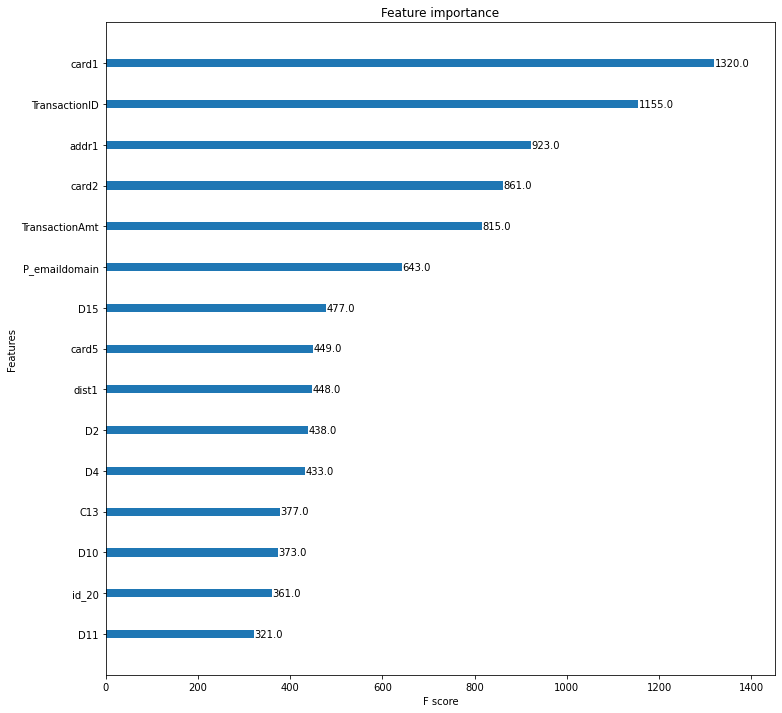

In [208]:
# Feature Importance
plot_importance(final_model, max_num_features=15, grid=False)
plt.show()

Beberapa fitur yang diduga di awal sebagai potensial fitur terdapat pada feature importance pada model. 
Fitur yang cukup berpengaruh pada model adalah TransactionAmt atau jumlah transaksi dan P_emaildomain atau domain email yang digunakan.
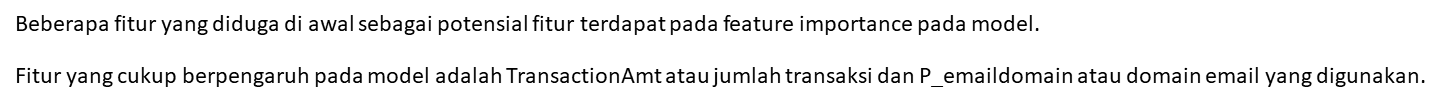

## Prediction

In [78]:
def rename_cols_name(model):
    # Load test data
    df_eval = pd.merge(df_test_transaction, df_test_identity, on = 'TransactionID', how='left')

    # Preprocess columns
    df_eval = df_eval.fillna(-999)

    cols_test = df_eval.columns.tolist()
    cols_train = estimator_3.feature_names_in_

    col_test = [i for i in cols_test if i not in cols_train]
    col_train = [i for i in cols_train if i not in cols_test]

    dicts = dict(zip(col_test, col_train))
    df_eval.rename(columns=dicts, inplace=True)
    
    return df_eval

In [174]:
# For Xgboost
df_eval = rename_cols_name(final_model)
df_eval = df_eval

# especially for xgb
for feature in categorical_features:
    df_eval[feature] = df_eval[feature].astype('category')

# xgboost
y_pred_in_eval = final_model.predict(df_eval[selected_features_bw])

df_pred = pd.DataFrame({'TransactionID': df_eval['TransactionID'],
                        'isFraud': y_pred_in_eval})

df_pred.to_csv('C:/Users/BRI9999ADM/Documents/Working/1_My Equipment/Sertification & Recruitment/Telkomsel/Technical Test/2_Fraud/Output prediction/xgb_undersample_fs_backward_tuning_v4_final.csv', index=False)
df_pred

TransactionID  isFraud
0             3663549        0
1             3663550        0
2             3663551        0
3             3663552        0
4             3663553        0
...               ...      ...
506686        4170235        1
506687        4170236        0
506688        4170237        0
506689        4170238        0
506690        4170239        0

[506691 rows x 2 columns]